# Parquet Export Schema Documentation

This document describes the columns in the exported parquet file, their purposes, and potential use in analytics.

## Base Columns

These are the fundamental event tracking columns:

| Column | Description | Sample Value | Analytics Use |
|--------|-------------|--------------|---------------|
| event_type | Type of event recorded | "customer_event" | Dimension for event categorization |
| event_name | Specific action/event name | "page_viewed", "product_viewed" | Key metric for user actions |
| event_timestamp | When the event occurred | "2025-02-24 01:00:02.268000+00:00" | Time-based analysis, trends |
| shop | Shopify store identifier | "abbott-lyon-global.myshopify.com" | Store-level segmentation |
| page_url | URL where event occurred | "https://www.abbottlyon.com/collections/stud-earrings" | Page performance analysis |
| user_agent | Browser/device information | "Mozilla/5.0 (iPhone; CPU iPhone OS 17_4_1...)" | Raw user agent string |
| session_id | Unique session identifier | "F3DCA419-0f1d-48EA-9ae8-1bf4339caa7d" | Session-based metrics |
| client_id | Client identifier | "abbottlyon" | Client segmentation |
| event_details_id | Unique event identifier | "sh-3577df3b-3EE2-419D-7297-58150024D8F8" | Event deduplication |
| event_details_clientid | Client-specific event ID | "F3DCA419-0f1d-48EA-9ae8-1bf4339caa7d" | Client-side tracking |
| processed_timestamp | When event was processed | "2025-02-24T01:00:03.087594Z" | Processing lag analysis |
| events_tag_id | Tag identifier | "OTB-240722-3B4611" | Tag-based filtering |

## Product Information

Columns related to product data:

| Column | Description | Sample Value | Analytics Use |
|--------|-------------|--------------|---------------|
| price_amount | Product price | 75 | Revenue metrics, AOV |
| price_currency | Currency code | "GBP", "USD" | Multi-currency analysis |
| product_id | Unique product identifier | "7002416119874" | Product performance |
| product_title | Product name | "Pearl Clover Necklace (Gold)" | Product categorization |
| product_type | Product category | "Necklace" | Category analysis |
| variant_id | Product variant ID | "40549131878466" | Variant tracking |
| variant_sku | Stock keeping unit | "SA6180" | Inventory analysis |

## Device Information

Columns for device and browser analytics:

| Column | Description | Sample Value | Analytics Use |
|--------|-------------|--------------|---------------|
| screen_width | Device screen width | 390 | Device compatibility |
| screen_height | Device screen height | 844 | UX optimization |
| device_type | Type of device | "mobile" | Device segmentation |
| browser | Browser name | "Safari", "Chrome" | Browser optimization |
| os | Operating system | "iOS 17.4.1", "Android 10" | OS targeting |

## Marketing Parameters (UTM)

Columns for marketing campaign tracking:

| Column | Description | Sample Value | Analytics Use |
|--------|-------------|--------------|---------------|
| utm_source | Traffic source | "facebook", "google" | Traffic source analysis |
| utm_medium | Marketing medium | "cpc", "email" | Channel performance |
| utm_campaign | Campaign name | "summer_sale_2025" | Campaign tracking |
| utm_content | Ad content identifier | "banner_1" | Creative performance |
| utm_term | Search terms | "gold necklace" | Keyword performance |
| utm_id | Campaign ID | "cam_123" | Campaign correlation |

## Analytics Potential

### Key Metrics

1. **User Engagement**
   - Page views per session
   - Time spent per page
   - Session duration
   - Device/platform usage

2. **Product Performance**
   - Product view counts
   - Product category popularity
   - Price point analysis
   - Variant popularity

3. **Marketing Effectiveness**
   - Campaign conversion rates
   - Channel performance
   - ROI by source
   - Geographic targeting effectiveness

4. **Technical Insights**
   - Device compatibility issues
   - Browser performance
   - Mobile vs desktop usage
   - Screen size optimization

### Dimension Examples

1. **Time-based**
   - Hour of day
   - Day of week
   - Month
   - Season

2. **Product-based**
   - Category
   - Price range
   - Collection
   - Variant

3. **User-based**
   - Device type
   - Browser
   - Operating system
   - Geographic location

4. **Marketing-based**
   - Campaign
   - Source
   - Medium
   - Content version

## Notes

- All timestamp fields are in UTC
- Currency values are stored without conversion
- UTM parameters may be null if not present in the original request
- Device information is extracted from user agent strings
- Product information is only present for product-related events

In [17]:
!pip install scikit-learn

In [18]:
import polars as pl
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
import json

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
df = pl.read_parquet("al_updated_testdata.parquet")
df.head()

shape: (5, 30)
┌────────────┬────────────┬────────────┬────────────┬───┬──────────┬────────┬─────────┬────────────┐
│ event_type ┆ event_name ┆ event_time ┆ shop       ┆ … ┆ utm_term ┆ utm_id ┆ browser ┆ os         │
│ ---        ┆ ---        ┆ stamp      ┆ ---        ┆   ┆ ---      ┆ ---    ┆ ---     ┆ ---        │
│ str        ┆ str        ┆ ---        ┆ str        ┆   ┆ str      ┆ str    ┆ str     ┆ str        │
│            ┆            ┆ datetime[n ┆            ┆   ┆          ┆        ┆         ┆            │
│            ┆            ┆ s, UTC]    ┆            ┆   ┆          ┆        ┆         ┆            │
╞════════════╪════════════╪════════════╪════════════╪═══╪══════════╪════════╪═════════╪════════════╡
│ customer_e ┆ page_viewe ┆ 2025-02-24 ┆ abbott-lyo ┆ … ┆ null     ┆ null   ┆ Safari  ┆ iOS 17.4.1 │
│ vent       ┆ d          ┆ 01:00:02.2 ┆ n-global.m ┆   ┆          ┆        ┆         ┆            │
│            ┆            ┆ 68 UTC     ┆ yshopify.c ┆   ┆          ┆        ┆         ┆            │
│            ┆            ┆            ┆ …          ┆   ┆          ┆        ┆         ┆            │
│ customer_e ┆ page_viewe ┆ 2025-02-24 ┆ abbott-lyo ┆ … ┆ null     ┆ null   ┆ Chrome  ┆ Android 10 │
│ vent       ┆ d          ┆ 01:00:03.0 ┆ n-global.m ┆   ┆          ┆        ┆         ┆            │
│            ┆            ┆ 82 UTC     ┆ yshopify.c ┆   ┆          ┆        ┆         ┆            │
│            ┆            ┆            ┆ …          ┆   ┆          ┆        ┆         ┆            │
│ customer_e ┆ product_vi ┆ 2025-02-24 ┆ abbott-lyo ┆ … ┆ null     ┆ null   ┆ Chrome  ┆ Android 10 │
│ vent       ┆ ewed       ┆ 01:00:03.0 ┆ n-global.m ┆   ┆          ┆        ┆         ┆            │
│            ┆            ┆ 83 UTC     ┆ yshopify.c ┆   ┆          ┆        ┆         ┆            │
│            ┆            ┆            ┆ …          ┆   ┆          ┆        ┆         ┆            │
│ customer_e ┆ page_viewe ┆ 2025-02-24 ┆ abbott-lyo ┆ … ┆ null     ┆ null   ┆ Safari  ┆ iOS 18.0.1 │
│ vent       ┆ d          ┆ 01:00:06.0 ┆ n-global.m ┆   ┆          ┆        ┆         ┆            │
│            ┆            ┆ 95 UTC     ┆ yshopify.c ┆   ┆          ┆        ┆         ┆            │
│            ┆            ┆            ┆ …          ┆   ┆          ┆        ┆         ┆            │
│ customer_e ┆ checkout_s ┆ 2025-02-24 ┆ abbott-lyo ┆ … ┆ null     ┆ null   ┆ Safari  ┆ iOS 18.0.1 │
│ vent       ┆ tarted     ┆ 01:00:06.0 ┆ n-global.m ┆   ┆          ┆        ┆         ┆            │
│            ┆            ┆ 95 UTC     ┆ yshopify.c ┆   ┆          ┆        ┆         ┆            │
│            ┆            ┆            ┆ …          ┆   ┆          ┆        ┆         ┆            │
└────────────┴────────────┴────────────┴────────────┴───┴──────────┴────────┴─────────┴────────────┘

In [20]:
# Get unique sessions with their first timestamp
unique_sessions = df.group_by('session_id').agg([
    pl.col('event_timestamp').min().alias('session_start'),
    pl.col('event_type').first().alias('first_event_type'),
    pl.col('event_name').first().alias('first_event_name'),
    pl.col('shop').first().alias('shop'),
    pl.col('device_type').first().alias('device_type'),
    pl.col('browser').first().alias('browser'),
    pl.col('os').first().alias('os'),
    pl.col('utm_source').first().alias('utm_source'),
    pl.col('utm_medium').first().alias('utm_medium'),
    pl.col('utm_campaign').first().alias('utm_campaign')
]).sort('session_start')

unique_sessions = unique_sessions.drop_nulls()

# Display the first few rows and total count
print(f"Total unique sessions: {len(unique_sessions)}")
unique_sessions.head()

Total unique sessions: 125305


shape: (5, 11)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ session_i ┆ session_s ┆ first_eve ┆ first_eve ┆ … ┆ os        ┆ utm_sourc ┆ utm_mediu ┆ utm_camp │
│ d         ┆ tart      ┆ nt_type   ┆ nt_name   ┆   ┆ ---       ┆ e         ┆ m         ┆ aign     │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ str       ┆ ---       ┆ ---       ┆ ---      │
│ str       ┆ datetime[ ┆ str       ┆ str       ┆   ┆           ┆ str       ┆ str       ┆ str      │
│           ┆ ns, UTC]  ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 64bd50c8- ┆ 2025-02-2 ┆ customer_ ┆ product_v ┆ … ┆ iOS       ┆ google    ┆ cpc       ┆          │
│ 3977-40df ┆ 4 01:00:2 ┆ event     ┆ iewed     ┆   ┆ 18.1.1    ┆           ┆           ┆          │
│ -a109-8ad ┆ 1.487 UTC ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 35e…      ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 4C21613A- ┆ 2025-02-2 ┆ customer_ ┆ page_view ┆ … ┆ iOS 17.7  ┆ google    ┆ cpc       ┆          │
│ 2a84-4C72 ┆ 4 01:00:2 ┆ event     ┆ ed        ┆   ┆           ┆           ┆           ┆          │
│ -9749-a24 ┆ 4.357 UTC ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 3f5…      ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 34578549- ┆ 2025-02-2 ┆ customer_ ┆ product_v ┆ … ┆ iOS       ┆ tiktok    ┆ paid_soci ┆ %5BUK%5D │
│ 565c-4B76 ┆ 4 01:00:3 ┆ event     ┆ iewed     ┆   ┆ 18.3.1    ┆           ┆ al        ┆ %20TOFU_ │
│ -a65d-a2a ┆ 4.406 UTC ┆           ┆           ┆   ┆           ┆           ┆           ┆ 2024_09_ │
│ b55…      ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ Conver…  │
│ FBCF8516- ┆ 2025-02-2 ┆ customer_ ┆ page_view ┆ … ┆ Windows   ┆ dyzio     ┆ social    ┆ UK-INSTA │
│ ed32-440F ┆ 4 01:00:3 ┆ event     ┆ ed        ┆   ┆ 10.0      ┆           ┆           ┆ GRAM-AFF │
│ -b8ab-36f ┆ 6.670 UTC ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 30c…      ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ a6a99f4f- ┆ 2025-02-2 ┆ customer_ ┆ page_view ┆ … ┆ iOS       ┆ Instagram ┆ IGbio     ┆ Mimilink │
│ 3a03-4690 ┆ 4 01:00:3 ┆ event     ┆ ed        ┆   ┆ 18.3.1    ┆           ┆           ┆ inbio    │
│ -96ae-22e ┆ 7.470 UTC ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 8b9…      ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

In [21]:
unique_sessions['utm_source'].value_counts().sort(by='count', descending=True)[:10]

shape: (10, 2)
┌────────────┬───────┐
│ utm_source ┆ count │
│ ---        ┆ ---   │
│ str        ┆ u32   │
╞════════════╪═══════╡
│ google     ┆ 46749 │
│ fbig       ┆ 37629 │
│ Klaviyo    ┆ 21986 │
│ rakuten    ┆ 7757  │
│ tiktok     ┆ 5929  │
│ Instagram  ┆ 1786  │
│ bing       ┆ 1395  │
│ shopify    ┆ 798   │
│ dyzio      ┆ 695   │
│ facebook   ┆ 161   │
└────────────┴───────┘

In [22]:
unique_sessions['utm_medium'].value_counts().sort(by='count', descending=True)[:10]

shape: (10, 2)
┌───────────────────────────────┬───────┐
│ utm_medium                    ┆ count │
│ ---                           ┆ ---   │
│ str                           ┆ u32   │
╞═══════════════════════════════╪═══════╡
│ cpc                           ┆ 48144 │
│ paid_social                   ┆ 43561 │
│ email                         ┆ 21925 │
│ affiliates                    ┆ 7758  │
│ IGbio                         ┆ 1642  │
│ sms                           ┆ 866   │
│ social                        ┆ 850   │
│ IGstory                       ┆ 144   │
│ instagram%20april%20linkinbio ┆ 70    │
│ store-directory               ┆ 54    │
└───────────────────────────────┴───────┘

In [77]:
# First get unique sessions with timestamp and utm_source
unique_sessions = df.group_by('session_id').agg([
    pl.col('event_timestamp').min().alias('session_start'),
    pl.col('utm_source').first().alias('utm_source')
])

# Define the main UTM sources we want to track
main_utm_sources = ['google', 'fbig', 'Klaviyo', 'rakuten', 'tiktok']

# Add time columns and filter for main UTM sources
sessions_by_time = unique_sessions.with_columns([
    pl.col('session_start').dt.truncate('1h').alias('time_truncated'),
    pl.col('session_start').dt.hour().alias('time_hour')
]).filter(pl.col('utm_source').is_in(main_utm_sources))

# Group by time and utm_source
agg_df = (sessions_by_time.group_by(['time_truncated', 'time_hour', 'utm_source'])
            .agg(pl.count().alias('count'))
            .sort('time_truncated'))

# Pivot to create columns for each UTM source
sessions_by_source = (agg_df.pivot(
    index=['time_truncated', 'time_hour'],
    columns='utm_source',
    values='count',
    aggregate_function='sum'
)
.fill_null(0))

# Add Total column (sum of all utm source columns)
utm_columns = [col for col in sessions_by_source.columns if col not in ['time_truncated', 'time_hour']]
sessions_by_source = sessions_by_source.with_columns(
    Total=pl.sum_horizontal(utm_columns)
)

# Rename time_truncated to match the desired format
sessions_by_source = sessions_by_source.rename({'time_truncated': 'time'})

# Reorder columns: time_hour, time, utm columns, Total
final_columns = ['time_hour', 'time'] + utm_columns + ['Total']
sessions_by_source = sessions_by_source.select(final_columns)

# Save to CSV if needed
sessions_by_source.write_csv('sessions_by_source.csv')


sessions_by_source

/var/folders/tt/90qp537n7n542b_rty4fd5lh0000gn/T/ipykernel_4738/911473620.py:18: DeprecationWarning:

`pl.count()` is deprecated. Please use `pl.len()` instead.

/var/folders/tt/90qp537n7n542b_rty4fd5lh0000gn/T/ipykernel_4738/911473620.py:22: DeprecationWarning:

The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.



shape: (119, 8)
┌───────────┬─────────────────────────┬────────┬─────────┬──────┬─────────┬────────┬───────┐
│ time_hour ┆ time                    ┆ google ┆ Klaviyo ┆ fbig ┆ rakuten ┆ tiktok ┆ Total │
│ ---       ┆ ---                     ┆ ---    ┆ ---     ┆ ---  ┆ ---     ┆ ---    ┆ ---   │
│ i8        ┆ datetime[ns, UTC]       ┆ u32    ┆ u32     ┆ u32  ┆ u32     ┆ u32    ┆ u32   │
╞═══════════╪═════════════════════════╪════════╪═════════╪══════╪═════════╪════════╪═══════╡
│ 1         ┆ 2025-02-24 01:00:00 UTC ┆ 82     ┆ 37      ┆ 72   ┆ 41      ┆ 21     ┆ 253   │
│ 2         ┆ 2025-02-24 02:00:00 UTC ┆ 49     ┆ 29      ┆ 45   ┆ 40      ┆ 6      ┆ 169   │
│ 3         ┆ 2025-02-24 03:00:00 UTC ┆ 33     ┆ 23      ┆ 35   ┆ 43      ┆ 6      ┆ 140   │
│ 4         ┆ 2025-02-24 04:00:00 UTC ┆ 31     ┆ 18      ┆ 38   ┆ 22      ┆ 8      ┆ 117   │
│ 5         ┆ 2025-02-24 05:00:00 UTC ┆ 41     ┆ 18      ┆ 55   ┆ 18      ┆ 7      ┆ 139   │
│ …         ┆ …                       ┆ …      ┆ …       ┆ …    ┆ …       ┆ …      ┆ …     │
│ 19        ┆ 2025-02-28 19:00:00 UTC ┆ 680    ┆ 109     ┆ 1350 ┆ 57      ┆ 89     ┆ 2285  │
│ 20        ┆ 2025-02-28 20:00:00 UTC ┆ 821    ┆ 112     ┆ 1429 ┆ 63      ┆ 121    ┆ 2546  │
│ 21        ┆ 2025-02-28 21:00:00 UTC ┆ 822    ┆ 87      ┆ 1483 ┆ 69      ┆ 113    ┆ 2574  │
│ 22        ┆ 2025-02-28 22:00:00 UTC ┆ 645    ┆ 51      ┆ 1118 ┆ 56      ┆ 89     ┆ 1959  │
│ 23        ┆ 2025-02-28 23:00:00 UTC ┆ 365    ┆ 87      ┆ 640  ┆ 36      ┆ 68     ┆ 1196  │
└───────────┴─────────────────────────┴────────┴─────────┴──────┴─────────┴────────┴───────┘

In [78]:
# First get unique sessions with timestamp and utm_medium
unique_sessions = df.group_by('session_id').agg([
    pl.col('event_timestamp').min().alias('session_start'),
    pl.col('utm_medium').first().alias('utm_medium')
])

# Define the main UTM mediums we want to track
main_utm_mediums = ['cpc', 'paid_social', 'email', 'affiliates']

# Add time columns and filter for main UTM mediums
sessions_by_time = unique_sessions.with_columns([
    pl.col('session_start').dt.truncate('1h').alias('time_truncated'),
    pl.col('session_start').dt.hour().alias('time_hour')
]).filter(pl.col('utm_medium').is_in(main_utm_mediums))

# Group by time and utm_medium
agg_df = (sessions_by_time.group_by(['time_truncated', 'time_hour', 'utm_medium'])
            .agg(pl.count().alias('count'))
            .sort('time_truncated'))

# Pivot to create columns for each UTM medium
sessions_by_medium = (agg_df.pivot(
    index=['time_truncated', 'time_hour'],
    columns='utm_medium',
    values='count',
    aggregate_function='sum'
)
.fill_null(0))

# Add Total column (sum of all utm medium columns)
medium_columns = [col for col in sessions_by_medium.columns if col not in ['time_truncated', 'time_hour']]
sessions_by_medium = sessions_by_medium.with_columns(
    Total=pl.sum_horizontal(medium_columns)
)

# Rename time_truncated to match the desired format
sessions_by_medium = sessions_by_medium.rename({'time_truncated': 'time'})

# Reorder columns: time_hour, time, utm columns, Total
final_columns = ['time_hour', 'time'] + medium_columns + ['Total']
sessions_by_medium = sessions_by_medium.select(final_columns)

# Save to CSV if needed
sessions_by_medium.write_csv('sessions_by_medium.csv')

# Display results
print(f"\nTotal unique sessions by medium:")
print("================================")
for col in medium_columns:
    total = sessions_by_medium[col].sum()
    print(f"{col}: {total:,}")
print(f"Total: {sessions_by_medium['Total'].sum():,}")

sessions_by_medium


Total unique sessions by medium:
cpc: 48,391
affiliates: 8,296
email: 21,959
paid_social: 73,461
Total: 152,107


/var/folders/tt/90qp537n7n542b_rty4fd5lh0000gn/T/ipykernel_4738/1087124277.py:18: DeprecationWarning:

`pl.count()` is deprecated. Please use `pl.len()` instead.

/var/folders/tt/90qp537n7n542b_rty4fd5lh0000gn/T/ipykernel_4738/1087124277.py:22: DeprecationWarning:

The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.



shape: (119, 7)
┌───────────┬─────────────────────────┬─────┬────────────┬───────┬─────────────┬───────┐
│ time_hour ┆ time                    ┆ cpc ┆ affiliates ┆ email ┆ paid_social ┆ Total │
│ ---       ┆ ---                     ┆ --- ┆ ---        ┆ ---   ┆ ---         ┆ ---   │
│ i8        ┆ datetime[ns, UTC]       ┆ u32 ┆ u32        ┆ u32   ┆ u32         ┆ u32   │
╞═══════════╪═════════════════════════╪═════╪════════════╪═══════╪═════════════╪═══════╡
│ 1         ┆ 2025-02-24 01:00:00 UTC ┆ 86  ┆ 41         ┆ 39    ┆ 93          ┆ 259   │
│ 2         ┆ 2025-02-24 02:00:00 UTC ┆ 51  ┆ 41         ┆ 29    ┆ 51          ┆ 172   │
│ 3         ┆ 2025-02-24 03:00:00 UTC ┆ 37  ┆ 44         ┆ 23    ┆ 41          ┆ 145   │
│ 4         ┆ 2025-02-24 04:00:00 UTC ┆ 31  ┆ 22         ┆ 18    ┆ 46          ┆ 117   │
│ 5         ┆ 2025-02-24 05:00:00 UTC ┆ 43  ┆ 18         ┆ 20    ┆ 62          ┆ 143   │
│ …         ┆ …                       ┆ …   ┆ …          ┆ …     ┆ …           ┆ …     │
│ 19        ┆ 2025-02-28 19:00:00 UTC ┆ 695 ┆ 57         ┆ 111   ┆ 1439        ┆ 2302  │
│ 20        ┆ 2025-02-28 20:00:00 UTC ┆ 835 ┆ 64         ┆ 116   ┆ 1550        ┆ 2565  │
│ 21        ┆ 2025-02-28 21:00:00 UTC ┆ 830 ┆ 70         ┆ 87    ┆ 1596        ┆ 2583  │
│ 22        ┆ 2025-02-28 22:00:00 UTC ┆ 654 ┆ 56         ┆ 56    ┆ 1207        ┆ 1973  │
│ 23        ┆ 2025-02-28 23:00:00 UTC ┆ 369 ┆ 36         ┆ 91    ┆ 709         ┆ 1205  │
└───────────┴─────────────────────────┴─────┴────────────┴───────┴─────────────┴───────┘

In [25]:
df_original_metrics = df[['event_type',	'event_name',	'event_timestamp',	'shop',	'page_url',	'user_agent', 'session_id',	'client_id', 'event_details_id', 'event_details_clientid']]
df_original_metrics

shape: (1_241_652, 10)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ event_typ ┆ event_nam ┆ event_tim ┆ shop      ┆ … ┆ session_i ┆ client_id ┆ event_det ┆ event_de │
│ e         ┆ e         ┆ estamp    ┆ ---       ┆   ┆ d         ┆ ---       ┆ ails_id   ┆ tails_cl │
│ ---       ┆ ---       ┆ ---       ┆ str       ┆   ┆ ---       ┆ str       ┆ ---       ┆ ientid   │
│ str       ┆ str       ┆ datetime[ ┆           ┆   ┆ str       ┆           ┆ str       ┆ ---      │
│           ┆           ┆ ns, UTC]  ┆           ┆   ┆           ┆           ┆           ┆ str      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ customer_ ┆ page_view ┆ 2025-02-2 ┆ abbott-ly ┆ … ┆ F3DCA419- ┆ abbottlyo ┆ sh-3577df ┆ F3DCA419 │
│ event     ┆ ed        ┆ 4 01:00:0 ┆ on-global ┆   ┆ 0f1d-48EA ┆ n         ┆ 3b-3EE2-4 ┆ -0f1d-48 │
│           ┆           ┆ 2.268 UTC ┆ .myshopif ┆   ┆ -9ae8-1bf ┆           ┆ 19D-7297- ┆ EA-9ae8- │
│           ┆           ┆           ┆ y.c…      ┆   ┆ 433…      ┆           ┆ 581…      ┆ 1bf433…  │
│ customer_ ┆ page_view ┆ 2025-02-2 ┆ abbott-ly ┆ … ┆ 30EBD193- ┆ abbottlyo ┆ sh-3577e3 ┆ 30EBD193 │
│ event     ┆ ed        ┆ 4 01:00:0 ┆ on-global ┆   ┆ 02a8-4F4D ┆ n         ┆ 2a-EA5F-4 ┆ -02a8-4F │
│           ┆           ┆ 3.082 UTC ┆ .myshopif ┆   ┆ -b748-c6c ┆           ┆ A94-12BE- ┆ 4D-b748- │
│           ┆           ┆           ┆ y.c…      ┆   ┆ 6cd…      ┆           ┆ 551…      ┆ c6c6cd…  │
│ customer_ ┆ product_v ┆ 2025-02-2 ┆ abbott-ly ┆ … ┆ 30EBD193- ┆ abbottlyo ┆ sh-3577e3 ┆ 30EBD193 │
│ event     ┆ iewed     ┆ 4 01:00:0 ┆ on-global ┆   ┆ 02a8-4F4D ┆ n         ┆ 2d-5E1C-4 ┆ -02a8-4F │
│           ┆           ┆ 3.083 UTC ┆ .myshopif ┆   ┆ -b748-c6c ┆           ┆ A2C-B717- ┆ 4D-b748- │
│           ┆           ┆           ┆ y.c…      ┆   ┆ 6cd…      ┆           ┆ D37…      ┆ c6c6cd…  │
│ customer_ ┆ page_view ┆ 2025-02-2 ┆ abbott-ly ┆ … ┆ 58608917- ┆ abbottlyo ┆ sh-3577f1 ┆ 58608917 │
│ event     ┆ ed        ┆ 4 01:00:0 ┆ on-global ┆   ┆ c0f1-4402 ┆ n         ┆ 63-05DA-4 ┆ -c0f1-44 │
│           ┆           ┆ 6.095 UTC ┆ .myshopif ┆   ┆ -80c0-abd ┆           ┆ BF9-1BC1- ┆ 02-80c0- │
│           ┆           ┆           ┆ y.c…      ┆   ┆ d89…      ┆           ┆ C77…      ┆ abdd89…  │
│ customer_ ┆ checkout_ ┆ 2025-02-2 ┆ abbott-ly ┆ … ┆ 58608917- ┆ abbottlyo ┆ sh-3577f1 ┆ 58608917 │
│ event     ┆ started   ┆ 4 01:00:0 ┆ on-global ┆   ┆ c0f1-4402 ┆ n         ┆ 64-063A-4 ┆ -c0f1-44 │
│           ┆           ┆ 6.095 UTC ┆ .myshopif ┆   ┆ -80c0-abd ┆           ┆ 17C-834D- ┆ 02-80c0- │
│           ┆           ┆           ┆ y.c…      ┆   ┆ d89…      ┆           ┆ A9D…      ┆ abdd89…  │
│ …         ┆ …         ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …        │
│ customer_ ┆ page_view ┆ 2025-02-2 ┆ abbott-ly ┆ … ┆ 09D77DB3- ┆ abbottlyo ┆ sh-4f00ac ┆ 09D77DB3 │
│ event     ┆ ed        ┆ 8 23:59:5 ┆ on-global ┆   ┆ 6fed-4A86 ┆ n         ┆ e7-24BA-4 ┆ -6fed-4A │
│           ┆           ┆ 8.406 UTC ┆ .myshopif ┆   ┆ -b8a1-fb2 ┆           ┆ 649-28CA- ┆ 86-b8a1- │
│           ┆           ┆           ┆ y.c…      ┆   ┆ 65b…      ┆           ┆ 21B…      ┆ fb265b…  │
│ customer_ ┆ page_view ┆ 2025-02-2 ┆ abbott-ly ┆ … ┆ D3E4B72D- ┆ abbottlyo ┆ sh-4f00b3 ┆ D3E4B72D │
│ event     ┆ ed        ┆ 8 23:59:5 ┆ on-global ┆   ┆ 8604-41C6 ┆ n         ┆ 92-0F0B-4 ┆ -8604-41 │
│           ┆           ┆ 8.535 UTC ┆ .myshopif ┆   ┆ -b47c-a76 ┆           ┆ 67F-3BF4- ┆ C6-b47c- │
│           ┆           ┆           ┆ y.c…      ┆   ┆ ffe…      ┆           ┆ 2EA…      ┆ a76ffe…  │
│ customer_ ┆ product_v ┆ 2025-02-2 ┆ abbott-ly ┆ … ┆ D3E4B72D- ┆ abbottlyo ┆ sh-4f00b3 ┆ D3E4B72D │
│ event     ┆ iewed     ┆ 8 23:59:5 ┆ on-global ┆   ┆ 8604-41C6 ┆ n         ┆ 96-9975-4 ┆ -8604-41 │
│           ┆           ┆ 8.537 UTC ┆ .myshopif ┆   ┆ -b47c-a76 ┆           ┆ CB0-7954- ┆ C6-b47c- │
│           ┆           ┆           ┆ 

In [26]:
df_original_metrics.null_count()
df_original_metrics = df_original_metrics.drop_nulls()

In [27]:
def configure_geography(df):
    # Set geography based on shop column
    df = df.with_columns(
        geography=pl.when(pl.col("shop") == "abbott-lyon-global.myshopify.com")
        .then(pl.lit("Global"))
        .otherwise(pl.lit("US"))
        .cast(pl.Utf8)
    )
    
    return df


def configure_user_agent(df: pl.DataFrame) -> pl.DataFrame:
    # Extract OS family using vectorized string operations
    df = df.with_columns(
        device=pl.when(pl.col("user_agent").str.contains("iPhone|iPad|iOS"))
        .then(pl.lit("iOS"))
        .when(pl.col("user_agent").str.contains("Android"))
        .then(pl.lit("Android"))
        .when(pl.col("user_agent").str.contains("Windows"))
        .then(pl.lit("Windows"))
        .when(pl.col("user_agent").str.contains("Mac OS|Macintosh"))
        .then(pl.lit("macOS"))
        .when(pl.col("user_agent").str.contains("Linux Mint"))
        .then(pl.lit("Linux"))
        .when(pl.col("user_agent").str.contains("Linux"))
        .then(pl.lit("Linux"))
        .when(pl.col("user_agent").str.contains("Tizen|Ubuntu|OpenBSD|FreeBSD|BlackBerry"))
        .then(pl.lit("Other"))
        .otherwise(pl.lit("Other"))
        .cast(pl.Utf8)
    )
    
    # Apply additional device transformations
    df = df.with_columns(
        device=pl.when(pl.col("device") == "Linux Mint")
        .then(pl.lit("Linux"))
        .when(pl.col("device").is_in(["Tizen", "Ubuntu", "OpenBSD", "FreeBSD", "BlackBerry"]))
        .then(pl.lit("Other"))
        .otherwise(pl.col("device"))
        .cast(pl.Utf8)
    )
    
    return df

In [28]:
df = configure_geography(df)
df = configure_user_agent(df)

In [29]:
visitors = df.unique(subset=['event_details_clientid'])
buyers = df.filter(pl.col('event_name') == 'checkout_completed').unique(subset=['event_details_clientid'])
orders = df.filter(pl.col('event_name') == 'checkout_completed')


In [30]:


# Truncate event_timestamp to the hour level
visitors = visitors.with_columns(
    time_truncated=pl.col("event_timestamp").dt.truncate("1h")
)

# Extract hour for the time_hour column (0-23)
visitors = visitors.with_columns(
    time_hour=pl.col("time_truncated").dt.hour()
)

# Group by truncated time and geography, then count events
agg_df = (visitors.group_by("time_truncated", "time_hour", "geography")
            .agg(pl.count().alias("count"))
            .sort("time_truncated"))  # Sort by time for chronological order

# Pivot to create Global and US columns
visitors_by_geography = (agg_df.pivot(
    index=["time_truncated", "time_hour"],
    columns="geography",
    values="count",
    aggregate_function="sum"
)
.fill_null(0))  # Fill nulls with 0 for hours with no events in a geography

# Add Total column (sum of Global and US)
visitors_by_geography = visitors_by_geography.with_columns(
    Total=pl.col("Global") + pl.col("US")
)

# Rename time_truncated to match the image format
visitors_by_geography = visitors_by_geography.rename({"time_truncated": "time"})

# Reorder columns to match the image (time_hour, time, Global, US, Total)
visitors_by_geography = visitors_by_geography.select(["time_hour", "time", "Global", "US", "Total"])
visitors_by_geography.write_csv("visitors_by_geography.csv")
visitors_by_geography

/var/folders/tt/90qp537n7n542b_rty4fd5lh0000gn/T/ipykernel_4738/3905797942.py:13: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  .agg(pl.count().alias("count"))
/var/folders/tt/90qp537n7n542b_rty4fd5lh0000gn/T/ipykernel_4738/3905797942.py:17: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.
  visitors_by_geography = (agg_df.pivot(


shape: (119, 5)
┌───────────┬─────────────────────────┬────────┬─────┬───────┐
│ time_hour ┆ time                    ┆ Global ┆ US  ┆ Total │
│ ---       ┆ ---                     ┆ ---    ┆ --- ┆ ---   │
│ i8        ┆ datetime[ns, UTC]       ┆ u32    ┆ u32 ┆ u32   │
╞═══════════╪═════════════════════════╪════════╪═════╪═══════╡
│ 1         ┆ 2025-02-24 01:00:00 UTC ┆ 420    ┆ 180 ┆ 600   │
│ 2         ┆ 2025-02-24 02:00:00 UTC ┆ 264    ┆ 160 ┆ 424   │
│ 3         ┆ 2025-02-24 03:00:00 UTC ┆ 203    ┆ 152 ┆ 355   │
│ 4         ┆ 2025-02-24 04:00:00 UTC ┆ 210    ┆ 86  ┆ 296   │
│ 5         ┆ 2025-02-24 05:00:00 UTC ┆ 254    ┆ 89  ┆ 343   │
│ …         ┆ …                       ┆ …      ┆ …   ┆ …     │
│ 19        ┆ 2025-02-28 19:00:00 UTC ┆ 3453   ┆ 160 ┆ 3613  │
│ 20        ┆ 2025-02-28 20:00:00 UTC ┆ 3854   ┆ 106 ┆ 3960  │
│ 21        ┆ 2025-02-28 21:00:00 UTC ┆ 3860   ┆ 116 ┆ 3976  │
│ 22        ┆ 2025-02-28 22:00:00 UTC ┆ 3023   ┆ 97  ┆ 3120  │
│ 23        ┆ 2025-02-28 23:00:00 UTC ┆ 1822   ┆ 133 ┆ 1955  │
└───────────┴─────────────────────────┴────────┴─────┴───────┘

In [31]:


visitors = visitors.with_columns(
    time_truncated=pl.col("event_timestamp").dt.truncate("1h")
)

visitors = visitors.with_columns(
    time_hour=pl.col("time_truncated").dt.hour()
)
agg_df = (visitors.group_by("time_truncated", "time_hour", "device")
            .agg(pl.count().alias("count"))
            .sort("time_truncated")) 

visitors_by_device = (agg_df.pivot(
    index=["time_truncated", "time_hour"],
    columns="device",
    values="count",
    aggregate_function="sum"
)
.fill_null(0)) 

# Add Total column (sum of all device columns)
device_columns = [col for col in visitors_by_device.columns if col not in ["time_truncated", "time_hour"]]
visitors_by_device = visitors_by_device.with_columns(
    Total=pl.sum_horizontal(device_columns)
)

# Rename time_truncated to match the desired format
visitors_by_device = visitors_by_device.rename({"time_truncated": "time"})

# Reorder columns: time_hour, time, device columns, Total
final_columns = ["time_hour", "time"] + device_columns + ["Total"]
visitors_by_device = visitors_by_device.select(final_columns)
visitors_by_device.write_csv("visitors_by_device.csv")
visitors_by_device

/var/folders/tt/90qp537n7n542b_rty4fd5lh0000gn/T/ipykernel_4738/3420203699.py:9: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  .agg(pl.count().alias("count"))
/var/folders/tt/90qp537n7n542b_rty4fd5lh0000gn/T/ipykernel_4738/3420203699.py:12: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.
  visitors_by_device = (agg_df.pivot(


shape: (119, 9)
┌───────────┬─────────────────────────┬──────┬───────┬───┬─────────┬─────────┬───────┬───────┐
│ time_hour ┆ time                    ┆ iOS  ┆ macOS ┆ … ┆ Android ┆ Windows ┆ Other ┆ Total │
│ ---       ┆ ---                     ┆ ---  ┆ ---   ┆   ┆ ---     ┆ ---     ┆ ---   ┆ ---   │
│ i8        ┆ datetime[ns, UTC]       ┆ u32  ┆ u32   ┆   ┆ u32     ┆ u32     ┆ u32   ┆ u32   │
╞═══════════╪═════════════════════════╪══════╪═══════╪═══╪═════════╪═════════╪═══════╪═══════╡
│ 1         ┆ 2025-02-24 01:00:00 UTC ┆ 396  ┆ 37    ┆ … ┆ 88      ┆ 26      ┆ 38    ┆ 600   │
│ 2         ┆ 2025-02-24 02:00:00 UTC ┆ 260  ┆ 31    ┆ … ┆ 77      ┆ 24      ┆ 31    ┆ 424   │
│ 3         ┆ 2025-02-24 03:00:00 UTC ┆ 237  ┆ 22    ┆ … ┆ 43      ┆ 9       ┆ 27    ┆ 355   │
│ 4         ┆ 2025-02-24 04:00:00 UTC ┆ 188  ┆ 16    ┆ … ┆ 48      ┆ 15      ┆ 25    ┆ 296   │
│ 5         ┆ 2025-02-24 05:00:00 UTC ┆ 198  ┆ 27    ┆ … ┆ 41      ┆ 21      ┆ 34    ┆ 343   │
│ …         ┆ …                       ┆ …    ┆ …     ┆ … ┆ …       ┆ …       ┆ …     ┆ …     │
│ 19        ┆ 2025-02-28 19:00:00 UTC ┆ 2669 ┆ 80    ┆ … ┆ 748     ┆ 73      ┆ 31    ┆ 3613  │
│ 20        ┆ 2025-02-28 20:00:00 UTC ┆ 2898 ┆ 87    ┆ … ┆ 877     ┆ 63      ┆ 31    ┆ 3960  │
│ 21        ┆ 2025-02-28 21:00:00 UTC ┆ 2940 ┆ 63    ┆ … ┆ 894     ┆ 45      ┆ 27    ┆ 3976  │
│ 22        ┆ 2025-02-28 22:00:00 UTC ┆ 2354 ┆ 68    ┆ … ┆ 635     ┆ 37      ┆ 23    ┆ 3120  │
│ 23        ┆ 2025-02-28 23:00:00 UTC ┆ 1435 ┆ 62    ┆ … ┆ 354     ┆ 50      ┆ 20    ┆ 1955  │
└───────────┴─────────────────────────┴──────┴───────┴───┴─────────┴─────────┴───────┴───────┘

In [32]:


# Truncate event_timestamp to the hour level
orders = orders.with_columns(
    time_truncated=pl.col("event_timestamp").dt.truncate("1h")
)

# Extract hour for the time_hour column (0-23)
orders = orders.with_columns(
    time_hour=pl.col("time_truncated").dt.hour()
)

# Group by truncated time and geography, then count events
agg_df = (orders.group_by("time_truncated", "time_hour", "geography")
            .agg(pl.count().alias("count"))
            .sort("time_truncated"))  # Sort by time for chronological order

# Pivot to create Global and US columns
orders_by_geography = (agg_df.pivot(
    index=["time_truncated", "time_hour"],
    columns="geography",
    values="count",
    aggregate_function="sum"
)
.fill_null(0))  # Fill nulls with 0 for hours with no events in a geography

# Add Total column (sum of Global and US)
orders_by_geography = orders_by_geography.with_columns(
    Total=pl.col("Global") + pl.col("US")
)

# Rename time_truncated to match the image format
orders_by_geography = orders_by_geography.rename({"time_truncated": "time"})

# Reorder columns to match the image (time_hour, time, Global, US, Total)
orders_by_geography = orders_by_geography.select(["time_hour", "time", "Global", "US", "Total"])
orders_by_geography.write_csv("orders_by_geography.csv")
orders_by_geography

/var/folders/tt/90qp537n7n542b_rty4fd5lh0000gn/T/ipykernel_4738/276100296.py:13: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  .agg(pl.count().alias("count"))
/var/folders/tt/90qp537n7n542b_rty4fd5lh0000gn/T/ipykernel_4738/276100296.py:17: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.
  orders_by_geography = (agg_df.pivot(


shape: (119, 5)
┌───────────┬─────────────────────────┬────────┬─────┬───────┐
│ time_hour ┆ time                    ┆ Global ┆ US  ┆ Total │
│ ---       ┆ ---                     ┆ ---    ┆ --- ┆ ---   │
│ i8        ┆ datetime[ns, UTC]       ┆ u32    ┆ u32 ┆ u32   │
╞═══════════╪═════════════════════════╪════════╪═════╪═══════╡
│ 1         ┆ 2025-02-24 01:00:00 UTC ┆ 4      ┆ 6   ┆ 10    │
│ 2         ┆ 2025-02-24 02:00:00 UTC ┆ 1      ┆ 7   ┆ 8     │
│ 3         ┆ 2025-02-24 03:00:00 UTC ┆ 2      ┆ 2   ┆ 4     │
│ 4         ┆ 2025-02-24 04:00:00 UTC ┆ 2      ┆ 4   ┆ 6     │
│ 5         ┆ 2025-02-24 05:00:00 UTC ┆ 2      ┆ 4   ┆ 6     │
│ …         ┆ …                       ┆ …      ┆ …   ┆ …     │
│ 19        ┆ 2025-02-28 19:00:00 UTC ┆ 126    ┆ 2   ┆ 128   │
│ 20        ┆ 2025-02-28 20:00:00 UTC ┆ 176    ┆ 5   ┆ 181   │
│ 21        ┆ 2025-02-28 21:00:00 UTC ┆ 129    ┆ 1   ┆ 130   │
│ 22        ┆ 2025-02-28 22:00:00 UTC ┆ 110    ┆ 3   ┆ 113   │
│ 23        ┆ 2025-02-28 23:00:00 UTC ┆ 66     ┆ 2   ┆ 68    │
└───────────┴─────────────────────────┴────────┴─────┴───────┘

In [33]:


orders = orders.with_columns(
    time_truncated=pl.col("event_timestamp").dt.truncate("1h")
)

orders = orders.with_columns(
    time_hour=pl.col("time_truncated").dt.hour()
)
agg_df = (orders.group_by("time_truncated", "time_hour", "device")
            .agg(pl.count().alias("count"))
            .sort("time_truncated")) 

orders_by_device = (agg_df.pivot(
    index=["time_truncated", "time_hour"],
    columns="device",
    values="count",
    aggregate_function="sum"
)
.fill_null(0)) 

# Add Total column (sum of all device columns)
device_columns = [col for col in orders_by_device.columns if col not in ["time_truncated", "time_hour"]]
orders_by_device = orders_by_device.with_columns(
    Total=pl.sum_horizontal(device_columns)
)

# Rename time_truncated to match the desired format
orders_by_device = orders_by_device.rename({"time_truncated": "time"})

# Reorder columns: time_hour, time, device columns, Total
final_columns = ["time_hour", "time"] + device_columns + ["Total"]
orders_by_device = orders_by_device.select(final_columns)
orders_by_device.write_csv("orders_by_device.csv")
orders_by_device

/var/folders/tt/90qp537n7n542b_rty4fd5lh0000gn/T/ipykernel_4738/924682618.py:9: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  .agg(pl.count().alias("count"))
/var/folders/tt/90qp537n7n542b_rty4fd5lh0000gn/T/ipykernel_4738/924682618.py:12: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.
  orders_by_device = (agg_df.pivot(


shape: (119, 9)
┌───────────┬─────────────────────────┬─────────┬─────────┬───┬─────┬───────┬───────┬───────┐
│ time_hour ┆ time                    ┆ Android ┆ Windows ┆ … ┆ iOS ┆ Linux ┆ Other ┆ Total │
│ ---       ┆ ---                     ┆ ---     ┆ ---     ┆   ┆ --- ┆ ---   ┆ ---   ┆ ---   │
│ i8        ┆ datetime[ns, UTC]       ┆ u32     ┆ u32     ┆   ┆ u32 ┆ u32   ┆ u32   ┆ u32   │
╞═══════════╪═════════════════════════╪═════════╪═════════╪═══╪═════╪═══════╪═══════╪═══════╡
│ 1         ┆ 2025-02-24 01:00:00 UTC ┆ 2       ┆ 1       ┆ … ┆ 5   ┆ 0     ┆ 0     ┆ 10    │
│ 2         ┆ 2025-02-24 02:00:00 UTC ┆ 0       ┆ 6       ┆ … ┆ 2   ┆ 0     ┆ 0     ┆ 8     │
│ 3         ┆ 2025-02-24 03:00:00 UTC ┆ 1       ┆ 1       ┆ … ┆ 2   ┆ 0     ┆ 0     ┆ 4     │
│ 4         ┆ 2025-02-24 04:00:00 UTC ┆ 0       ┆ 1       ┆ … ┆ 5   ┆ 0     ┆ 0     ┆ 6     │
│ 5         ┆ 2025-02-24 05:00:00 UTC ┆ 0       ┆ 3       ┆ … ┆ 1   ┆ 0     ┆ 0     ┆ 6     │
│ …         ┆ …                       ┆ …       ┆ …       ┆ … ┆ …   ┆ …     ┆ …     ┆ …     │
│ 19        ┆ 2025-02-28 19:00:00 UTC ┆ 23      ┆ 2       ┆ … ┆ 100 ┆ 0     ┆ 0     ┆ 128   │
│ 20        ┆ 2025-02-28 20:00:00 UTC ┆ 41      ┆ 5       ┆ … ┆ 129 ┆ 0     ┆ 0     ┆ 181   │
│ 21        ┆ 2025-02-28 21:00:00 UTC ┆ 20      ┆ 2       ┆ … ┆ 107 ┆ 0     ┆ 0     ┆ 130   │
│ 22        ┆ 2025-02-28 22:00:00 UTC ┆ 26      ┆ 3       ┆ … ┆ 79  ┆ 0     ┆ 0     ┆ 113   │
│ 23        ┆ 2025-02-28 23:00:00 UTC ┆ 12      ┆ 4       ┆ … ┆ 49  ┆ 0     ┆ 0     ┆ 68    │
└───────────┴─────────────────────────┴─────────┴─────────┴───┴─────┴───────┴───────┴───────┘

In [34]:


# Truncate event_timestamp to the hour level
buyers = buyers.with_columns(
    time_truncated=pl.col("event_timestamp").dt.truncate("1h")
)

# Extract hour for the time_hour column (0-23)
buyers = buyers.with_columns(
    time_hour=pl.col("time_truncated").dt.hour()
)

# Group by truncated time and geography, then count events
agg_df = (buyers.group_by("time_truncated", "time_hour", "geography")
            .agg(pl.count().alias("count"))
            .sort("time_truncated"))  # Sort by time for chronological order

# Pivot to create Global and US columns
buyers_by_geography = (agg_df.pivot(
    index=["time_truncated", "time_hour"],
    columns="geography",
    values="count",
    aggregate_function="sum"
)
.fill_null(0))  # Fill nulls with 0 for hours with no events in a geography

# Add Total column (sum of Global and US)
buyers_by_geography = buyers_by_geography.with_columns(
    Total=pl.col("Global") + pl.col("US")
)

# Rename time_truncated to match the image format
buyers_by_geography = buyers_by_geography.rename({"time_truncated": "time"})

# Reorder columns to match the image (time_hour, time, Global, US, Total)
buyers_by_geography = buyers_by_geography.select(["time_hour", "time", "Global", "US", "Total"])
buyers_by_geography.write_csv("buyers_by_geography.csv")
buyers_by_geography

/var/folders/tt/90qp537n7n542b_rty4fd5lh0000gn/T/ipykernel_4738/3577645627.py:13: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  .agg(pl.count().alias("count"))
/var/folders/tt/90qp537n7n542b_rty4fd5lh0000gn/T/ipykernel_4738/3577645627.py:17: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.
  buyers_by_geography = (agg_df.pivot(


shape: (119, 5)
┌───────────┬─────────────────────────┬────────┬─────┬───────┐
│ time_hour ┆ time                    ┆ Global ┆ US  ┆ Total │
│ ---       ┆ ---                     ┆ ---    ┆ --- ┆ ---   │
│ i8        ┆ datetime[ns, UTC]       ┆ u32    ┆ u32 ┆ u32   │
╞═══════════╪═════════════════════════╪════════╪═════╪═══════╡
│ 1         ┆ 2025-02-24 01:00:00 UTC ┆ 4      ┆ 6   ┆ 10    │
│ 2         ┆ 2025-02-24 02:00:00 UTC ┆ 1      ┆ 7   ┆ 8     │
│ 3         ┆ 2025-02-24 03:00:00 UTC ┆ 2      ┆ 2   ┆ 4     │
│ 4         ┆ 2025-02-24 04:00:00 UTC ┆ 2      ┆ 3   ┆ 5     │
│ 5         ┆ 2025-02-24 05:00:00 UTC ┆ 2      ┆ 3   ┆ 5     │
│ …         ┆ …                       ┆ …      ┆ …   ┆ …     │
│ 19        ┆ 2025-02-28 19:00:00 UTC ┆ 124    ┆ 2   ┆ 126   │
│ 20        ┆ 2025-02-28 20:00:00 UTC ┆ 169    ┆ 5   ┆ 174   │
│ 21        ┆ 2025-02-28 21:00:00 UTC ┆ 123    ┆ 0   ┆ 123   │
│ 22        ┆ 2025-02-28 22:00:00 UTC ┆ 106    ┆ 2   ┆ 108   │
│ 23        ┆ 2025-02-28 23:00:00 UTC ┆ 64     ┆ 2   ┆ 66    │
└───────────┴─────────────────────────┴────────┴─────┴───────┘

In [35]:


buyers = buyers.with_columns(
    time_truncated=pl.col("event_timestamp").dt.truncate("1h")
)

buyers = buyers.with_columns(
    time_hour=pl.col("time_truncated").dt.hour()
)
agg_df = (buyers.group_by("time_truncated", "time_hour", "device")
            .agg(pl.count().alias("count"))
            .sort("time_truncated")) 

buyers_by_device = (agg_df.pivot(
    index=["time_truncated", "time_hour"],
    columns="device",
    values="count",
    aggregate_function="sum"
)
.fill_null(0)) 

# Add Total column (sum of all device columns)
device_columns = [col for col in buyers_by_device.columns if col not in ["time_truncated", "time_hour"]]
buyers_by_device = buyers_by_device.with_columns(
    Total=pl.sum_horizontal(device_columns)
)

# Rename time_truncated to match the desired format
buyers_by_device = buyers_by_device.rename({"time_truncated": "time"})

# Reorder columns: time_hour, time, device columns, Total
final_columns = ["time_hour", "time"] + device_columns + ["Total"]
buyers_by_device = buyers_by_device.select(final_columns)
buyers_by_device.write_csv("buyers_by_device.csv")
buyers_by_device

/var/folders/tt/90qp537n7n542b_rty4fd5lh0000gn/T/ipykernel_4738/3937856674.py:9: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  .agg(pl.count().alias("count"))
/var/folders/tt/90qp537n7n542b_rty4fd5lh0000gn/T/ipykernel_4738/3937856674.py:12: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.
  buyers_by_device = (agg_df.pivot(


shape: (119, 9)
┌───────────┬─────────────────────────┬─────────┬─────┬───┬───────┬───────┬───────┬───────┐
│ time_hour ┆ time                    ┆ Android ┆ iOS ┆ … ┆ macOS ┆ Linux ┆ Other ┆ Total │
│ ---       ┆ ---                     ┆ ---     ┆ --- ┆   ┆ ---   ┆ ---   ┆ ---   ┆ ---   │
│ i8        ┆ datetime[ns, UTC]       ┆ u32     ┆ u32 ┆   ┆ u32   ┆ u32   ┆ u32   ┆ u32   │
╞═══════════╪═════════════════════════╪═════════╪═════╪═══╪═══════╪═══════╪═══════╪═══════╡
│ 1         ┆ 2025-02-24 01:00:00 UTC ┆ 2       ┆ 5   ┆ … ┆ 2     ┆ 0     ┆ 0     ┆ 10    │
│ 2         ┆ 2025-02-24 02:00:00 UTC ┆ 0       ┆ 2   ┆ … ┆ 0     ┆ 0     ┆ 0     ┆ 8     │
│ 3         ┆ 2025-02-24 03:00:00 UTC ┆ 1       ┆ 2   ┆ … ┆ 0     ┆ 0     ┆ 0     ┆ 4     │
│ 4         ┆ 2025-02-24 04:00:00 UTC ┆ 0       ┆ 5   ┆ … ┆ 0     ┆ 0     ┆ 0     ┆ 5     │
│ 5         ┆ 2025-02-24 05:00:00 UTC ┆ 0       ┆ 1   ┆ … ┆ 2     ┆ 0     ┆ 0     ┆ 5     │
│ …         ┆ …                       ┆ …       ┆ …   ┆ … ┆ …     ┆ …     ┆ …     ┆ …     │
│ 19        ┆ 2025-02-28 19:00:00 UTC ┆ 23      ┆ 98  ┆ … ┆ 3     ┆ 0     ┆ 0     ┆ 126   │
│ 20        ┆ 2025-02-28 20:00:00 UTC ┆ 40      ┆ 123 ┆ … ┆ 6     ┆ 0     ┆ 0     ┆ 174   │
│ 21        ┆ 2025-02-28 21:00:00 UTC ┆ 19      ┆ 102 ┆ … ┆ 1     ┆ 0     ┆ 0     ┆ 123   │
│ 22        ┆ 2025-02-28 22:00:00 UTC ┆ 24      ┆ 77  ┆ … ┆ 5     ┆ 0     ┆ 0     ┆ 108   │
│ 23        ┆ 2025-02-28 23:00:00 UTC ┆ 10      ┆ 49  ┆ … ┆ 3     ┆ 0     ┆ 0     ┆ 66    │
└───────────┴─────────────────────────┴─────────┴─────┴───┴───────┴───────┴───────┴───────┘

In [36]:
landing_page_viewers = df.filter(pl.col('event_name') == 'page_viewed').unique(subset=['session_id'])
product_viewers = df.filter(pl.col('event_name') == 'product_viewed')
added_to_cart = df.filter(pl.col('event_name') == 'product_added_to_cart')
checkout_started = df.filter(pl.col('event_name') == 'checkout_started')
checkout_completed = df.filter(pl.col('event_name') == 'checkout_completed')



In [37]:
landing_page_viewers = landing_page_viewers.with_columns(
    time_truncated=pl.col("event_timestamp").dt.truncate("1h")
)

landing_page_viewers = landing_page_viewers.with_columns(
    time_hour=pl.col("time_truncated").dt.hour()
)
agg_df = (landing_page_viewers.group_by("time_truncated", "time_hour", "device")
            .agg(pl.count().alias("count"))
            .sort("time_truncated")) 

landing_page_viewers_by_device = (agg_df.pivot(
    index=["time_truncated", "time_hour"],
    columns="device",
    values="count",
    aggregate_function="sum"
)
.fill_null(0)) 

# Add Total column (sum of all device columns)
device_columns = [col for col in landing_page_viewers_by_device.columns if col not in ["time_truncated", "time_hour"]]
landing_page_viewers_by_device = landing_page_viewers_by_device.with_columns(
    Total=pl.sum_horizontal(device_columns)
)

# Rename time_truncated to match the desired format
landing_page_viewers_by_device = landing_page_viewers_by_device.rename({"time_truncated": "time"})

# Reorder columns: time_hour, time, device columns, Total
final_columns = ["time_hour", "time"] + device_columns + ["Total"]
landing_page_viewers_by_device = landing_page_viewers_by_device.select(final_columns)

landing_page_viewers_by_device.write_csv('landing_page_viewers_by_device.csv')
landing_page_viewers_by_device

/var/folders/tt/90qp537n7n542b_rty4fd5lh0000gn/T/ipykernel_4738/2205088037.py:9: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  .agg(pl.count().alias("count"))
/var/folders/tt/90qp537n7n542b_rty4fd5lh0000gn/T/ipykernel_4738/2205088037.py:12: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.
  landing_page_viewers_by_device = (agg_df.pivot(


shape: (119, 9)
┌───────────┬─────────────────────────┬───────┬─────────┬───┬───────┬───────┬─────────┬───────┐
│ time_hour ┆ time                    ┆ macOS ┆ Windows ┆ … ┆ Other ┆ Linux ┆ Android ┆ Total │
│ ---       ┆ ---                     ┆ ---   ┆ ---     ┆   ┆ ---   ┆ ---   ┆ ---     ┆ ---   │
│ i8        ┆ datetime[ns, UTC]       ┆ u32   ┆ u32     ┆   ┆ u32   ┆ u32   ┆ u32     ┆ u32   │
╞═══════════╪═════════════════════════╪═══════╪═════════╪═══╪═══════╪═══════╪═════════╪═══════╡
│ 1         ┆ 2025-02-24 01:00:00 UTC ┆ 37    ┆ 26      ┆ … ┆ 38    ┆ 15    ┆ 88      ┆ 599   │
│ 2         ┆ 2025-02-24 02:00:00 UTC ┆ 31    ┆ 24      ┆ … ┆ 31    ┆ 1     ┆ 77      ┆ 424   │
│ 3         ┆ 2025-02-24 03:00:00 UTC ┆ 22    ┆ 9       ┆ … ┆ 27    ┆ 17    ┆ 42      ┆ 354   │
│ 4         ┆ 2025-02-24 04:00:00 UTC ┆ 16    ┆ 15      ┆ … ┆ 25    ┆ 4     ┆ 48      ┆ 296   │
│ 5         ┆ 2025-02-24 05:00:00 UTC ┆ 27    ┆ 21      ┆ … ┆ 34    ┆ 22    ┆ 41      ┆ 343   │
│ …         ┆ …                       ┆ …     ┆ …       ┆ … ┆ …     ┆ …     ┆ …       ┆ …     │
│ 19        ┆ 2025-02-28 19:00:00 UTC ┆ 79    ┆ 73      ┆ … ┆ 31    ┆ 11    ┆ 746     ┆ 3605  │
│ 20        ┆ 2025-02-28 20:00:00 UTC ┆ 87    ┆ 63      ┆ … ┆ 31    ┆ 4     ┆ 877     ┆ 3954  │
│ 21        ┆ 2025-02-28 21:00:00 UTC ┆ 63    ┆ 45      ┆ … ┆ 27    ┆ 7     ┆ 894     ┆ 3965  │
│ 22        ┆ 2025-02-28 22:00:00 UTC ┆ 68    ┆ 37      ┆ … ┆ 23    ┆ 3     ┆ 632     ┆ 3114  │
│ 23        ┆ 2025-02-28 23:00:00 UTC ┆ 61    ┆ 50      ┆ … ┆ 20    ┆ 34    ┆ 352     ┆ 1949  │
└───────────┴─────────────────────────┴───────┴─────────┴───┴───────┴───────┴─────────┴───────┘

In [38]:
product_viewers = product_viewers.with_columns(
    time_truncated=pl.col("event_timestamp").dt.truncate("1h")
)

product_viewers = product_viewers.with_columns(
    time_hour=pl.col("time_truncated").dt.hour()
)
agg_df = (product_viewers.group_by("time_truncated", "time_hour", "device")
            .agg(pl.count().alias("count"))
            .sort("time_truncated")) 

product_viewers_by_device = (agg_df.pivot(
    index=["time_truncated", "time_hour"],
    columns="device",
    values="count",
    aggregate_function="sum"
)
.fill_null(0)) 

# Add Total column (sum of all device columns)
device_columns = [col for col in product_viewers_by_device.columns if col not in ["time_truncated", "time_hour"]]
product_viewers_by_device = product_viewers_by_device.with_columns(
    Total=pl.sum_horizontal(device_columns)
)

# Rename time_truncated to match the desired format
product_viewers_by_device = product_viewers_by_device.rename({"time_truncated": "time"})

# Reorder columns: time_hour, time, device columns, Total
final_columns = ["time_hour", "time"] + device_columns + ["Total"]
product_viewers_by_device = product_viewers_by_device.select(final_columns)

product_viewers_by_device.write_csv('product_viewers_by_device.csv')
product_viewers_by_device

/var/folders/tt/90qp537n7n542b_rty4fd5lh0000gn/T/ipykernel_4738/3280794540.py:9: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  .agg(pl.count().alias("count"))
/var/folders/tt/90qp537n7n542b_rty4fd5lh0000gn/T/ipykernel_4738/3280794540.py:12: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.
  product_viewers_by_device = (agg_df.pivot(


shape: (119, 9)
┌───────────┬─────────────────────────┬───────┬─────────┬───┬─────────┬───────┬───────┬───────┐
│ time_hour ┆ time                    ┆ Linux ┆ Android ┆ … ┆ Windows ┆ Other ┆ macOS ┆ Total │
│ ---       ┆ ---                     ┆ ---   ┆ ---     ┆   ┆ ---     ┆ ---   ┆ ---   ┆ ---   │
│ i8        ┆ datetime[ns, UTC]       ┆ u32   ┆ u32     ┆   ┆ u32     ┆ u32   ┆ u32   ┆ u32   │
╞═══════════╪═════════════════════════╪═══════╪═════════╪═══╪═════════╪═══════╪═══════╪═══════╡
│ 1         ┆ 2025-02-24 01:00:00 UTC ┆ 5     ┆ 103     ┆ … ┆ 11      ┆ 25    ┆ 44    ┆ 560   │
│ 2         ┆ 2025-02-24 02:00:00 UTC ┆ 0     ┆ 56      ┆ … ┆ 6       ┆ 23    ┆ 27    ┆ 467   │
│ 3         ┆ 2025-02-24 03:00:00 UTC ┆ 3     ┆ 76      ┆ … ┆ 7       ┆ 21    ┆ 16    ┆ 431   │
│ 4         ┆ 2025-02-24 04:00:00 UTC ┆ 4     ┆ 87      ┆ … ┆ 18      ┆ 20    ┆ 13    ┆ 366   │
│ 5         ┆ 2025-02-24 05:00:00 UTC ┆ 3     ┆ 34      ┆ … ┆ 31      ┆ 41    ┆ 23    ┆ 313   │
│ …         ┆ …                       ┆ …     ┆ …       ┆ … ┆ …       ┆ …     ┆ …     ┆ …     │
│ 19        ┆ 2025-02-28 19:00:00 UTC ┆ 3     ┆ 1248    ┆ … ┆ 70      ┆ 36    ┆ 114   ┆ 5341  │
│ 20        ┆ 2025-02-28 20:00:00 UTC ┆ 2     ┆ 1541    ┆ … ┆ 77      ┆ 25    ┆ 141   ┆ 6443  │
│ 21        ┆ 2025-02-28 21:00:00 UTC ┆ 0     ┆ 1594    ┆ … ┆ 59      ┆ 22    ┆ 107   ┆ 6344  │
│ 22        ┆ 2025-02-28 22:00:00 UTC ┆ 2     ┆ 1162    ┆ … ┆ 37      ┆ 24    ┆ 110   ┆ 5089  │
│ 23        ┆ 2025-02-28 23:00:00 UTC ┆ 9     ┆ 604     ┆ … ┆ 70      ┆ 20    ┆ 73    ┆ 2941  │
└───────────┴─────────────────────────┴───────┴─────────┴───┴─────────┴───────┴───────┴───────┘

In [39]:
added_to_cart = added_to_cart.with_columns(
    time_truncated=pl.col("event_timestamp").dt.truncate("1h")
)

added_to_cart = added_to_cart.with_columns(
    time_hour=pl.col("time_truncated").dt.hour()
)
agg_df = (added_to_cart.group_by("time_truncated", "time_hour", "device")
            .agg(pl.count().alias("count"))
            .sort("time_truncated")) 

added_to_cart_by_device = (agg_df.pivot(
    index=["time_truncated", "time_hour"],
    columns="device",
    values="count",
    aggregate_function="sum"
)
.fill_null(0)) 

# Add Total column (sum of all device columns)
device_columns = [col for col in added_to_cart_by_device.columns if col not in ["time_truncated", "time_hour"]]
added_to_cart_by_device = added_to_cart_by_device.with_columns(
    Total=pl.sum_horizontal(device_columns)
)

# Rename time_truncated to match the desired format
added_to_cart_by_device = added_to_cart_by_device.rename({"time_truncated": "time"})

# Reorder columns: time_hour, time, device columns, Total
final_columns = ["time_hour", "time"] + device_columns + ["Total"]
added_to_cart_by_device = added_to_cart_by_device.select(final_columns)

added_to_cart_by_device.write_csv('added_to_cart_by_device.csv')
added_to_cart_by_device

/var/folders/tt/90qp537n7n542b_rty4fd5lh0000gn/T/ipykernel_4738/3696974014.py:9: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  .agg(pl.count().alias("count"))
/var/folders/tt/90qp537n7n542b_rty4fd5lh0000gn/T/ipykernel_4738/3696974014.py:12: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.
  added_to_cart_by_device = (agg_df.pivot(


shape: (119, 9)
┌───────────┬─────────────────────────┬───────┬─────────┬───┬─────────┬───────┬───────┬───────┐
│ time_hour ┆ time                    ┆ macOS ┆ Windows ┆ … ┆ Android ┆ Linux ┆ Other ┆ Total │
│ ---       ┆ ---                     ┆ ---   ┆ ---     ┆   ┆ ---     ┆ ---   ┆ ---   ┆ ---   │
│ i8        ┆ datetime[ns, UTC]       ┆ u32   ┆ u32     ┆   ┆ u32     ┆ u32   ┆ u32   ┆ u32   │
╞═══════════╪═════════════════════════╪═══════╪═════════╪═══╪═════════╪═══════╪═══════╪═══════╡
│ 1         ┆ 2025-02-24 01:00:00 UTC ┆ 32    ┆ 1       ┆ … ┆ 25      ┆ 0     ┆ 0     ┆ 116   │
│ 2         ┆ 2025-02-24 02:00:00 UTC ┆ 2     ┆ 6       ┆ … ┆ 8       ┆ 0     ┆ 0     ┆ 79    │
│ 3         ┆ 2025-02-24 03:00:00 UTC ┆ 0     ┆ 4       ┆ … ┆ 28      ┆ 0     ┆ 0     ┆ 95    │
│ 4         ┆ 2025-02-24 04:00:00 UTC ┆ 0     ┆ 11      ┆ … ┆ 10      ┆ 0     ┆ 0     ┆ 87    │
│ 5         ┆ 2025-02-24 05:00:00 UTC ┆ 9     ┆ 14      ┆ … ┆ 4       ┆ 0     ┆ 0     ┆ 65    │
│ …         ┆ …                       ┆ …     ┆ …       ┆ … ┆ …       ┆ …     ┆ …     ┆ …     │
│ 19        ┆ 2025-02-28 19:00:00 UTC ┆ 58    ┆ 31      ┆ … ┆ 357     ┆ 0     ┆ 0     ┆ 1818  │
│ 20        ┆ 2025-02-28 20:00:00 UTC ┆ 51    ┆ 29      ┆ … ┆ 460     ┆ 0     ┆ 0     ┆ 1906  │
│ 21        ┆ 2025-02-28 21:00:00 UTC ┆ 12    ┆ 22      ┆ … ┆ 437     ┆ 0     ┆ 0     ┆ 1913  │
│ 22        ┆ 2025-02-28 22:00:00 UTC ┆ 20    ┆ 8       ┆ … ┆ 368     ┆ 0     ┆ 2     ┆ 1440  │
│ 23        ┆ 2025-02-28 23:00:00 UTC ┆ 8     ┆ 24      ┆ … ┆ 172     ┆ 0     ┆ 0     ┆ 817   │
└───────────┴─────────────────────────┴───────┴─────────┴───┴─────────┴───────┴───────┴───────┘

In [40]:
checkout_started = checkout_started.with_columns(
    time_truncated=pl.col("event_timestamp").dt.truncate("1h")
)

checkout_started = checkout_started.with_columns(
    time_hour=pl.col("time_truncated").dt.hour()
)
agg_df = (checkout_started.group_by("time_truncated", "time_hour", "device")
            .agg(pl.count().alias("count"))
            .sort("time_truncated")) 

checkout_started_by_device = (agg_df.pivot(
    index=["time_truncated", "time_hour"],
    columns="device",
    values="count",
    aggregate_function="sum"
)
.fill_null(0)) 

# Add Total column (sum of all device columns)
device_columns = [col for col in checkout_started_by_device.columns if col not in ["time_truncated", "time_hour"]]
checkout_started_by_device = checkout_started_by_device.with_columns(
    Total=pl.sum_horizontal(device_columns)
)

# Rename time_truncated to match the desired format
checkout_started_by_device = checkout_started_by_device.rename({"time_truncated": "time"})

# Reorder columns: time_hour, time, device columns, Total
final_columns = ["time_hour", "time"] + device_columns + ["Total"]
checkout_started_by_device = checkout_started_by_device.select(final_columns)

checkout_started_by_device.write_csv('checkout_started_by_device.csv')
checkout_started_by_device

/var/folders/tt/90qp537n7n542b_rty4fd5lh0000gn/T/ipykernel_4738/4130566658.py:9: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  .agg(pl.count().alias("count"))
/var/folders/tt/90qp537n7n542b_rty4fd5lh0000gn/T/ipykernel_4738/4130566658.py:12: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.
  checkout_started_by_device = (agg_df.pivot(


shape: (119, 9)
┌───────────┬─────────────────────────┬─────────┬───────┬───┬─────────┬───────┬───────┬───────┐
│ time_hour ┆ time                    ┆ Windows ┆ macOS ┆ … ┆ Android ┆ Linux ┆ Other ┆ Total │
│ ---       ┆ ---                     ┆ ---     ┆ ---   ┆   ┆ ---     ┆ ---   ┆ ---   ┆ ---   │
│ i8        ┆ datetime[ns, UTC]       ┆ u32     ┆ u32   ┆   ┆ u32     ┆ u32   ┆ u32   ┆ u32   │
╞═══════════╪═════════════════════════╪═════════╪═══════╪═══╪═════════╪═══════╪═══════╪═══════╡
│ 1         ┆ 2025-02-24 01:00:00 UTC ┆ 1       ┆ 1     ┆ … ┆ 6       ┆ 0     ┆ 0     ┆ 24    │
│ 2         ┆ 2025-02-24 02:00:00 UTC ┆ 6       ┆ 1     ┆ … ┆ 0       ┆ 0     ┆ 0     ┆ 18    │
│ 3         ┆ 2025-02-24 03:00:00 UTC ┆ 2       ┆ 1     ┆ … ┆ 6       ┆ 0     ┆ 0     ┆ 20    │
│ 4         ┆ 2025-02-24 04:00:00 UTC ┆ 2       ┆ 0     ┆ … ┆ 0       ┆ 0     ┆ 0     ┆ 19    │
│ 5         ┆ 2025-02-24 05:00:00 UTC ┆ 5       ┆ 4     ┆ … ┆ 0       ┆ 0     ┆ 0     ┆ 22    │
│ …         ┆ …                       ┆ …       ┆ …     ┆ … ┆ …       ┆ …     ┆ …     ┆ …     │
│ 19        ┆ 2025-02-28 19:00:00 UTC ┆ 7       ┆ 20    ┆ … ┆ 93      ┆ 0     ┆ 0     ┆ 507   │
│ 20        ┆ 2025-02-28 20:00:00 UTC ┆ 7       ┆ 13    ┆ … ┆ 124     ┆ 0     ┆ 0     ┆ 577   │
│ 21        ┆ 2025-02-28 21:00:00 UTC ┆ 5       ┆ 11    ┆ … ┆ 101     ┆ 0     ┆ 0     ┆ 552   │
│ 22        ┆ 2025-02-28 22:00:00 UTC ┆ 4       ┆ 8     ┆ … ┆ 93      ┆ 0     ┆ 0     ┆ 459   │
│ 23        ┆ 2025-02-28 23:00:00 UTC ┆ 5       ┆ 5     ┆ … ┆ 58      ┆ 0     ┆ 0     ┆ 237   │
└───────────┴─────────────────────────┴─────────┴───────┴───┴─────────┴───────┴───────┴───────┘

In [41]:
checkout_completed = checkout_completed.with_columns(
    time_truncated=pl.col("event_timestamp").dt.truncate("1h")
)

checkout_completed = checkout_completed.with_columns(
    time_hour=pl.col("time_truncated").dt.hour()
)
agg_df = (checkout_completed.group_by("time_truncated", "time_hour", "device")
            .agg(pl.count().alias("count"))
            .sort("time_truncated")) 

checkout_completed_by_device = (agg_df.pivot(
    index=["time_truncated", "time_hour"],
    columns="device",
    values="count",
    aggregate_function="sum"
)
.fill_null(0)) 

# Add Total column (sum of all device columns)
device_columns = [col for col in checkout_completed_by_device.columns if col not in ["time_truncated", "time_hour"]]
checkout_completed_by_device = checkout_completed_by_device.with_columns(
    Total=pl.sum_horizontal(device_columns)
)

# Rename time_truncated to match the desired format
checkout_completed_by_device = checkout_completed_by_device.rename({"time_truncated": "time"})

# Reorder columns: time_hour, time, device columns, Total
final_columns = ["time_hour", "time"] + device_columns + ["Total"]
checkout_completed_by_device = checkout_completed_by_device.select(final_columns)

checkout_completed_by_device.write_csv('checkout_completed_by_device.csv')
checkout_completed_by_device

/var/folders/tt/90qp537n7n542b_rty4fd5lh0000gn/T/ipykernel_4738/885741323.py:9: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  .agg(pl.count().alias("count"))


/var/folders/tt/90qp537n7n542b_rty4fd5lh0000gn/T/ipykernel_4738/885741323.py:12: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.
  checkout_completed_by_device = (agg_df.pivot(


shape: (119, 9)
┌───────────┬─────────────────────────┬─────────┬─────────┬───┬─────┬───────┬───────┬───────┐
│ time_hour ┆ time                    ┆ Android ┆ Windows ┆ … ┆ iOS ┆ Linux ┆ Other ┆ Total │
│ ---       ┆ ---                     ┆ ---     ┆ ---     ┆   ┆ --- ┆ ---   ┆ ---   ┆ ---   │
│ i8        ┆ datetime[ns, UTC]       ┆ u32     ┆ u32     ┆   ┆ u32 ┆ u32   ┆ u32   ┆ u32   │
╞═══════════╪═════════════════════════╪═════════╪═════════╪═══╪═════╪═══════╪═══════╪═══════╡
│ 1         ┆ 2025-02-24 01:00:00 UTC ┆ 2       ┆ 1       ┆ … ┆ 5   ┆ 0     ┆ 0     ┆ 10    │
│ 2         ┆ 2025-02-24 02:00:00 UTC ┆ 0       ┆ 6       ┆ … ┆ 2   ┆ 0     ┆ 0     ┆ 8     │
│ 3         ┆ 2025-02-24 03:00:00 UTC ┆ 1       ┆ 1       ┆ … ┆ 2   ┆ 0     ┆ 0     ┆ 4     │
│ 4         ┆ 2025-02-24 04:00:00 UTC ┆ 0       ┆ 1       ┆ … ┆ 5   ┆ 0     ┆ 0     ┆ 6     │
│ 5         ┆ 2025-02-24 05:00:00 UTC ┆ 0       ┆ 3       ┆ … ┆ 1   ┆ 0     ┆ 0     ┆ 6     │
│ …         ┆ …                       ┆ …       ┆ …       ┆ … ┆ …   ┆ …     ┆ …     ┆ …     │
│ 19        ┆ 2025-02-28 19:00:00 UTC ┆ 23      ┆ 2       ┆ … ┆ 100 ┆ 0     ┆ 0     ┆ 128   │
│ 20        ┆ 2025-02-28 20:00:00 UTC ┆ 41      ┆ 5       ┆ … ┆ 129 ┆ 0     ┆ 0     ┆ 181   │
│ 21        ┆ 2025-02-28 21:00:00 UTC ┆ 20      ┆ 2       ┆ … ┆ 107 ┆ 0     ┆ 0     ┆ 130   │
│ 22        ┆ 2025-02-28 22:00:00 UTC ┆ 26      ┆ 3       ┆ … ┆ 79  ┆ 0     ┆ 0     ┆ 113   │
│ 23        ┆ 2025-02-28 23:00:00 UTC ┆ 12      ┆ 4       ┆ … ┆ 49  ┆ 0     ┆ 0     ┆ 68    │
└───────────┴─────────────────────────┴─────────┴─────────┴───┴─────┴───────┴───────┴───────┘

In [84]:
def determine_anomaly_weight(df, row):
  if row['is_anomaly'] == 1:
    #print(f"Processing anomaly at {df['ds']}")
    subset = df[(df['ds'] >= row['ds'] - pd.Timedelta(hours=8)) & (df['ds'] <= row['ds'] + pd.Timedelta(hours=8))]
    #print(len(subset)) 
    if not subset.empty:
      #print("Subset is not empty")
      result = min(abs(subset['yhat_upper'] - row['y']).min(),
                      abs(subset['yhat_lower'] - row['y']).min())
    else:
        #print("Subset is empty")
        result = abs(row['yhat_upper'] - row['y'])
  else:
    result = 0
  return result

def prophet_model(df, dimension):

  subset = df[['time', dimension]].reset_index()
  subset = subset.assign(y=subset[dimension]).assign(ds=subset['time']).drop(columns=['time', dimension])

  # Initializing and fitting the prophet model
  m = Prophet()
  m.fit(subset)

  # Creating prophet predictions on historical data
  future = m.make_future_dataframe(periods=0)
  forecast = m.predict(future)

  # Assigning forecast dataframe the initial y values (no. of events using this device), is_anomaly (if it is an anomaly or not), and anomaly_weight (how far it is from either yhat_upper or lower)
  forecast['y'] = subset['y']
  forecast['is_anomaly'] = forecast.apply(lambda row: 1 if not (row['yhat_lower'] <= row['y'] <= row['yhat_upper']) else 0, axis=1)
  forecast['diff'] = abs(forecast['yhat'] - forecast['y'])
  forecast['percent_diff'] = (abs(forecast['yhat'] - forecast['y'])/forecast['y'].where(forecast['y'] != 0))
  forecast['anomaly_weight'] = forecast.apply(lambda row: determine_anomaly_weight(forecast, row), axis=1)

  # Plotting forecast, anomaly, and forecast components
  plt.figure(figsize=(30, 20))  # Set the figure size to a larger size (width=12, height=8)
  fig1 = m.plot(forecast)
  anomalies = forecast[forecast['is_anomaly'] == 1]
  plt.scatter(anomalies['ds'], anomalies['y'], color='red', s=20, label='Anomalies')
  plt.title(f"{dimension}")

  return forecast[['ds', 'yhat_lower', 'yhat_upper', 'yhat', 'y', 'is_anomaly', "diff","percent_diff"]]

In [85]:
visitors_by_geography = pd.read_csv('visitors_by_geography.csv')
visitors_by_device = pd.read_csv('visitors_by_device.csv')
buyers_by_geography = pd.read_csv('buyers_by_geography.csv')
buyers_by_device = pd.read_csv('buyers_by_device.csv')
orders_by_geography = pd.read_csv('orders_by_geography.csv')
orders_by_device = pd.read_csv('orders_by_device.csv')
landing_page_by_source = pd.read_csv('sessions_by_source.csv')
landing_page_by_medium = pd.read_csv('sessions_by_medium.csv')

visitors_by_geography['time'] = pd.to_datetime(visitors_by_geography['time'], format='mixed')
visitors_by_geography['time'] = visitors_by_geography['time'].dt.tz_localize(None)
visitors_by_geography["time"] = visitors_by_geography["time"].dt.floor("h")

visitors_by_device['time'] = pd.to_datetime(visitors_by_device['time'], format='mixed')
visitors_by_device['time'] = visitors_by_device['time'].dt.tz_localize(None)
visitors_by_device["time"] = visitors_by_device["time"].dt.floor("h")

orders_by_geography['time'] = pd.to_datetime(orders_by_geography['time'], format='mixed')
orders_by_geography['time'] = orders_by_geography['time'].dt.tz_localize(None)
orders_by_geography["time"] = orders_by_geography["time"].dt.floor("h")

orders_by_device['time'] = pd.to_datetime(orders_by_device['time'], format='mixed')
orders_by_device['time'] = orders_by_device['time'].dt.tz_localize(None)
orders_by_device["time"] = orders_by_device["time"].dt.floor("h")

buyers_by_geography['time'] = pd.to_datetime(buyers_by_geography['time'], format='mixed')
buyers_by_geography['time'] = buyers_by_geography['time'].dt.tz_localize(None)
buyers_by_geography["time"] = buyers_by_geography["time"].dt.floor("h")

buyers_by_device['time'] = pd.to_datetime(buyers_by_device['time'], format='mixed')
buyers_by_device['time'] = buyers_by_device['time'].dt.tz_localize(None)
buyers_by_device["time"] = buyers_by_device["time"].dt.floor("h")

landing_page_by_source['time'] = pd.to_datetime(landing_page_by_source['time'], format='mixed')
landing_page_by_source['time'] = landing_page_by_source['time'].dt.tz_localize(None)
landing_page_by_source["time"] = landing_page_by_source["time"].dt.floor("h")

landing_page_by_medium['time'] = pd.to_datetime(landing_page_by_medium['time'], format='mixed')
landing_page_by_medium['time'] = landing_page_by_medium['time'].dt.tz_localize(None)
landing_page_by_medium["time"] = landing_page_by_medium["time"].dt.floor("h")

In [70]:
landing_page_viewers = pd.read_csv('landing_page_viewers_by_device.csv')
product_viewers = pd.read_csv('product_viewers_by_device.csv')
added_to_cart = pd.read_csv('added_to_cart_by_device.csv')
checkout_started = pd.read_csv('checkout_started_by_device.csv')
visitors = pd.read_csv('visitors_by_device.csv')
orders = pd.read_csv('orders_by_device.csv')
buyers = pd.read_csv('buyers_by_device.csv')

landing_page_viewers['time'] = pd.to_datetime(landing_page_viewers['time'], format='mixed')
landing_page_viewers['time'] = landing_page_viewers['time'].dt.tz_localize(None)
landing_page_viewers["time"] = landing_page_viewers["time"].dt.floor("h")

product_viewers['time'] = pd.to_datetime(product_viewers['time'], format='mixed')
product_viewers['time'] = product_viewers['time'].dt.tz_localize(None)
product_viewers["time"] = product_viewers["time"].dt.floor("h")

added_to_cart['time'] = pd.to_datetime(added_to_cart['time'], format='mixed')
added_to_cart['time'] = added_to_cart['time'].dt.tz_localize(None)
added_to_cart["time"] = added_to_cart["time"].dt.floor("h")

checkout_started['time'] = pd.to_datetime(checkout_started['time'], format='mixed')
checkout_started['time'] = checkout_started['time'].dt.tz_localize(None)
checkout_started["time"] = checkout_started["time"].dt.floor("h")

visitors['time'] = pd.to_datetime(visitors['time'], format='mixed')
visitors['time'] = visitors['time'].dt.tz_localize(None)
visitors["time"] = visitors["time"].dt.floor("h")

orders['time'] = pd.to_datetime(orders['time'], format='mixed')
orders['time'] = orders['time'].dt.tz_localize(None)
orders["time"] = orders["time"].dt.floor("h")

buyers['time'] = pd.to_datetime(buyers['time'], format='mixed')
buyers['time'] = buyers['time'].dt.tz_localize(None)
buyers["time"] = buyers["time"].dt.floor("h")

# Top Level Prophet Models

08:59:48 - cmdstanpy - INFO - Chain [1] start processing
08:59:48 - cmdstanpy - INFO - Chain [1] done processing
08:59:48 - cmdstanpy - INFO - Chain [1] start processing
08:59:48 - cmdstanpy - INFO - Chain [1] done processing
08:59:48 - cmdstanpy - INFO - Chain [1] start processing
08:59:48 - cmdstanpy - INFO - Chain [1] done processing
08:59:48 - cmdstanpy - INFO - Chain [1] start processing
08:59:48 - cmdstanpy - INFO - Chain [1] done processing
08:59:48 - cmdstanpy - INFO - Chain [1] start processing
08:59:48 - cmdstanpy - INFO - Chain [1] done processing
08:59:48 - cmdstanpy - INFO - Chain [1] start processing
08:59:48 - cmdstanpy - INFO - Chain [1] done processing
08:59:49 - cmdstanpy - INFO - Chain [1] start processing
08:59:49 - cmdstanpy - INFO - Chain [1] done processing


ds   yhat_lower   yhat_upper         yhat     y  \
0   2025-02-24 01:00:00    85.896452  1221.594748   621.300371   600   
1   2025-02-24 02:00:00   -78.250723  1067.978973   495.513891   424   
2   2025-02-24 03:00:00  -101.599456   971.088790   430.349148   355   
3   2025-02-24 04:00:00  -205.395215   958.307625   396.202007   296   
4   2025-02-24 05:00:00   -24.571200  1137.175034   545.046594   343   
..                  ...          ...          ...          ...   ...   
114 2025-02-28 19:00:00  3679.222380  4811.023074  4263.482642  3613   
115 2025-02-28 20:00:00  3991.000929  5139.781577  4555.958938  3960   
116 2025-02-28 21:00:00  3554.796056  4696.233581  4134.840731  3976   
117 2025-02-28 22:00:00  2528.214258  3699.060662  3124.120323  3120   
118 2025-02-28 23:00:00  1417.198594  2500.839848  1977.645830  1955   

     is_anomaly        diff  percent_diff  
0             0   21.300371      0.035501  
1             0   71.513891      0.168665  
2             0   75.349148      0.212251  
3             0  100.202007      0.338520  
4             0  202.046594      0.589057  
..          ...         ...           ...  
114           1  650.482642      0.180039  
115           1  595.958938      0.150495  
116           0  158.840731      0.039950  
117           0    4.120323      0.001321  
118           0   22.645830      0.011584  

[119 rows x 8 columns]

<Figure size 3000x2000 with 0 Axes>

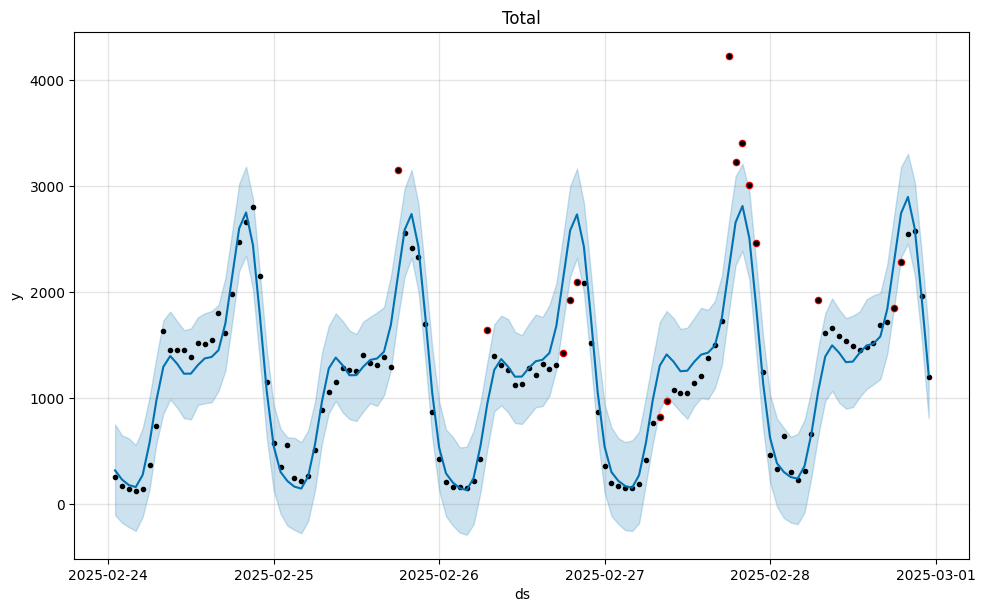

<Figure size 3000x2000 with 0 Axes>

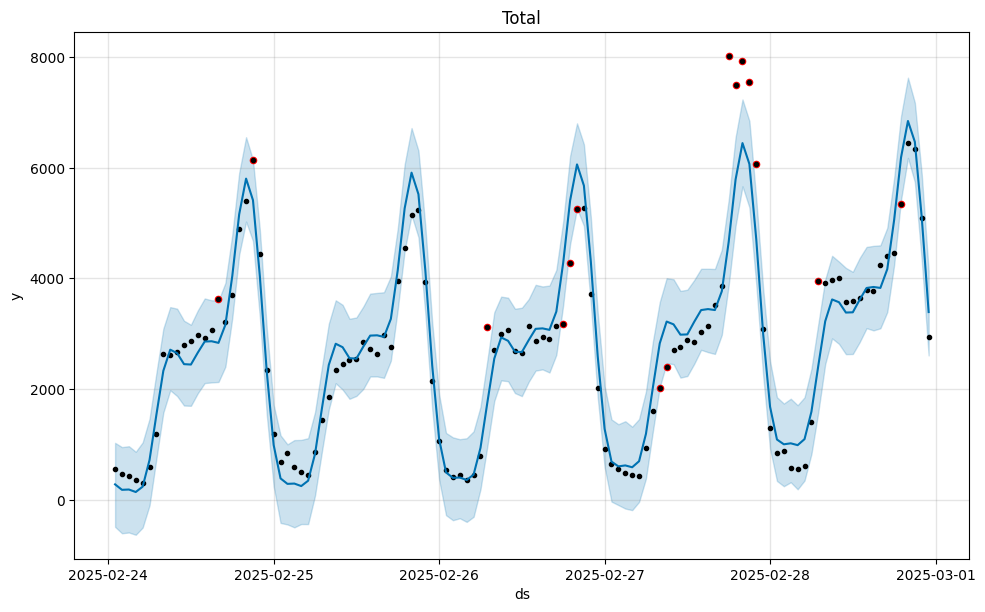

<Figure size 3000x2000 with 0 Axes>

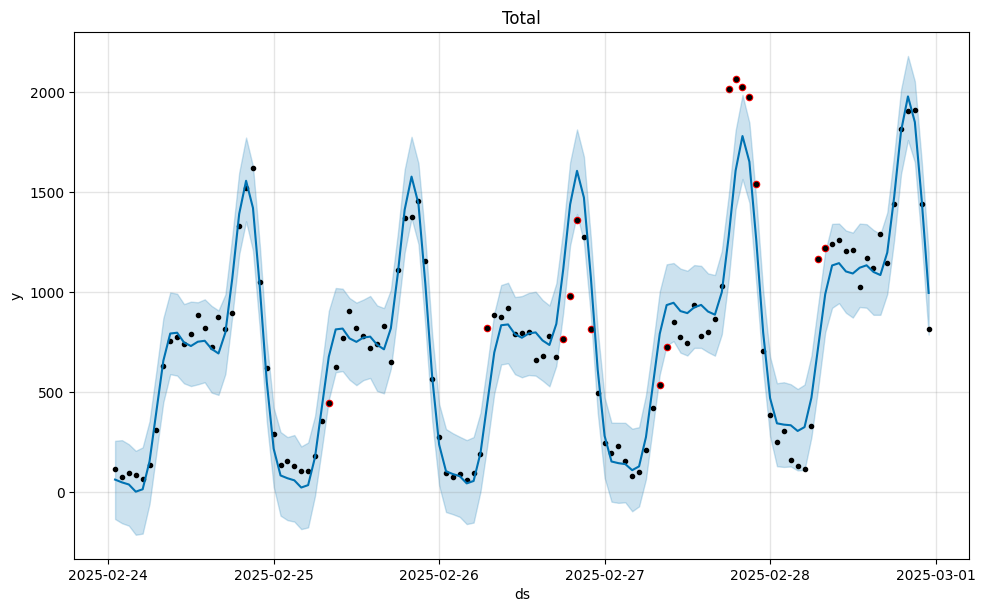

<Figure size 3000x2000 with 0 Axes>

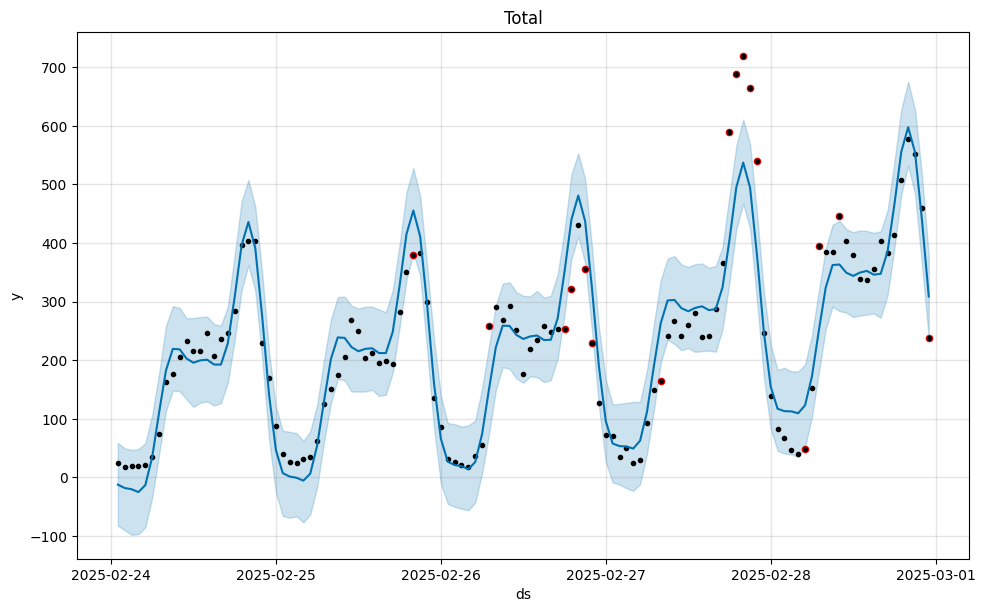

<Figure size 3000x2000 with 0 Axes>

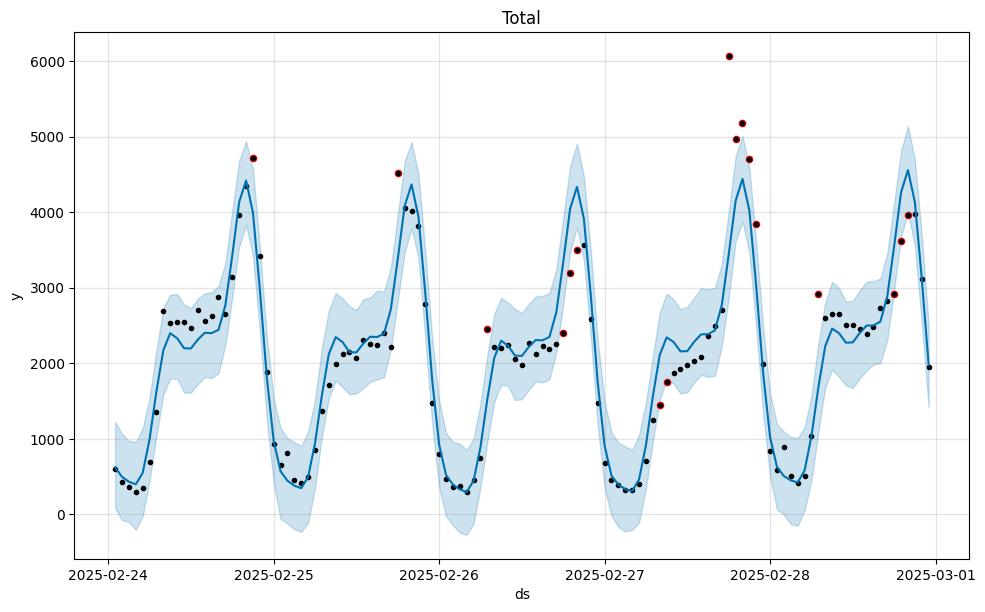

<Figure size 3000x2000 with 0 Axes>

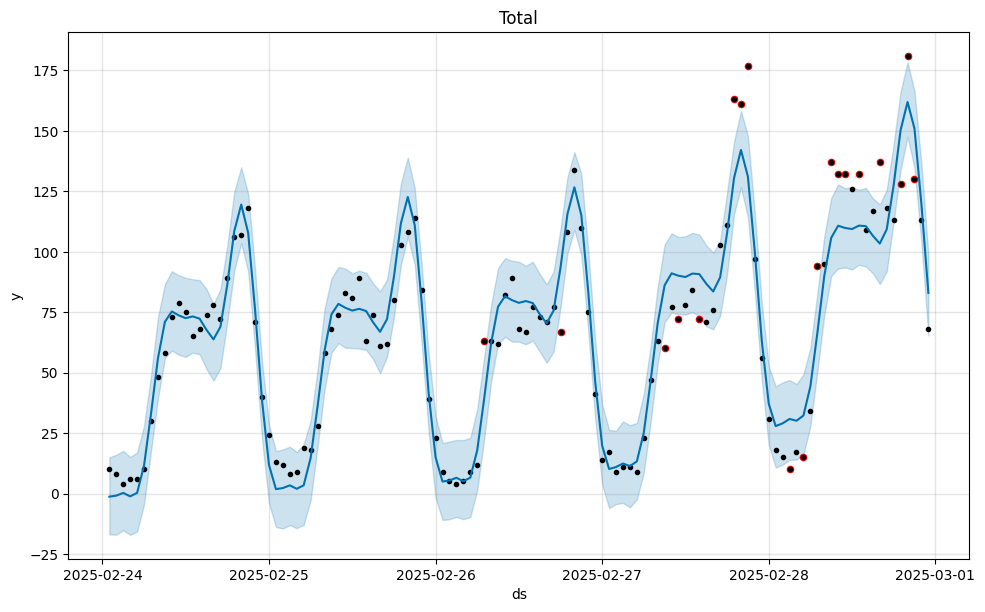

<Figure size 3000x2000 with 0 Axes>

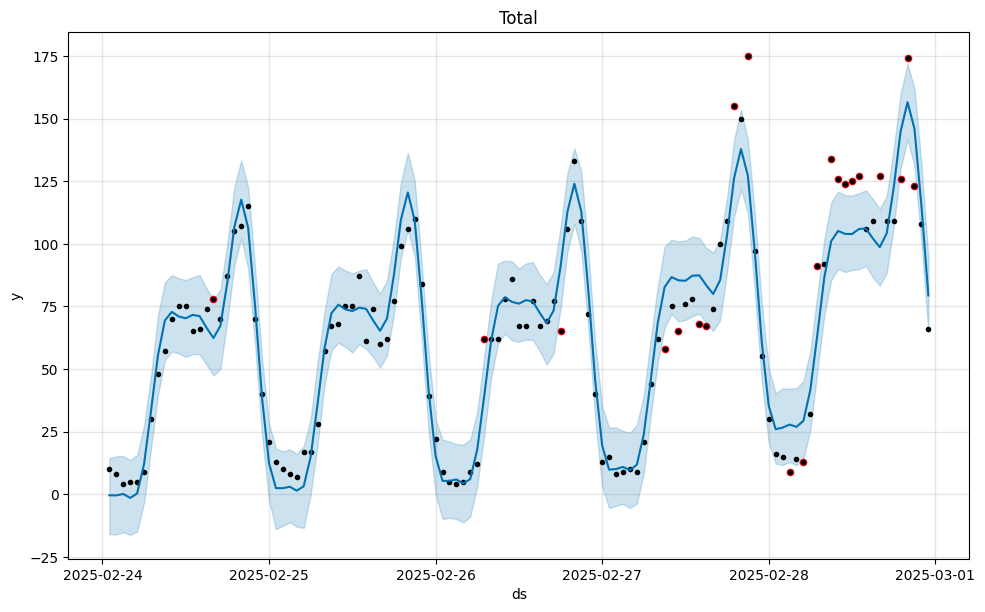

In [80]:
landing_page_viewers_top_level = prophet_model(landing_page_by_source, 'Total')
product_viewers_top_level = prophet_model(product_viewers, 'Total')
added_to_cart_top_level = prophet_model(added_to_cart, 'Total')
checkout_started_top_level = prophet_model(checkout_started, 'Total')
visitors_top_level = prophet_model(visitors, 'Total')
orders_top_level = prophet_model(orders, 'Total')
buyers_top_level = prophet_model(buyers, 'Total')
visitors_top_level

In [72]:
# Create a DataFrame with all hours and anomalies
all_hours = pd.date_range(start='2025-02-24 01:00:00', end='2025-02-28 23:00:00', freq='H')
anomaly_df = pd.DataFrame({'hour': all_hours})

# Add anomaly information from each model
models = {
    'landing_page_viewers': landing_page_viewers_top_level,
    'product_viewers': product_viewers_top_level,
    'added_to_cart': added_to_cart_top_level,
    'checkout_started': checkout_started_top_level,
    'visitors': visitors_top_level,
    'orders': orders_top_level,
    'buyers': buyers_top_level
}

# For each model, add a column indicating if there was an anomaly
for model_name, model_data in models.items():
    # Ensure the data length matches the DataFrame length
    if len(model_data['is_anomaly']) < len(anomaly_df):
        # Pad with zeros (assuming no anomaly) for the missing values
        padded_data = np.pad(model_data['is_anomaly'], (0, len(anomaly_df) - len(model_data['is_anomaly'])), 
                           mode='constant', constant_values=0)
        anomaly_df[f'{model_name}_anomaly'] = padded_data
    else:
        anomaly_df[f'{model_name}_anomaly'] = model_data['is_anomaly'].values

# Create a single column with list of event names that had anomalies at each hour
anomaly_df['event_names'] = anomaly_df.apply(
    lambda row: [metric for metric in models.keys() if row[f'{metric}_anomaly'] == 1],
    axis=1
)

# Drop the individual anomaly columns since we only need the event_names
anomaly_df = anomaly_df[['hour', 'event_names']]

# Display the first few rows of the combined DataFrame
anomaly_df

/var/folders/tt/90qp537n7n542b_rty4fd5lh0000gn/T/ipykernel_4738/599272217.py:2: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.



hour                                        event_names
0   2025-02-24 01:00:00                                                 []
1   2025-02-24 02:00:00                                                 []
2   2025-02-24 03:00:00                                                 []
3   2025-02-24 04:00:00                                                 []
4   2025-02-24 05:00:00                                                 []
..                  ...                                                ...
114 2025-02-28 19:00:00  [landing_page_viewers, product_viewers, visito...
115 2025-02-28 20:00:00                         [visitors, orders, buyers]
116 2025-02-28 21:00:00                                   [orders, buyers]
117 2025-02-28 22:00:00                                                 []
118 2025-02-28 23:00:00                                                 []

[119 rows x 2 columns]

In [47]:

import plotly.express as px

# Create a Plotly figure for total visitors
fig = px.line(visitors_top_level, x='ds', y='y',
              title="Total Visitors Over Time with Anomalies",
              labels={"y": "Number of Visitors", "ds": "Time"})

# Add highlighted regions for hours with anomalies
for idx, row in anomaly_df.iterrows():
    if row['event_names']:  # If there are any anomalies in this hour
        fig.add_vrect(x0=row['hour'] - pd.Timedelta(hours=0.5), 
                     x1=row['hour'] + pd.Timedelta(hours=0.5),
                     fillcolor="red", 
                     opacity=0.3, 
                     line_width=0)

# Update layout for better visualization
fig.update_layout(
    xaxis_title="Time",
    yaxis_title="Number of Visitors",
    hovermode="x unified",
    showlegend=False
)

# Update hover template to show anomaly information
fig.update_traces(
    hovertemplate="<b>Time:</b> %{x}<br>" +
                  "<b>Visitors:</b> %{y}<br>" +
                  "<b>Anomalies:</b> %{customdata}<extra></extra>",
    customdata=anomaly_df['event_names']
)

# Show the figure
fig.show()

In [73]:
# Check lengths of each model's data
print("Length of all_hours:", len(all_hours))
for model_name, model_data in models.items():
    print(f"Length of {model_name}:", len(model_data['is_anomaly']))

Length of all_hours: 119
Length of landing_page_viewers: 119
Length of product_viewers: 119
Length of added_to_cart: 119
Length of checkout_started: 119
Length of visitors: 119
Length of orders: 119
Length of buyers: 119


In [74]:
def anomaly_contribution(site_visits_top_level,site_visits_bottom_level, dimension_list):
  site_visits_top_level_new = site_visits_top_level.copy()
  site_visits_top_level_new["pred added"] = 0
  site_visits_top_level_new["diff added"] = 0
  site_visits_top_level_new["diff sign added"] = 0

  for dimension in dimension_list:
    data_curr = prophet_model(site_visits_bottom_level, dimension)
    site_visits_top_level_new["pred "+dimension] = data_curr['yhat']
    site_visits_top_level_new["diff "+dimension] = data_curr['diff']
    site_visits_top_level_new['percent_diff ' + dimension] = data_curr['percent_diff']


    #Aggregated anomaly weights by dimension for verification with total anomaly weight found at top level
    site_visits_top_level_new["pred added"] += site_visits_top_level_new["pred "+dimension]
    site_visits_top_level_new["diff added"] += site_visits_top_level_new["diff "+dimension]


  for dimension in dimension_list:
    site_visits_top_level_new["perc diff "+dimension] = site_visits_top_level_new["diff "+dimension]/site_visits_top_level_new["diff added"]
    print(dimension + " added!")
  return site_visits_top_level_new

In [75]:
def anomaly_percents(site_visits_top_levell,site_visits_bottom_level, geo_list):
  site_visits_top_level_new = site_visits_top_levell.copy()
  for geo in geo_list:
    data_curr = prophet_model(site_visits_bottom_level, geo)
    # site_visits_top_level_new["diff "+geo] = data_curr['diff']
    site_visits_top_level_new["percent_diff "+geo] = data_curr['percent_diff']
  return site_visits_top_level_new

08:55:43 - cmdstanpy - INFO - Chain [1] start processing


08:55:43 - cmdstanpy - INFO - Chain [1] done processing
08:55:43 - cmdstanpy - INFO - Chain [1] start processing
08:55:43 - cmdstanpy - INFO - Chain [1] done processing
08:55:44 - cmdstanpy - INFO - Chain [1] start processing
08:55:44 - cmdstanpy - INFO - Chain [1] done processing
08:55:44 - cmdstanpy - INFO - Chain [1] start processing
08:55:44 - cmdstanpy - INFO - Chain [1] done processing
08:55:44 - cmdstanpy - INFO - Chain [1] start processing
08:55:44 - cmdstanpy - INFO - Chain [1] done processing
08:55:44 - cmdstanpy - INFO - Chain [1] start processing
08:55:44 - cmdstanpy - INFO - Chain [1] done processing


ds  yhat_lower  yhat_upper        yhat    y  is_anomaly  \
43 2025-02-25 20:00:00  106.336065  136.397890  120.477890  106           1   
54 2025-02-26 07:00:00   23.800333   54.415152   38.981585   62           1   
65 2025-02-26 18:00:00   75.844576  105.937275   90.776580   65           1   
80 2025-02-27 09:00:00   67.212206   97.962629   82.690520   58           1   
82 2025-02-27 11:00:00   70.694721   99.574934   85.376582   65           1   

         diff  percent_diff  percent_diff Global  percent_diff US  
43  14.477890      0.136584             0.134110         0.436260  
54  23.018415      0.371265             0.385746              NaN  
65  25.776580      0.396563             0.381138         2.100457  
80  24.690520      0.425699             0.501118         0.524878  
82  20.376582      0.313486             0.330265         0.126627

<Figure size 3000x2000 with 0 Axes>

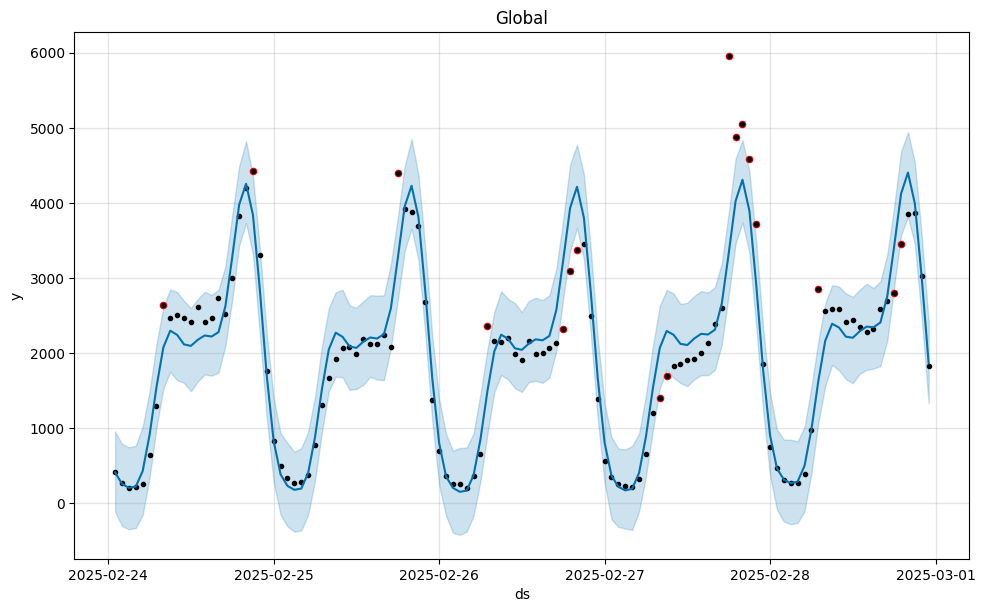

<Figure size 3000x2000 with 0 Axes>

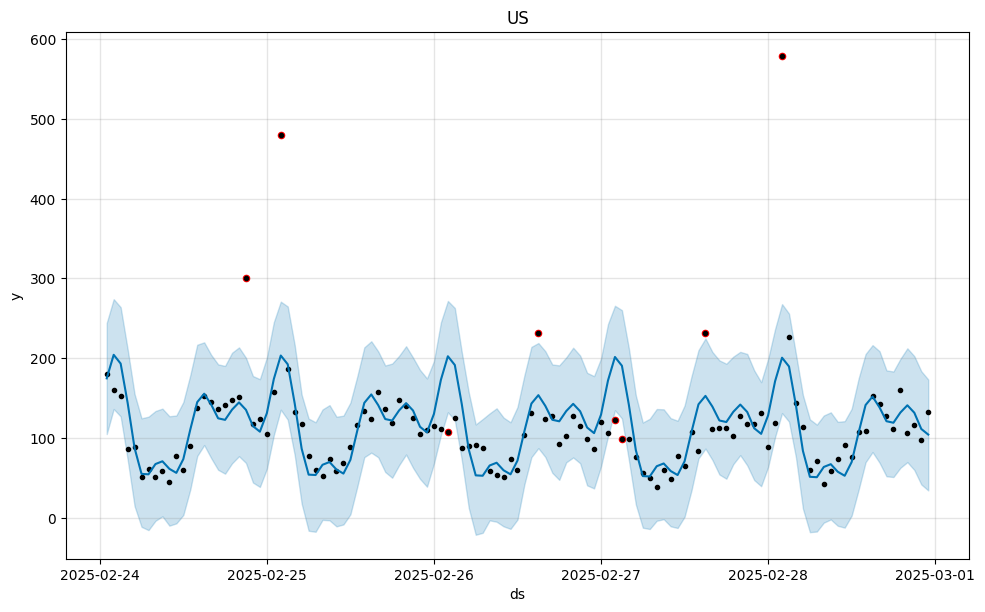

<Figure size 3000x2000 with 0 Axes>

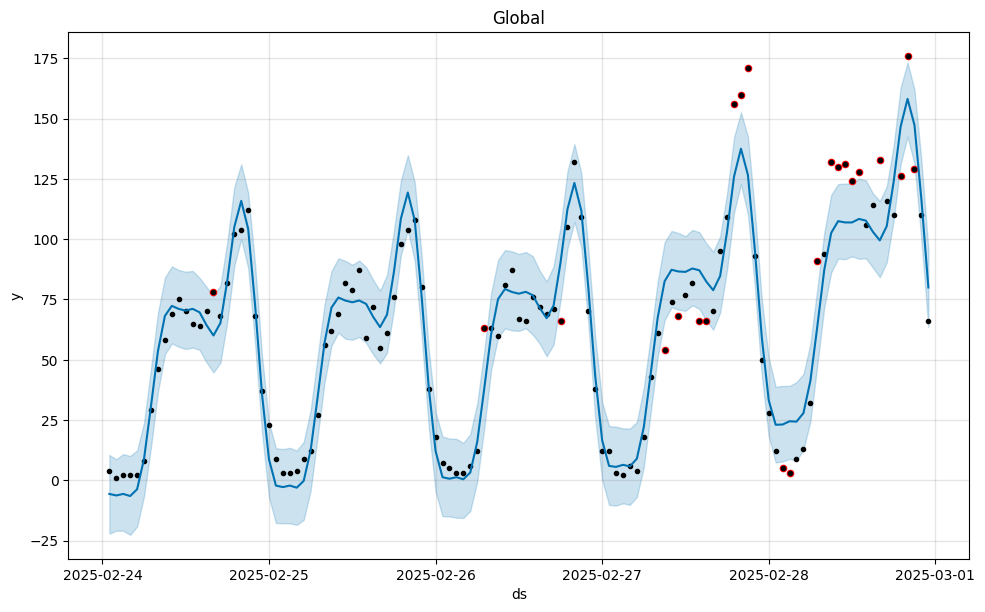

<Figure size 3000x2000 with 0 Axes>

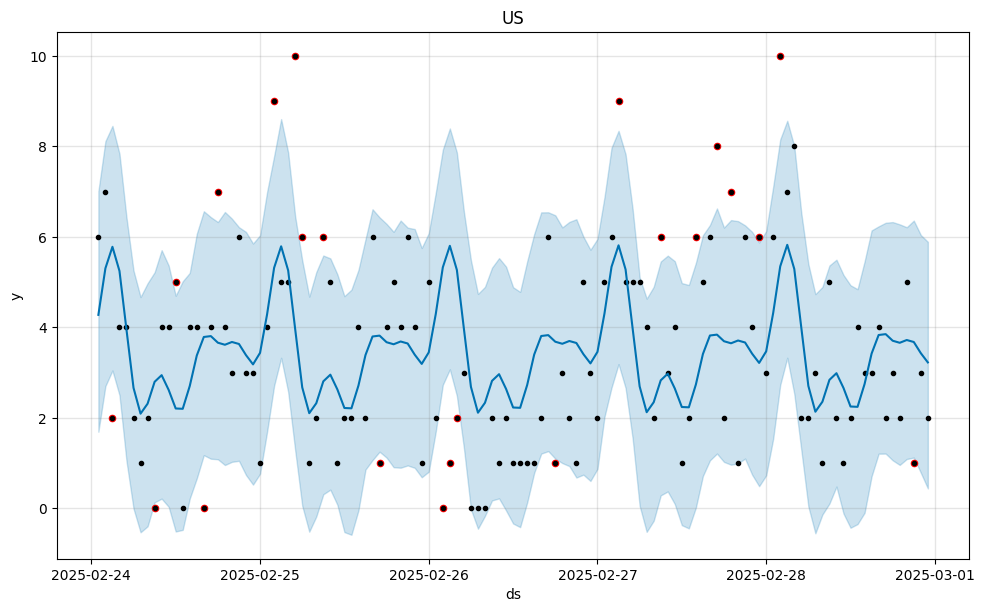

<Figure size 3000x2000 with 0 Axes>

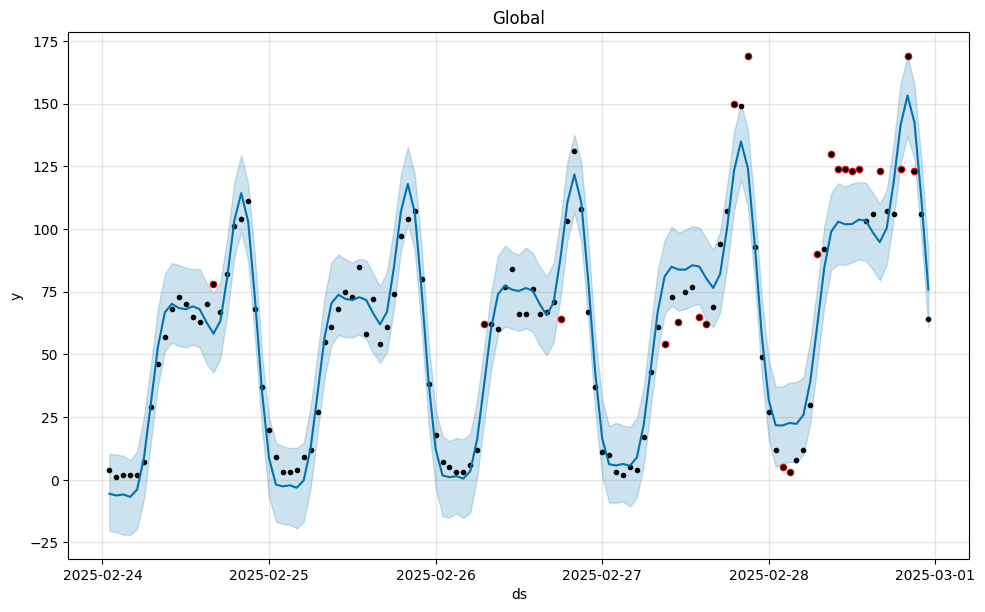

<Figure size 3000x2000 with 0 Axes>

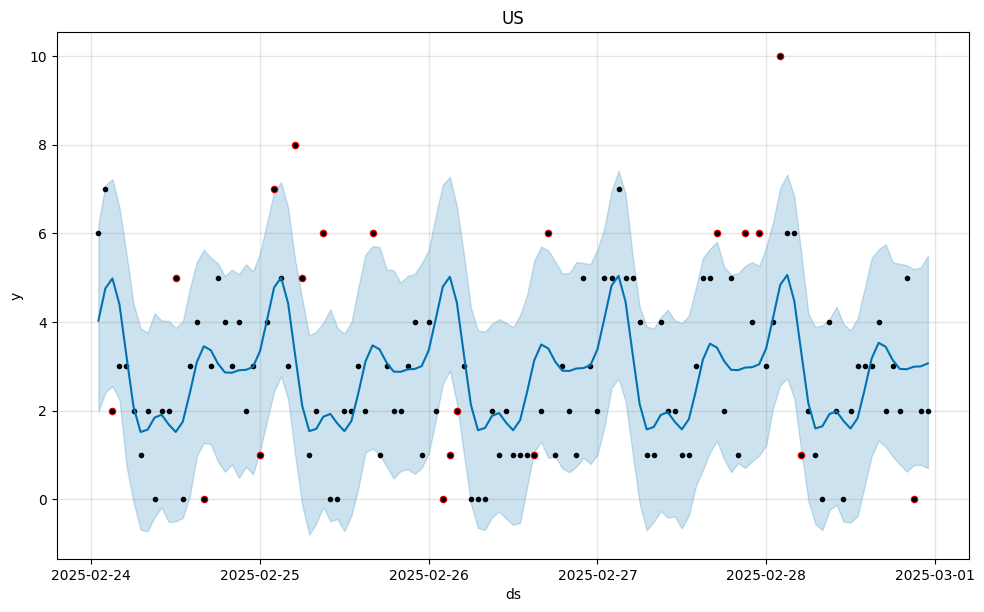

In [76]:
geo_list = ["Global", "US"]
visitors_contributions = anomaly_percents(visitors_top_level,visitors_by_geography, geo_list)
visitors_geo_contributions = visitors_contributions[visitors_contributions["is_anomaly"] == 1]
orders_contributions = anomaly_percents(orders_top_level,orders_by_geography, geo_list)
orders_geo_contributions = orders_contributions[orders_contributions["is_anomaly"] == 1]
buyers_contributions = anomaly_percents(buyers_top_level,buyers_by_geography, geo_list)
buyers_geo_contributions = buyers_contributions[buyers_contributions["is_anomaly"] == 1]
buyers_geo_contributions.head()

01:30:35 - cmdstanpy - INFO - Chain [1] start processing
01:30:35 - cmdstanpy - INFO - Chain [1] done processing
01:30:35 - cmdstanpy - INFO - Chain [1] start processing
01:30:35 - cmdstanpy - INFO - Chain [1] done processing
01:30:35 - cmdstanpy - INFO - Chain [1] start processing
01:30:35 - cmdstanpy - INFO - Chain [1] done processing
01:30:35 - cmdstanpy - INFO - Chain [1] start processing
01:30:35 - cmdstanpy - INFO - Chain [1] done processing
01:30:35 - cmdstanpy - INFO - Chain [1] start processing
01:30:35 - cmdstanpy - INFO - Chain [1] done processing
01:30:35 - cmdstanpy - INFO - Chain [1] start processing
01:30:35 - cmdstanpy - INFO - Chain [1] done processing
01:30:35 - cmdstanpy - INFO - Chain [1] start processing
01:30:35 - cmdstanpy - INFO - Chain [1] done processing
01:30:35 - cmdstanpy - INFO - Chain [1] start processing
01:30:35 - cmdstanpy - INFO - Chain [1] done processing
01:30:35 - cmdstanpy - INFO - Chain [1] start processing
01:30:35 - cmdstanpy - INFO - Chain [1]

Android added!
Linux added!
macOS added!
Other added!
Windows added!
iOS added!


01:30:36 - cmdstanpy - INFO - Chain [1] start processing
01:30:36 - cmdstanpy - INFO - Chain [1] done processing
01:30:36 - cmdstanpy - INFO - Chain [1] start processing
01:30:36 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/tt/90qp537n7n542b_rty4fd5lh0000gn/T/ipykernel_4738/2191977413.py:38: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.

01:30:36 - cmdstanpy - INFO - Chain [1] start processing
01:30:36 - cmdstanpy - INFO - Chain [1] done processing
01:30:36 - cmdstanpy - INFO - Chain [1] start processing
01:30:36 - cmdstanpy - INFO - Chain [1] done processing
01:30:36 - cmdstanpy - INFO - Chain [1] start processing
01:30:36 - cmdstanpy - INFO - Chain [1] done processing
01:30:36 - cmdstanpy - INFO - Chain [1

Android added!
Linux added!
macOS added!
Other added!
Windows added!
iOS added!


01:30:36 - cmdstanpy - INFO - Chain [1] start processing
01:30:36 - cmdstanpy - INFO - Chain [1] done processing
01:30:36 - cmdstanpy - INFO - Chain [1] start processing
01:30:36 - cmdstanpy - INFO - Chain [1] done processing
01:30:36 - cmdstanpy - INFO - Chain [1] start processing
01:30:36 - cmdstanpy - INFO - Chain [1] done processing


Android added!
Linux added!
macOS added!
Other added!
Windows added!
iOS added!


ds  yhat_lower  yhat_upper       yhat   y  is_anomaly  \
15 2025-02-24 16:00:00   46.281477   77.175692  62.341681  78           1   
54 2025-02-26 07:00:00   24.111489   55.363793  38.981585  62           1   
65 2025-02-26 18:00:00   75.726089  106.310240  90.776580  65           1   
80 2025-02-27 09:00:00   67.134195   96.744659  82.690520  58           1   
82 2025-02-27 11:00:00   71.241918  100.847543  85.376582  65           1   

         diff  percent_diff  pred added  diff added  ...  \
15  15.658319      0.200748   61.107249   18.599125  ...   
54  23.018415      0.371265   39.993382   28.299119  ...   
65  25.776580      0.396563   92.214285   27.214285  ...   
80  24.690520      0.425699   84.082091   30.027862  ...   
82  20.376582      0.313486   86.614979   21.671763  ...   

    percent_diff Windows   pred iOS   diff iOS  percent_diff iOS  \
15              0.117789  40.502096  15.497904          0.276748   
54              2.111515  29.046540  23.953460          0.451952   
65              0.303402  66.196581  18.196581          0.379095   
80              0.131994  56.155811  22.155811          0.651641   
82              0.279790  55.635324  15.635324          0.390883   

    perc diff Android  perc diff Linux  perc diff macOS  perc diff Other  \
15           0.100340         0.003049         0.020527         0.004825   
54           0.041993         0.000390         0.036044         0.000520   
65           0.234071         0.000920         0.059226         0.003697   
80           0.192500         0.003516         0.008557         0.000440   
82           0.072180         0.006555         0.069391         0.001310   

    perc diff Windows  perc diff iOS  
15           0.037998       0.833260  
54           0.074614       0.846438  
65           0.033446       0.668641  
80           0.057145       0.737842  
82           0.129104       0.721461  

[5 rows x 35 columns]

<Figure size 3000x2000 with 0 Axes>

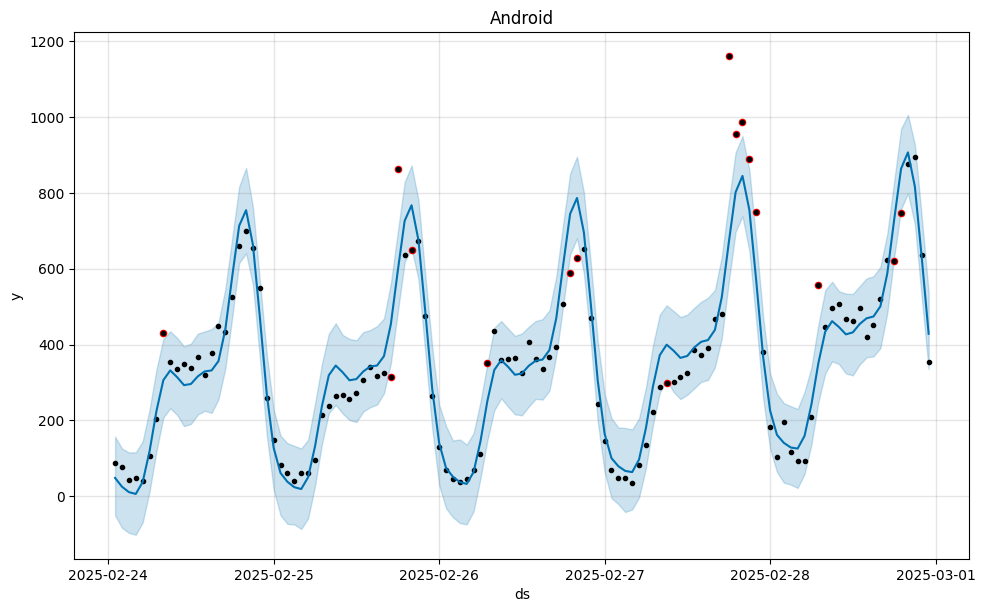

<Figure size 3000x2000 with 0 Axes>

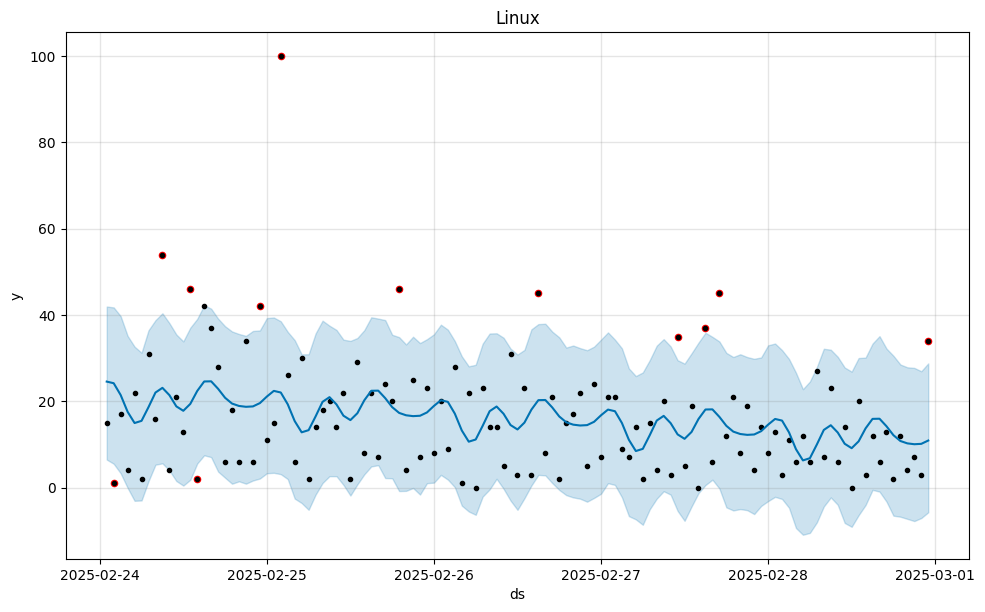

<Figure size 3000x2000 with 0 Axes>

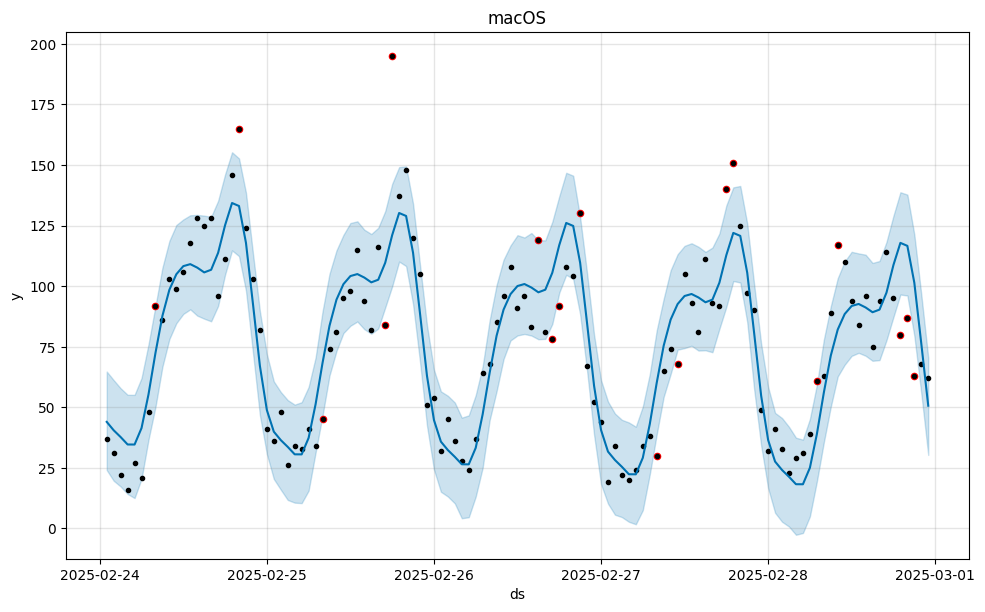

<Figure size 3000x2000 with 0 Axes>

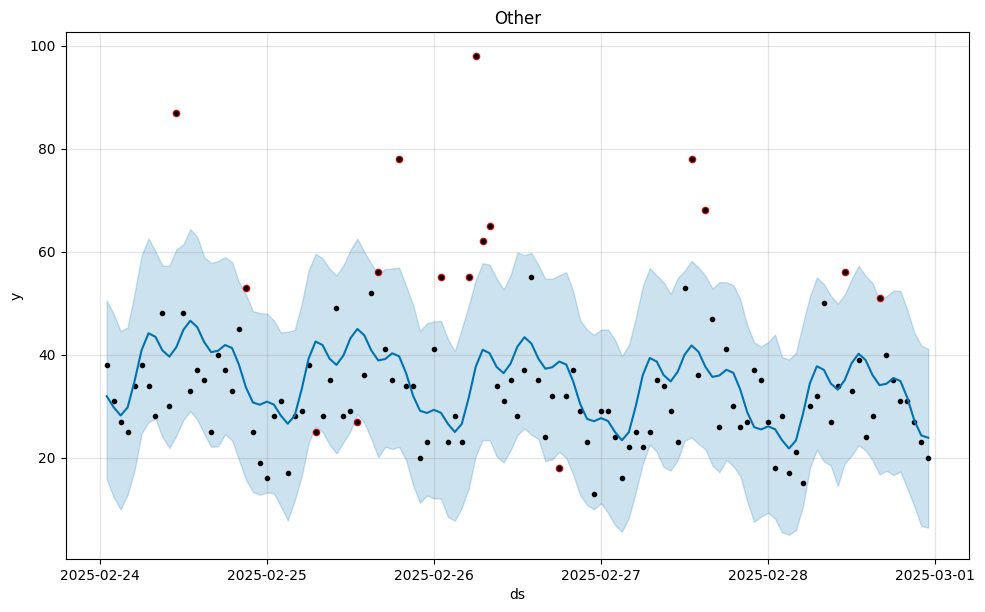

<Figure size 3000x2000 with 0 Axes>

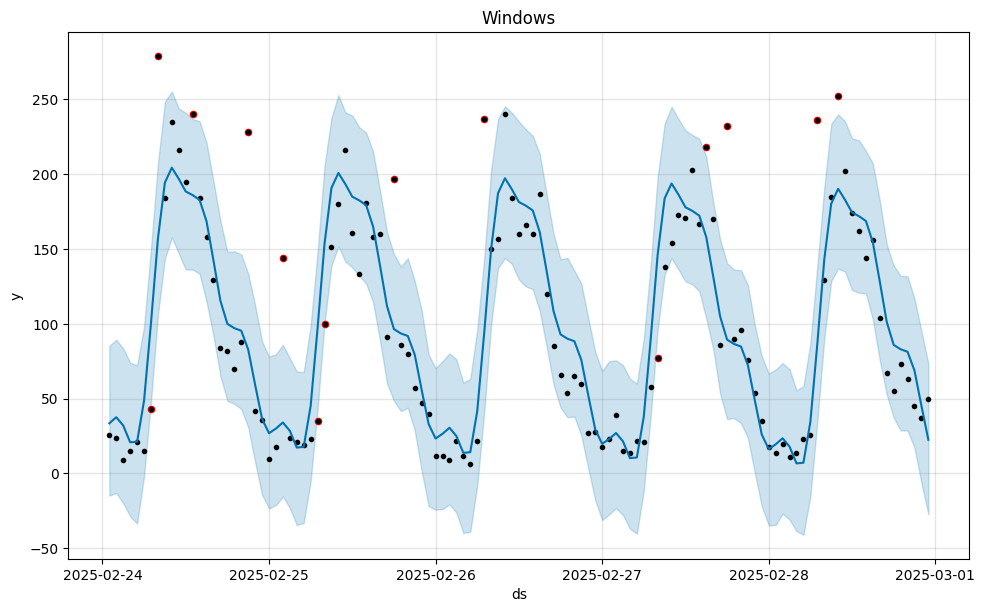

<Figure size 3000x2000 with 0 Axes>

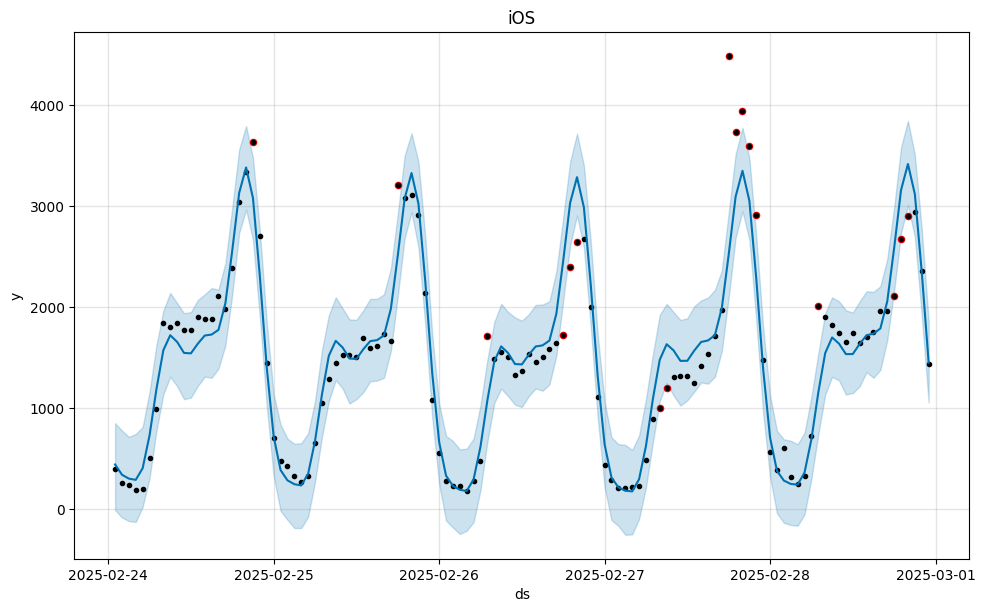

<Figure size 3000x2000 with 0 Axes>

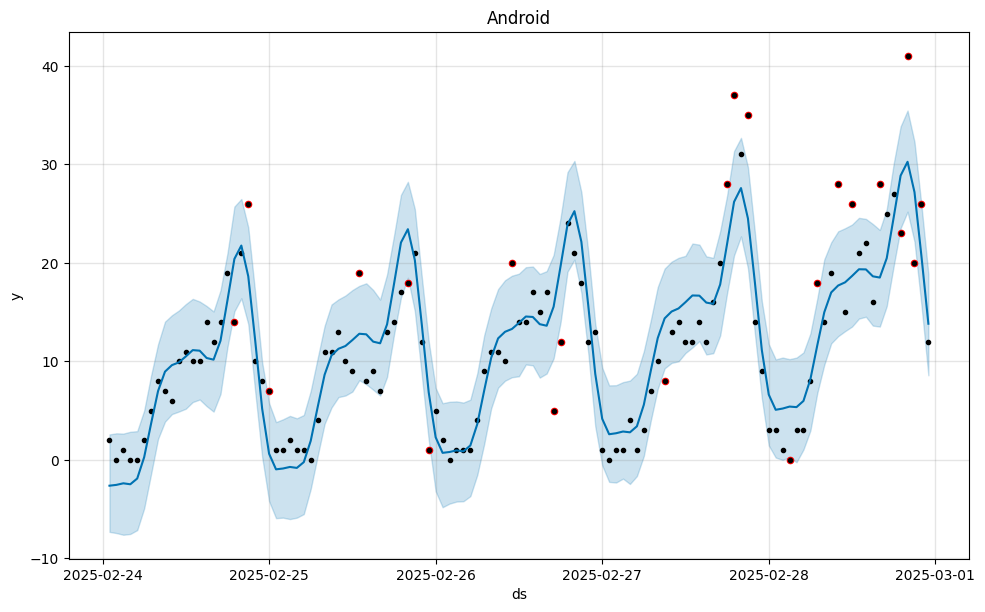

<Figure size 3000x2000 with 0 Axes>

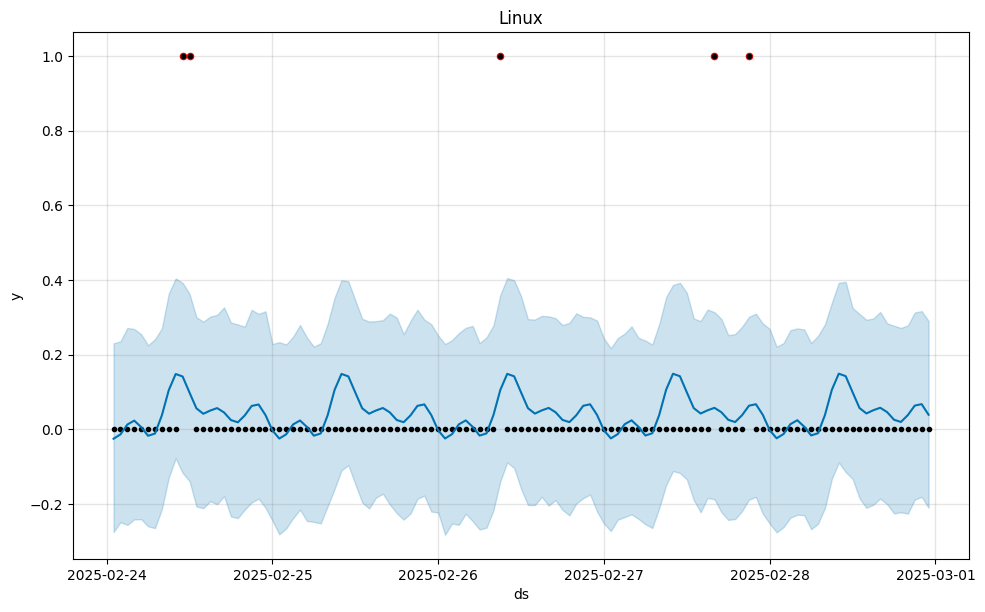

<Figure size 3000x2000 with 0 Axes>

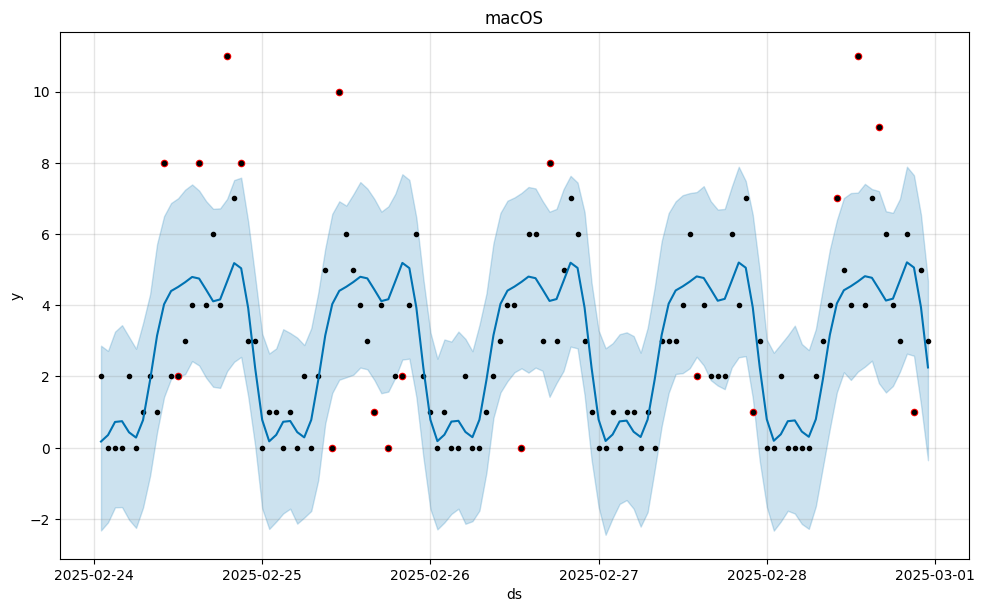

<Figure size 3000x2000 with 0 Axes>

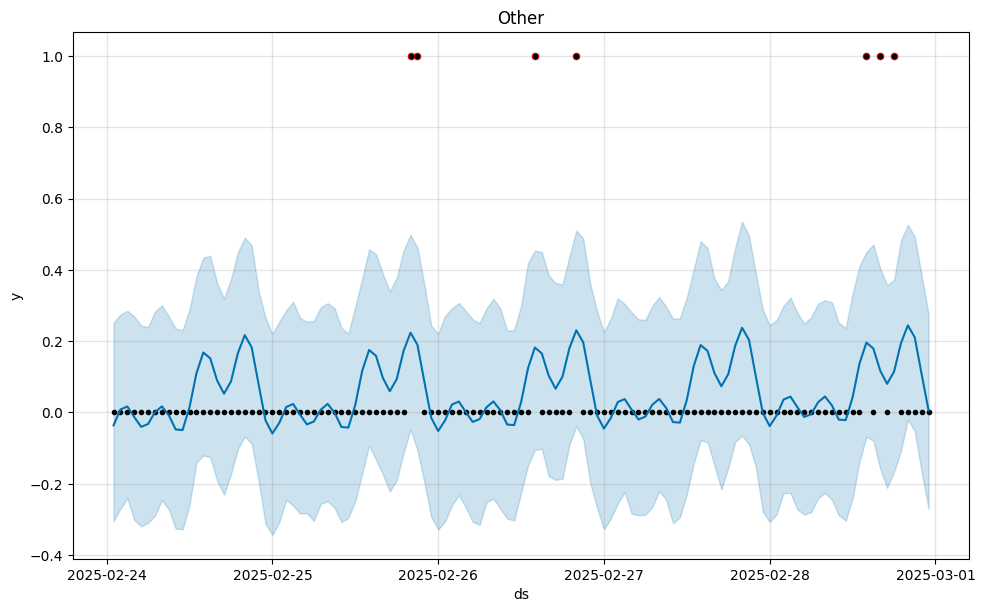

<Figure size 3000x2000 with 0 Axes>

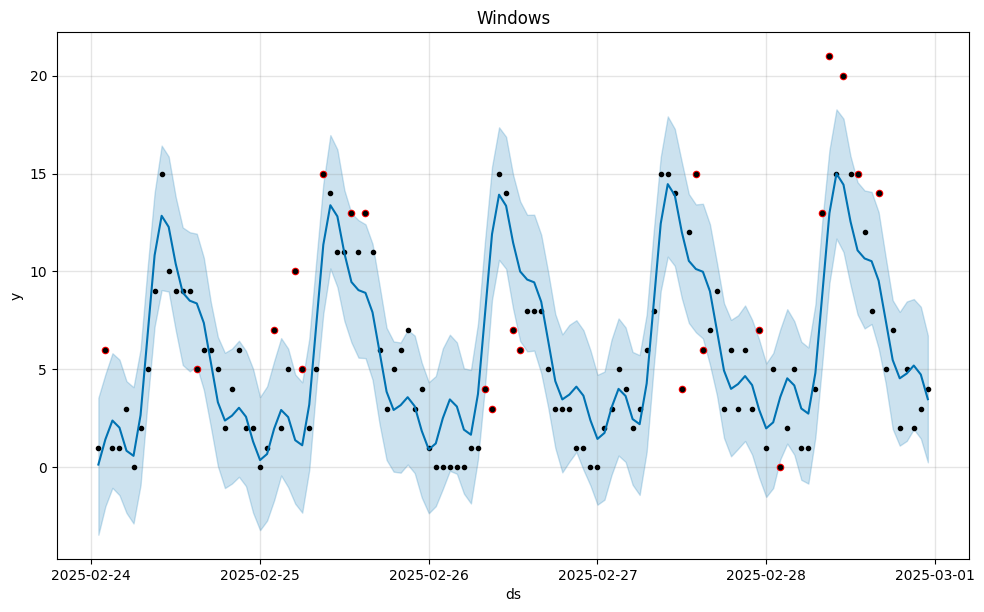

<Figure size 3000x2000 with 0 Axes>

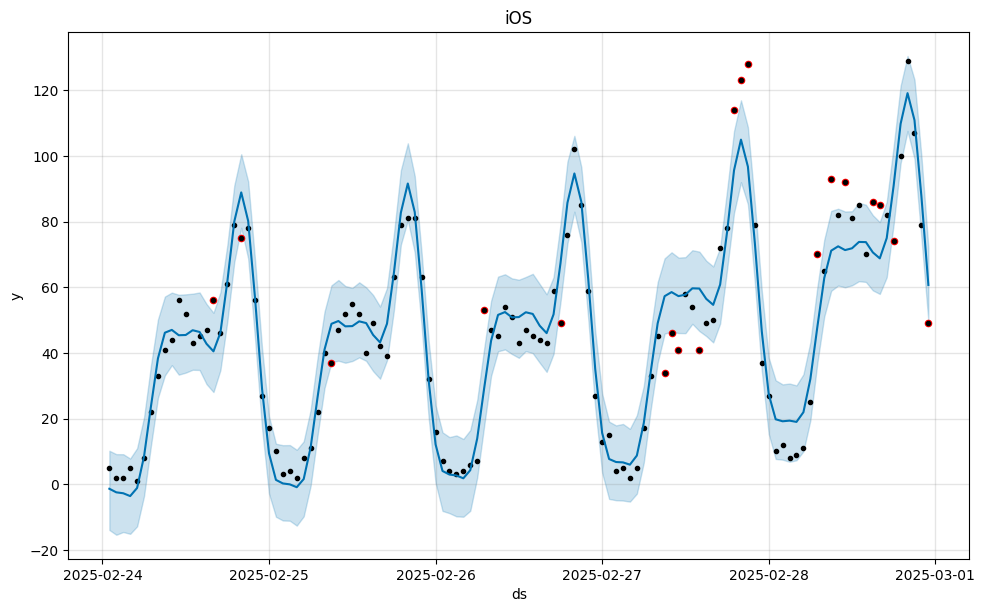

<Figure size 3000x2000 with 0 Axes>

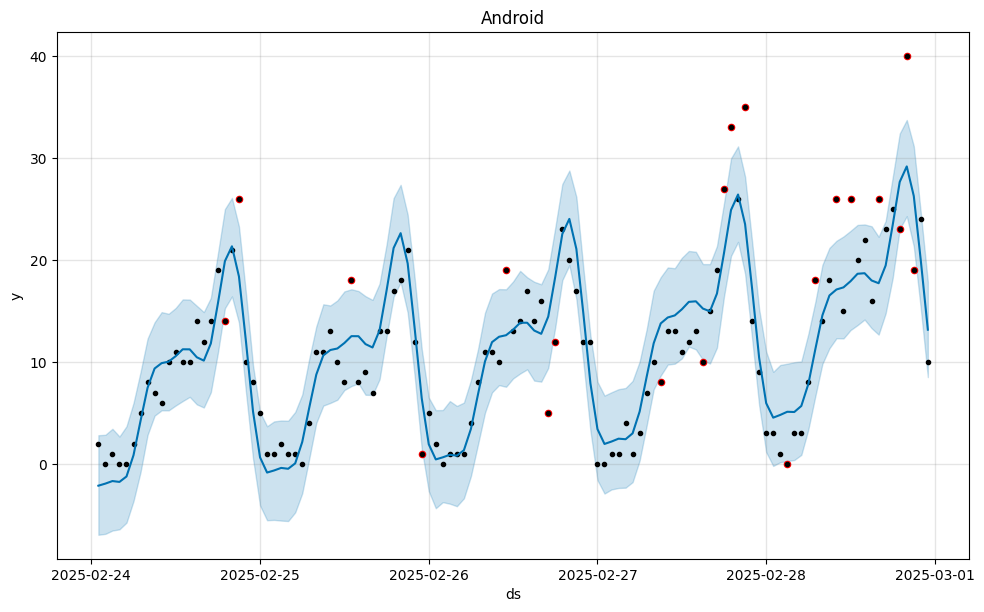

<Figure size 3000x2000 with 0 Axes>

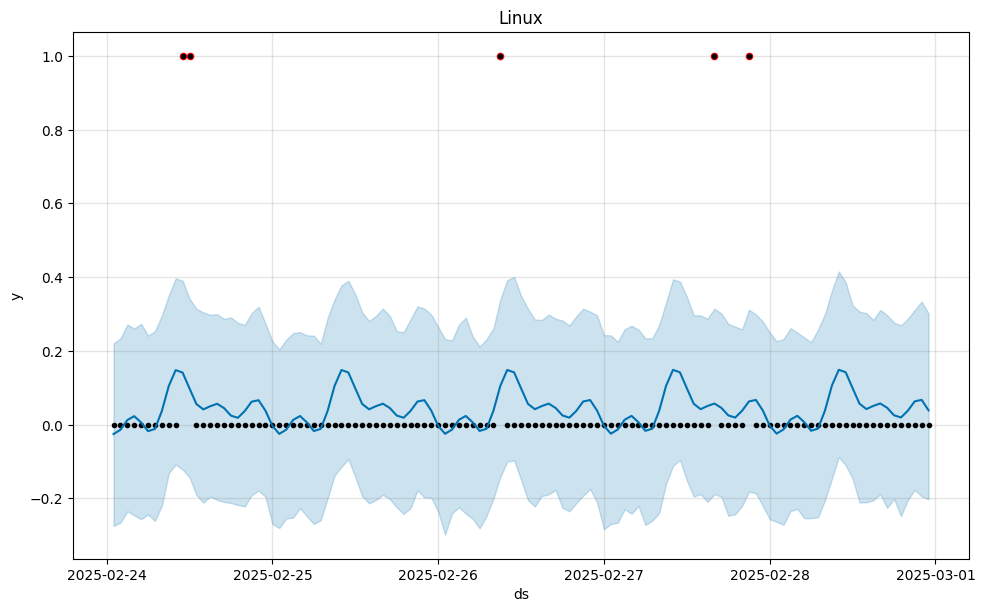

<Figure size 3000x2000 with 0 Axes>

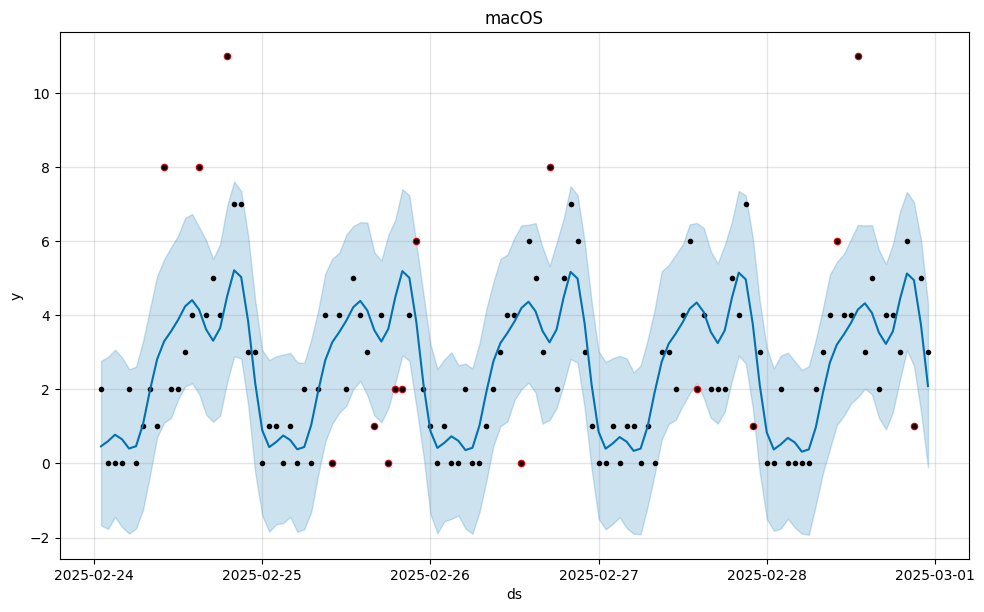

<Figure size 3000x2000 with 0 Axes>

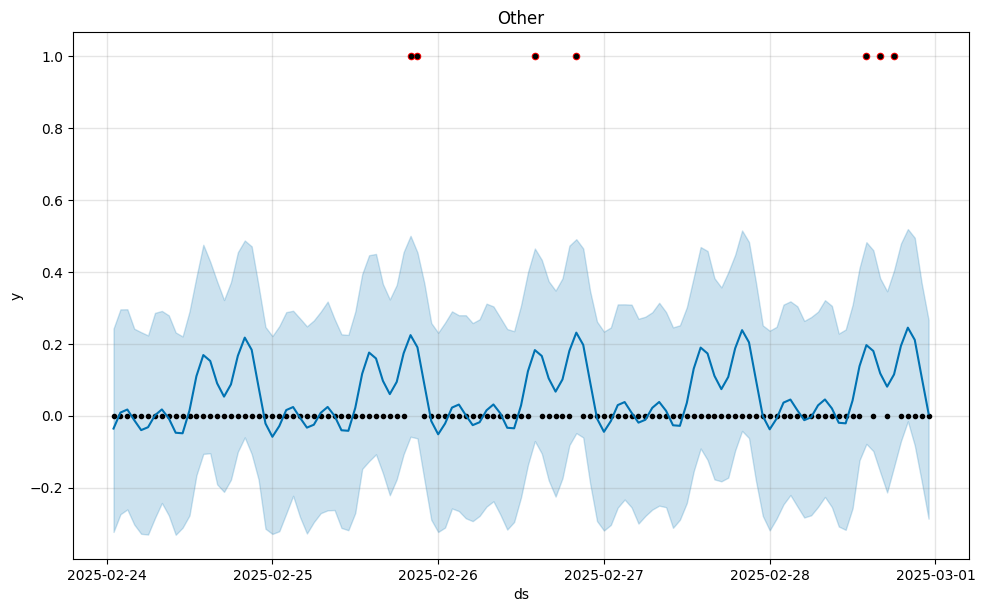

<Figure size 3000x2000 with 0 Axes>

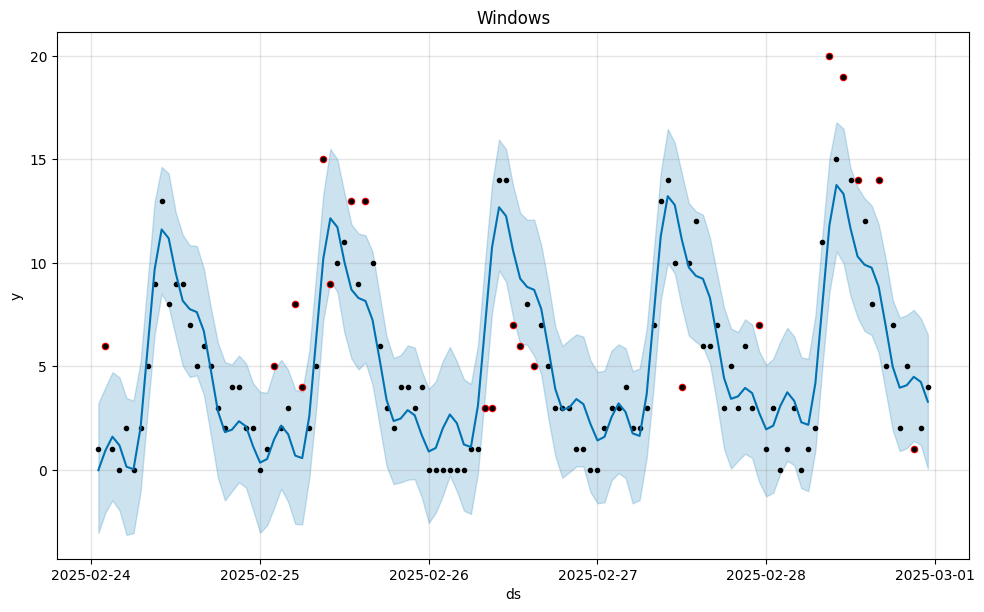

<Figure size 3000x2000 with 0 Axes>

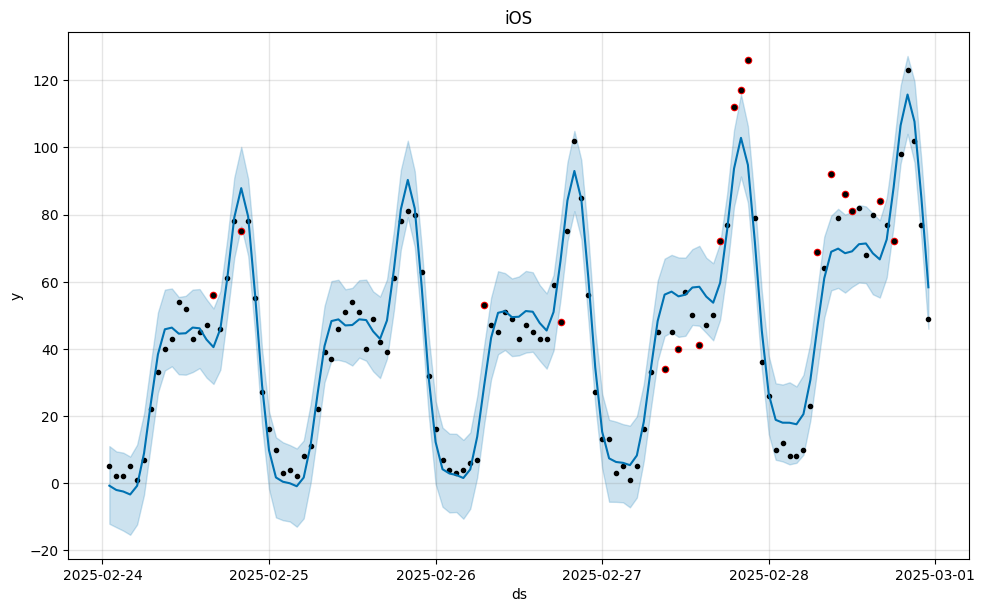

In [52]:
devices = ["Android",	"Linux", "macOS",	"Other",	"Windows",	"iOS"]
visitors_contribution_dev = anomaly_contribution(visitors_top_level,visitors_by_device, devices)
visitors_contributions_device = visitors_contribution_dev[visitors_contribution_dev["is_anomaly"] == 1]
orders_contribution_dev = anomaly_contribution(orders_top_level, orders_by_device, devices)
orders_contributions_device = orders_contribution_dev[orders_contribution_dev["is_anomaly"] == 1]
buyers_contribution_dev = anomaly_contribution(buyers_top_level, buyers_by_device, devices)
buyers_contributions_device = buyers_contribution_dev[buyers_contribution_dev["is_anomaly"] == 1]
buyers_contributions_device.head()

09:14:15 - cmdstanpy - INFO - Chain [1] start processing


09:14:15 - cmdstanpy - INFO - Chain [1] done processing
09:14:15 - cmdstanpy - INFO - Chain [1] start processing
09:14:15 - cmdstanpy - INFO - Chain [1] done processing
09:14:15 - cmdstanpy - INFO - Chain [1] start processing
09:14:15 - cmdstanpy - INFO - Chain [1] done processing
09:14:15 - cmdstanpy - INFO - Chain [1] start processing
09:14:15 - cmdstanpy - INFO - Chain [1] done processing
09:14:15 - cmdstanpy - INFO - Chain [1] start processing
09:14:15 - cmdstanpy - INFO - Chain [1] done processing


ds   yhat_lower   yhat_upper         yhat     y  \
41  2025-02-25 18:00:00  1742.477435  2560.218137  2139.124973  3149   
54  2025-02-26 07:00:00   520.680837  1338.704980   948.821022  1641   
65  2025-02-26 18:00:00  1723.467441  2533.047045  2130.573987  1427   
66  2025-02-26 19:00:00  2145.462788  2996.238934  2579.541717  1925   
67  2025-02-26 20:00:00  2320.797502  3162.187269  2731.568000  2090   
79  2025-02-27 08:00:00   886.731858  1715.506923  1303.682841   824   
80  2025-02-27 09:00:00  1020.874376  1819.396935  1409.869366   973   
89  2025-02-27 18:00:00  1797.281531  2640.798656  2206.153250  4227   
90  2025-02-27 19:00:00  2252.965724  3090.437697  2656.870334  3229   
91  2025-02-27 20:00:00  2386.271186  3209.674916  2810.645969  3402   
92  2025-02-27 21:00:00  2112.430736  2944.322515  2506.328639  3010   
93  2025-02-27 22:00:00  1417.455596  2269.525136  1849.169535  2466   
102 2025-02-28 07:00:00   645.998206  1475.413715  1069.954915  1925   
113 2025-02-28 18:00:00  1860.537529  2722.359969  2291.778936  1846   
114 2025-02-28 19:00:00  2327.213739  3179.547049  2742.496020  2285   

     is_anomaly         diff  percent_diff  percent_diff google  \
41            1  1009.875027      0.320697             0.017921   
54            1   692.178978      0.421803             0.172514   
65            1   703.573987      0.493044             0.229767   
66            1   654.541717      0.340022             0.165223   
67            1   641.568000      0.306970             0.046824   
79            1   479.682841      0.582139             0.198840   
80            1   436.869366      0.448992             0.146013   
89            1  2020.846750      0.478081             0.119205   
90            1   572.129666      0.177185             0.033048   
91            1   591.354031      0.173825             0.081275   
92            1   503.671361      0.167333             0.048717   
93            1   616.830465      0.250134             0.102111   
102           1   855.045085      0.444179             0.302674   
113           1   445.778936      0.241484             0.108132   
114           1   457.496020      0.200217             0.170220   

     percent_diff Klaviyo  percent_diff fbig  percent_diff rakuten  \
41               0.731770           0.096045              0.655976   
54               0.670405           0.176365              0.063033   
65               3.099577           0.155775              1.308918   
66               2.813240           0.042644              0.875668   
67               3.058675           0.152982              0.855774   
79               3.286907           0.198681              1.356431   
80               3.522021           0.225314              0.847980   
89               0.758677           0.006247              0.767471   
90               0.435030           0.040647              0.559137   
91               0.340995           0.130992              0.450163   
92               0.500394           0.073050              0.511185   
93               0.703195           0.155956              0.600207   
102              0.616974           0.162526              0.476558   
113              3.478816           0.004712              1.808599   
114              3.806497           0.076383              2.063613   

     percent_diff tiktok  
41              0.082209  
54              0.252257  
65              0.057407  
66              0.045199  
67              0.116619  
79              0.762247  
80              0.005804  
89              0.418742  
90              0.272898  
91              0.246858  
92              0.058958  
93              0.011631  
102             0.311674  
113             0.034556  
114             0.026185

<Figure size 3000x2000 with 0 Axes>

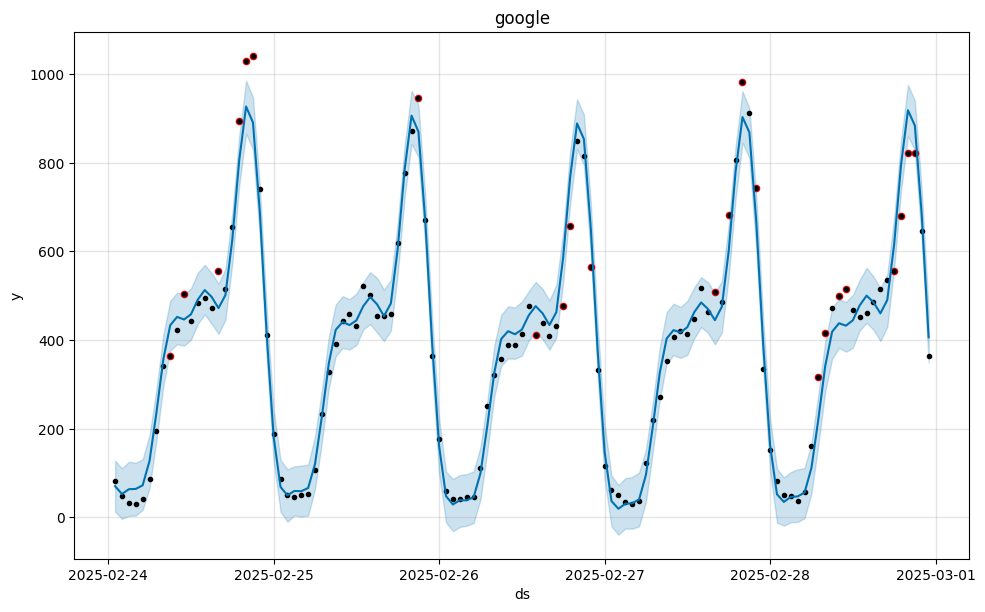

<Figure size 3000x2000 with 0 Axes>

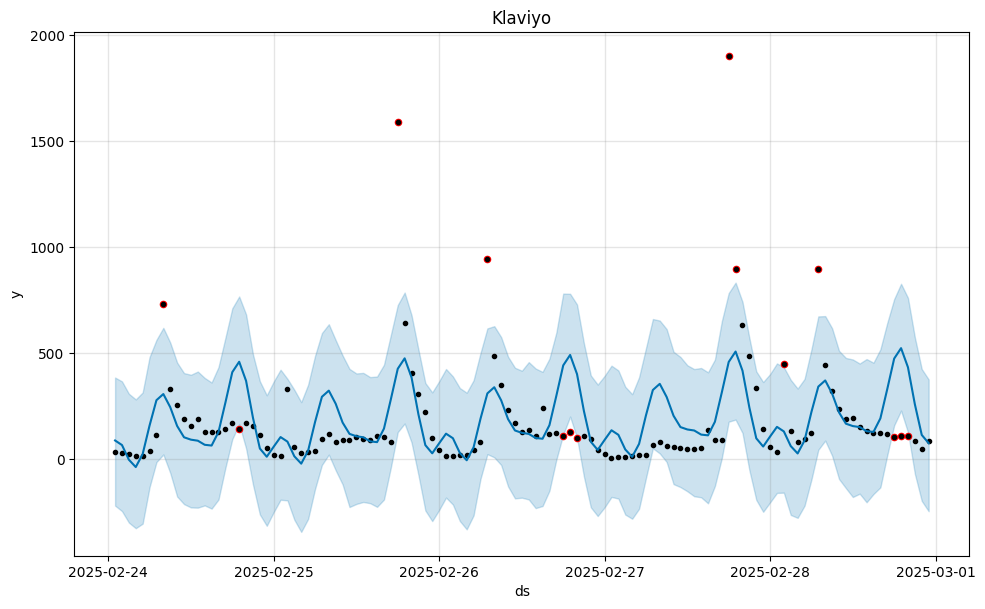

<Figure size 3000x2000 with 0 Axes>

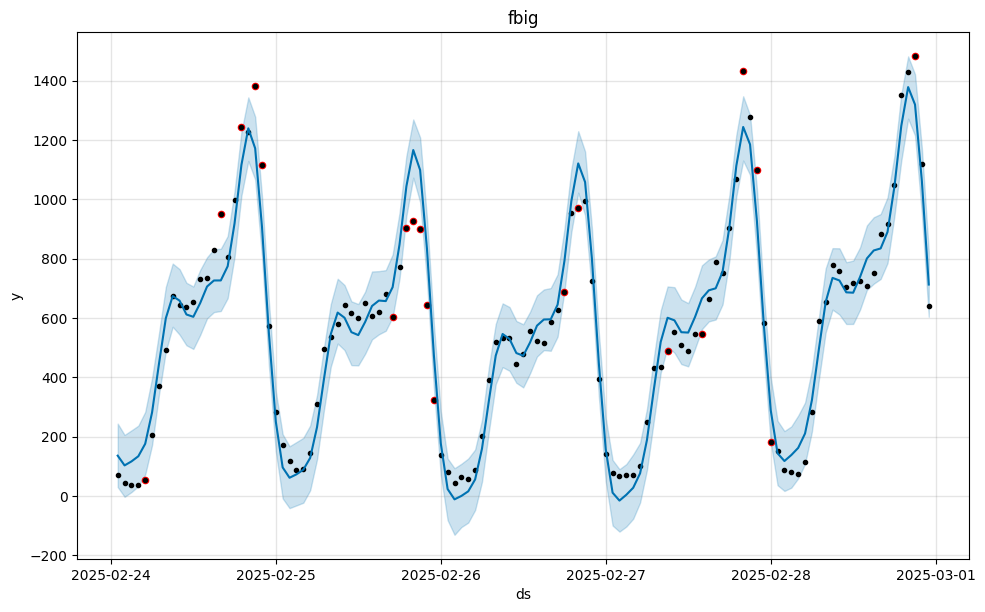

<Figure size 3000x2000 with 0 Axes>

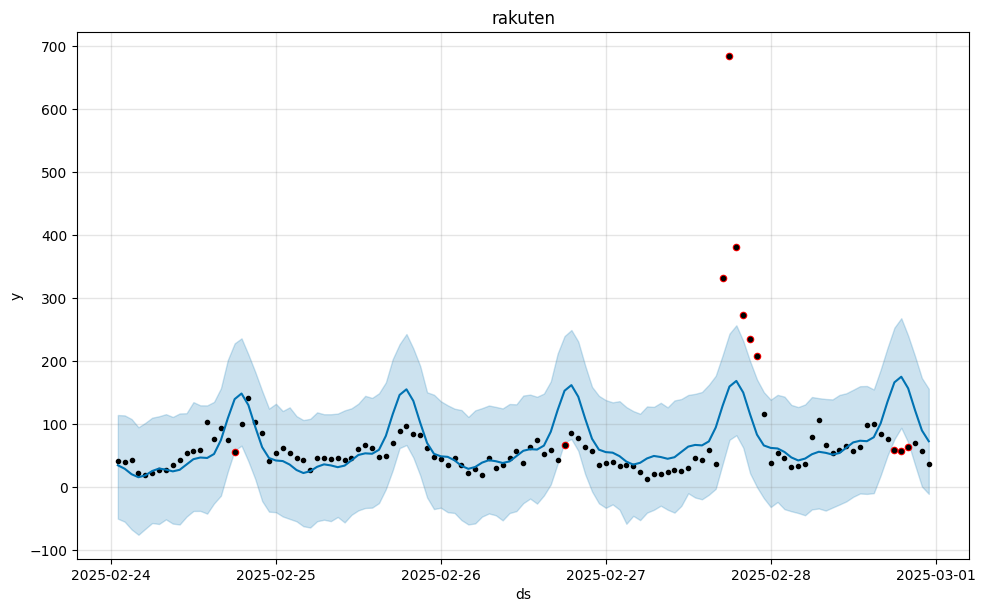

<Figure size 3000x2000 with 0 Axes>

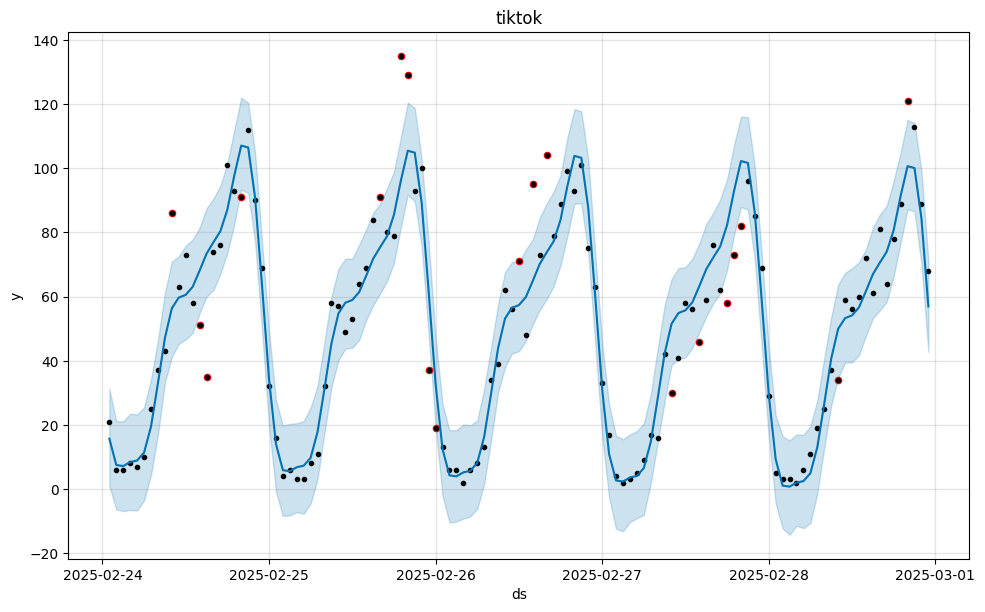

In [90]:
source_list = ["google","Klaviyo","fbig","rakuten","tiktok"]
sessions_contributions = anomaly_percents(landing_page_viewers_top_level,landing_page_by_source, source_list)
sessions_source_contributions = sessions_contributions[sessions_contributions["is_anomaly"] == 1]
sessions_source_contributions

09:14:05 - cmdstanpy - INFO - Chain [1] start processing


09:14:05 - cmdstanpy - INFO - Chain [1] done processing
09:14:05 - cmdstanpy - INFO - Chain [1] start processing
09:14:05 - cmdstanpy - INFO - Chain [1] done processing
09:14:05 - cmdstanpy - INFO - Chain [1] start processing
09:14:05 - cmdstanpy - INFO - Chain [1] done processing
09:14:05 - cmdstanpy - INFO - Chain [1] start processing
09:14:05 - cmdstanpy - INFO - Chain [1] done processing


ds   yhat_lower   yhat_upper         yhat     y  \
41  2025-02-25 18:00:00  1742.477435  2560.218137  2139.124973  3149   
54  2025-02-26 07:00:00   520.680837  1338.704980   948.821022  1641   
65  2025-02-26 18:00:00  1723.467441  2533.047045  2130.573987  1427   
66  2025-02-26 19:00:00  2145.462788  2996.238934  2579.541717  1925   
67  2025-02-26 20:00:00  2320.797502  3162.187269  2731.568000  2090   
79  2025-02-27 08:00:00   886.731858  1715.506923  1303.682841   824   
80  2025-02-27 09:00:00  1020.874376  1819.396935  1409.869366   973   
89  2025-02-27 18:00:00  1797.281531  2640.798656  2206.153250  4227   
90  2025-02-27 19:00:00  2252.965724  3090.437697  2656.870334  3229   
91  2025-02-27 20:00:00  2386.271186  3209.674916  2810.645969  3402   
92  2025-02-27 21:00:00  2112.430736  2944.322515  2506.328639  3010   
93  2025-02-27 22:00:00  1417.455596  2269.525136  1849.169535  2466   
102 2025-02-28 07:00:00   645.998206  1475.413715  1069.954915  1925   
113 2025-02-28 18:00:00  1860.537529  2722.359969  2291.778936  1846   
114 2025-02-28 19:00:00  2327.213739  3179.547049  2742.496020  2285   

     is_anomaly         diff  percent_diff  percent_diff cpc  \
41            1  1009.875027      0.320697          0.020916   
54            1   692.178978      0.421803          0.172167   
65            1   703.573987      0.493044          0.237793   
66            1   654.541717      0.340022          0.157168   
67            1   641.568000      0.306970          0.043454   
79            1   479.682841      0.582139          0.197108   
80            1   436.869366      0.448992          0.148212   
89            1  2020.846750      0.478081          0.109833   
90            1   572.129666      0.177185          0.038015   
91            1   591.354031      0.173825          0.082020   
92            1   503.671361      0.167333          0.045406   
93            1   616.830465      0.250134          0.104067   
102           1   855.045085      0.444179          0.306014   
113           1   445.778936      0.241484          0.112123   
114           1   457.496020      0.200217          0.162055   

     percent_diff affiliates  percent_diff email  percent_diff paid_social  
41                  0.659850            0.719453                  0.095554  
54                  0.072504            0.661238                  0.160236  
65                  1.191240            2.660792                  0.126738  
66                  0.788434            2.568715                  0.030602  
67                  0.780018            2.873048                  0.145561  
79                  1.103743            2.920169                  0.207342  
80                  0.587622            2.993291                  0.198598  
89                  0.764527            0.761196                  0.027697  
90                  0.553069            0.447869                  0.052777  
91                  0.440617            0.361306                  0.111898  
92                  0.503325            0.523574                  0.065887  
93                  0.592331            0.723335                  0.145934  
102                 0.476970            0.632440                  0.163108  
113                 1.624053            3.305436                  0.002022  
114                 2.103444            3.561833                  0.066743

<Figure size 3000x2000 with 0 Axes>

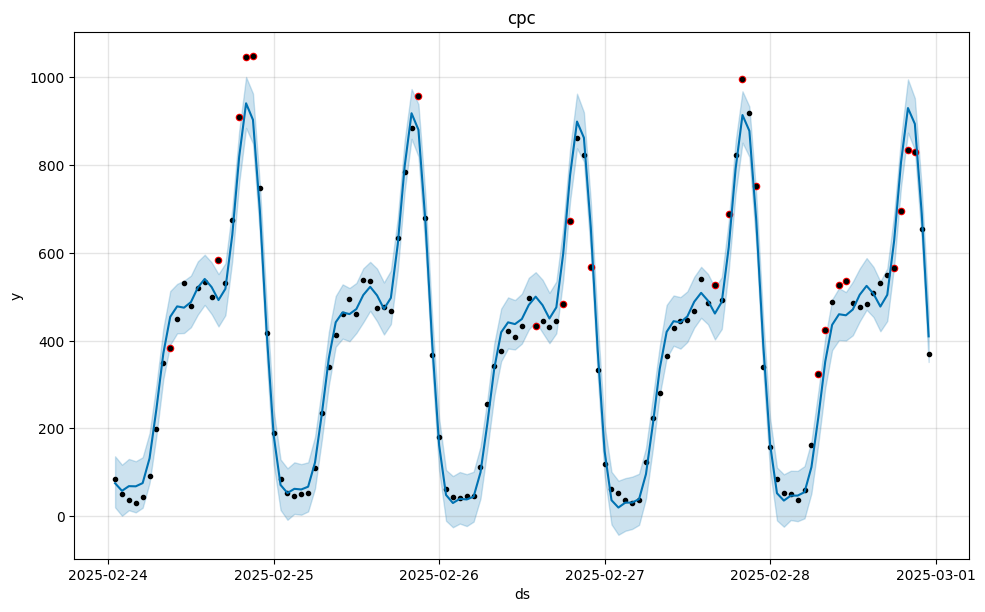

<Figure size 3000x2000 with 0 Axes>

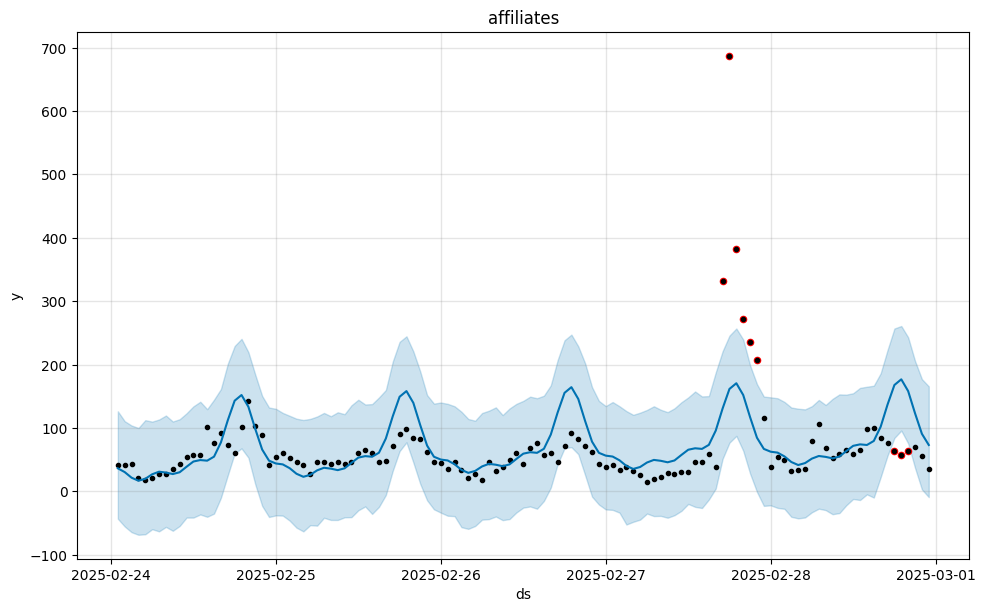

<Figure size 3000x2000 with 0 Axes>

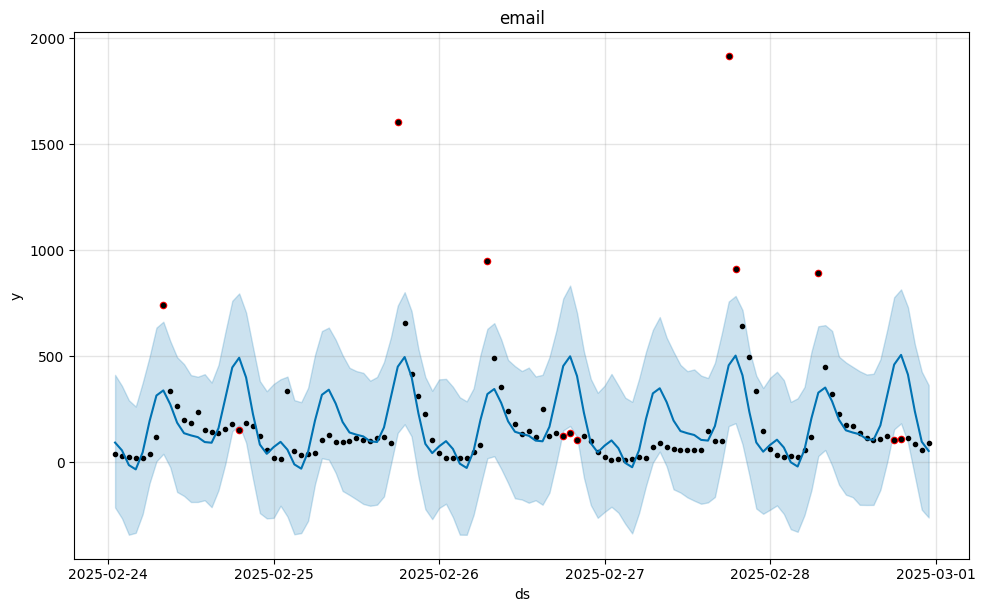

<Figure size 3000x2000 with 0 Axes>

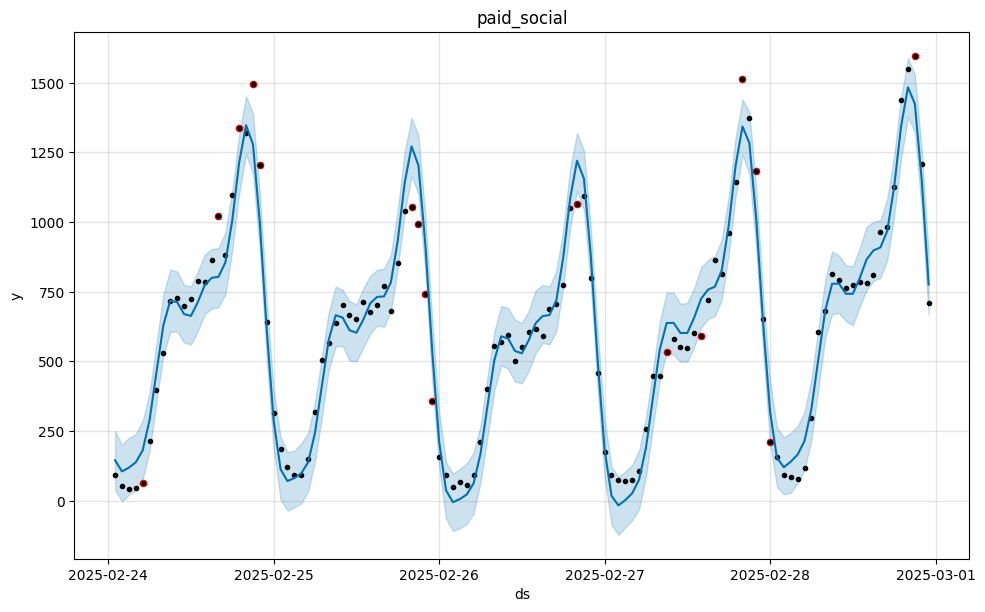

In [89]:
medium_list = ["cpc","affiliates","email","paid_social"]
sessions_contributions_med = anomaly_percents(landing_page_viewers_top_level,landing_page_by_medium, source_list)
sessions_medium_contributions = sessions_contributions_med[sessions_contributions_med["is_anomaly"] == 1]
sessions_medium_contributions

In [91]:
visitors_anomaly_percentages_device = visitors_contributions_device.set_index('ds')[["percent_diff "+device for device in devices]]
visitor_anomaly_percentages_geo = visitors_geo_contributions.set_index('ds')[["percent_diff Global", "percent_diff US"]]
orders_anomaly_percentages_device = orders_contributions_device.set_index('ds')[["percent_diff "+device for device in devices]]
order_anomaly_percentages_geo = orders_geo_contributions.set_index('ds')[["percent_diff Global", "percent_diff US"]]
buyers_anomaly_percentages_device = buyers_contributions_device.set_index('ds')[["percent_diff "+device for device in devices]]
buyer_anomaly_percentages_geo = buyers_geo_contributions.set_index('ds')[["percent_diff Global", "percent_diff US"]]
sessions_source_contributions = sessions_source_contributions.set_index('ds')[["percent_diff " + source for source in source_list]]
sessions_medium_contributions = sessions_medium_contributions.set_index('ds')[["percent_diff " + medium for medium in medium_list]]
sessions_medium_contributions

percent_diff cpc  percent_diff affiliates  \
ds                                                               
2025-02-25 18:00:00          0.020916                 0.659850   
2025-02-26 07:00:00          0.172167                 0.072504   
2025-02-26 18:00:00          0.237793                 1.191240   
2025-02-26 19:00:00          0.157168                 0.788434   
2025-02-26 20:00:00          0.043454                 0.780018   
2025-02-27 08:00:00          0.197108                 1.103743   
2025-02-27 09:00:00          0.148212                 0.587622   
2025-02-27 18:00:00          0.109833                 0.764527   
2025-02-27 19:00:00          0.038015                 0.553069   
2025-02-27 20:00:00          0.082020                 0.440617   
2025-02-27 21:00:00          0.045406                 0.503325   
2025-02-27 22:00:00          0.104067                 0.592331   
2025-02-28 07:00:00          0.306014                 0.476970   
2025-02-28 18:00:00          0.112123                 1.624053   
2025-02-28 19:00:00          0.162055                 2.103444   

                     percent_diff email  percent_diff paid_social  
ds                                                                 
2025-02-25 18:00:00            0.719453                  0.095554  
2025-02-26 07:00:00            0.661238                  0.160236  
2025-02-26 18:00:00            2.660792                  0.126738  
2025-02-26 19:00:00            2.568715                  0.030602  
2025-02-26 20:00:00            2.873048                  0.145561  
2025-02-27 08:00:00            2.920169                  0.207342  
2025-02-27 09:00:00            2.993291                  0.198598  
2025-02-27 18:00:00            0.761196                  0.027697  
2025-02-27 19:00:00            0.447869                  0.052777  
2025-02-27 20:00:00            0.361306                  0.111898  
2025-02-27 21:00:00            0.523574                  0.065887  
2025-02-27 22:00:00            0.723335                  0.145934  
2025-02-28 07:00:00            0.632440                  0.163108  
2025-02-28 18:00:00            3.305436                  0.002022  
2025-02-28 19:00:00            3.561833                  0.066743

In [92]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

def find_eps(df):
  nn = NearestNeighbors(n_neighbors=8).fit(df)
  distances, indices = nn.kneighbors(df)
  distances = np.sort(distances, axis=0)
  distances = distances[:,1]
  kneedle = KneeLocator(range(len(distances)), distances, S=1.0, curve="convex", direction="increasing")
  kneedle.plot_knee()
  return distances[kneedle.elbow]

def find_maximum_contributors(df, index, eps):
  reshaped_row = np.array(df.iloc[index].to_list()).reshape(-1, 1)
  db = DBSCAN(eps=eps*0.5, min_samples=1).fit(reshaped_row)
  labels = db.labels_
  clusters = {}
  for label in set(labels):
    clusters[label] = reshaped_row[labels == label]
  sorted_clusters = {k: clusters[k] for k in sorted(clusters, key=lambda k: max(clusters[k]), reverse=True)}
  max_contributors = sorted_clusters[list(sorted_clusters.keys())[0]]
  if len(sorted_clusters.keys()) == 1:
    return
  contributing_columns = []
  for val in max_contributors:
    col_index = list(reshaped_row).index(val)
    contributing_columns.append(df.columns[col_index])
  return contributing_columns

def create_contributor_col(df):
  df = df.fillna(0)
  eps = find_eps(df)
  contribution_list = []
  for i in range(df.shape[0]):
    contribution_list.append(find_maximum_contributors(df, i, eps))
  df['Contributors'] = contribution_list
  return df

ds_x  percent_diff Android  percent_diff Linux  \
0 2025-02-27 18:00:00               0.42552            0.193124   
1                 NaT                   NaN                 NaN   
2                 NaT                   NaN                 NaN   
3                 NaT                   NaN                 NaN   
4                 NaT                   NaN                 NaN   

   percent_diff macOS  percent_diff Other  percent_diff Windows  \
0            0.194108            0.096089              0.614519   
1                 NaN                 NaN                   NaN   
2                 NaN                 NaN                   NaN   
3                 NaN                 NaN                   NaN   
4                 NaN                 NaN                   NaN   

   percent_diff iOS                                       Contributors  \
0          0.438313  (percent_diff Android, percent_diff Windows, p...   
1               NaN                             (percent_diff Global,)   
2               NaN                             (percent_diff Global,)   
3               NaN                             (percent_diff Global,)   
4               NaN                             (percent_diff Global,)   

                 ds_y  percent_diff Global  percent_diff US  
0                 NaT                  NaN              NaN  
1 2025-02-25 18:00:00             0.260027         0.023133  
2 2025-02-26 18:00:00             0.399765         0.313523  
3 2025-02-26 20:00:00             0.250939         0.115027  
4 2025-02-27 09:00:00             0.356319         0.132933

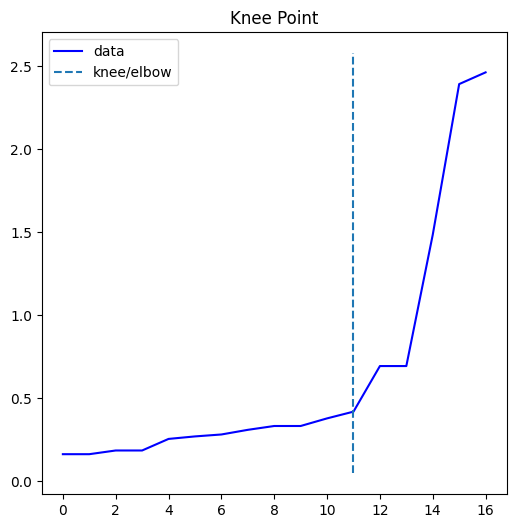

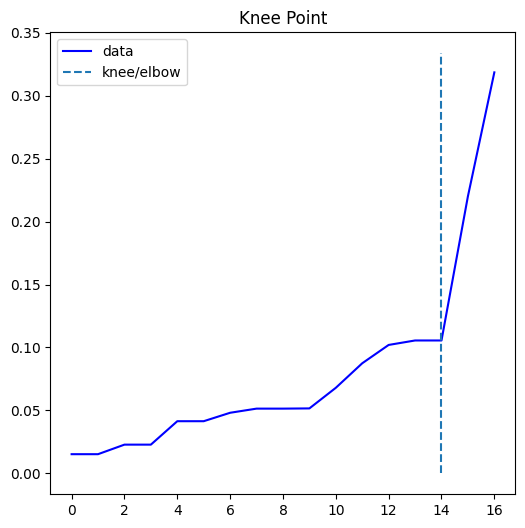

In [55]:
visitor_device_contributing_columns = create_contributor_col(visitors_anomaly_percentages_device)
visitor_device_contributing_columns.reset_index(inplace=True)
visitor_geography_contributing_columns = create_contributor_col(visitor_anomaly_percentages_geo)
visitor_geography_contributing_columns.reset_index(inplace=True)

# Convert list values to tuples in Contributors column before merging
visitor_device_contributing_columns['Contributors'] = visitor_device_contributing_columns['Contributors'].apply(lambda x: tuple(x) if isinstance(x, list) else x)
visitor_geography_contributing_columns['Contributors'] = visitor_geography_contributing_columns['Contributors'].apply(lambda x: tuple(x) if isinstance(x, list) else x)

# Now merge the dataframes
visitor_contributing_columns = pd.merge(
    visitor_device_contributing_columns,
    visitor_geography_contributing_columns,
    on='Contributors',
    how='outer'
)

visitor_contributing_columns.head()

ds_x  percent_diff Android  percent_diff Linux  \
0                   NaT                   NaN                 NaN   
1                   NaT                   NaN                 NaN   
2                   NaT                   NaN                 NaN   
3                   NaT                   NaN                 NaN   
4                   NaT                   NaN                 NaN   
..                  ...                   ...                 ...   
112 2025-02-28 20:00:00              0.262089                 0.0   
113 2025-02-28 20:00:00              0.262089                 0.0   
114 2025-02-28 20:00:00              0.262089                 0.0   
115 2025-02-28 20:00:00              0.262089                 0.0   
116 2025-02-28 20:00:00              0.262089                 0.0   

     percent_diff macOS  percent_diff Other  percent_diff Windows  \
0                   NaN                 NaN                   NaN   
1                   NaN                 NaN                   NaN   
2                   NaN                 NaN                   NaN   
3                   NaN                 NaN                   NaN   
4                   NaN                 NaN                   NaN   
..                  ...                 ...                   ...   
112            0.132374                 0.0               0.04115   
113            0.132374                 0.0               0.04115   
114            0.132374                 0.0               0.04115   
115            0.132374                 0.0               0.04115   
116            0.132374                 0.0               0.04115   

     percent_diff iOS            Contributors                ds_y  \
0                 NaN  (percent_diff Global,) 2025-02-26 07:00:00   
1                 NaN  (percent_diff Global,) 2025-02-28 03:00:00   
2                 NaN  (percent_diff Global,) 2025-02-28 16:00:00   
3                 NaN      (percent_diff US,) 2025-02-26 18:00:00   
4                 NaN      (percent_diff US,) 2025-02-27 14:00:00   
..                ...                     ...                 ...   
112          0.076697                    None 2025-02-27 21:00:00   
113          0.076697                    None 2025-02-28 05:00:00   
114          0.076697                    None 2025-02-28 07:00:00   
115          0.076697                    None 2025-02-28 12:00:00   
116          0.076697                    None 2025-02-28 20:00:00   

     percent_diff Global  percent_diff US  
0               0.401027         0.000000  
1               7.152563         0.167782  
2               0.251971         0.041799  
3               0.367041         2.684537  
4               0.319260         0.543569  
..                   ...              ...  
112             0.259393         0.388758  
113             1.141199         0.996216  
114             0.299070         0.287416  
115             0.137629         0.126391  
116             0.101202         0.255547  

[117 rows x 11 columns]

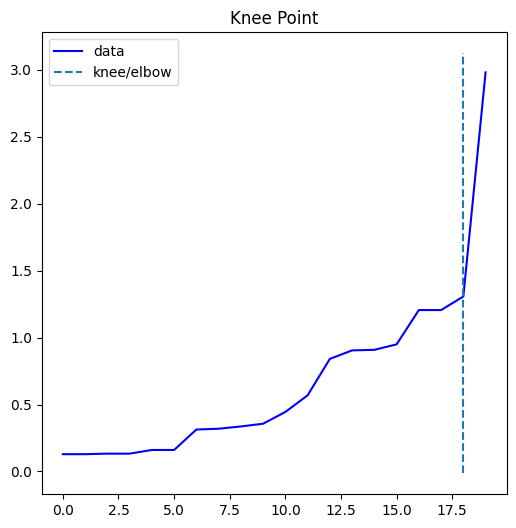

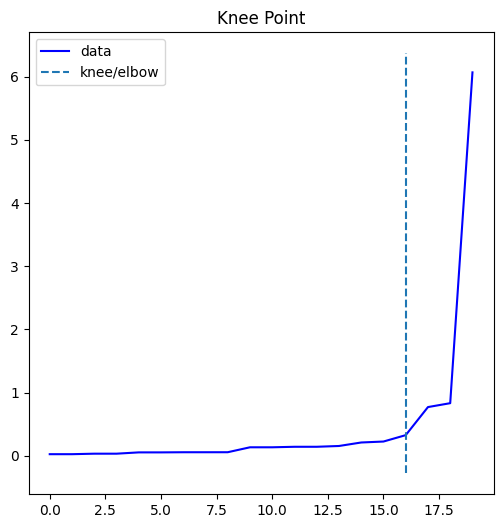

In [56]:
order_device_contributing_columns = create_contributor_col(orders_anomaly_percentages_device)
order_device_contributing_columns.reset_index(inplace=True)

order_geography_contributing_columns = create_contributor_col(order_anomaly_percentages_geo)
order_geography_contributing_columns.reset_index(inplace=True)

# Convert list values to tuples in Contributors column before merging
order_device_contributing_columns['Contributors'] = order_device_contributing_columns['Contributors'].apply(lambda x: tuple(x) if isinstance(x, list) else x)
order_geography_contributing_columns['Contributors'] = order_geography_contributing_columns['Contributors'].apply(lambda x: tuple(x) if isinstance(x, list) else x)

# Now merge the dataframes
order_contributing_columns = pd.merge(
    order_device_contributing_columns,
    order_geography_contributing_columns,
    on='Contributors',
    how='outer'
)

order_contributing_columns

ds_x  percent_diff Android  percent_diff Linux  \
0  2025-02-27 09:00:00              0.722547                 0.0   
1  2025-02-28 05:00:00              0.896008                 0.0   
2                  NaT                   NaN                 NaN   
3                  NaT                   NaN                 NaN   
4                  NaT                   NaN                 NaN   
..                 ...                   ...                 ...   
60 2025-02-28 19:00:00              0.202230                 0.0   
61 2025-02-28 19:00:00              0.202230                 0.0   
62 2025-02-28 20:00:00              0.270745                 0.0   
63 2025-02-28 20:00:00              0.270745                 0.0   
64 2025-02-28 20:00:00              0.270745                 0.0   

    percent_diff macOS  percent_diff Other  percent_diff Windows  \
0             0.085652                 0.0              0.131994   
1             0.000000                 0.0              0.000000   
2                  NaN                 NaN                   NaN   
3                  NaN                 NaN                   NaN   
4                  NaN                 NaN                   NaN   
..                 ...                 ...                   ...   
60            0.476586                 0.0              0.983351   
61            0.476586                 0.0              0.983351   
62            0.145341                 0.0              0.182765   
63            0.145341                 0.0              0.182765   
64            0.145341                 0.0              0.182765   

    percent_diff iOS                              Contributors  \
0           0.651641  (percent_diff Android, percent_diff iOS)   
1           1.054313  (percent_diff Android, percent_diff iOS)   
2                NaN                    (percent_diff Global,)   
3                NaN                    (percent_diff Global,)   
4                NaN                    (percent_diff Global,)   
..               ...                                       ...   
60          0.087603                                      None   
61          0.087603                                      None   
62          0.058787                                      None   
63          0.058787                                      None   
64          0.058787                                      None   

                  ds_y  percent_diff Global  percent_diff US  
0                  NaT                  NaN              NaN  
1                  NaT                  NaN              NaN  
2  2025-02-24 16:00:00             0.252793         0.000000  
3  2025-02-26 07:00:00             0.385746         0.000000  
4  2025-02-27 11:00:00             0.330265         0.126627  
..                 ...                  ...              ...  
60 2025-02-27 15:00:00             0.295362         0.370181  
61 2025-02-28 12:00:00             0.170982         0.202427  
62 2025-02-27 09:00:00             0.501118         0.524878  
63 2025-02-27 15:00:00             0.295362         0.370181  
64 2025-02-28 12:00:00             0.170982         0.202427  

[65 rows x 11 columns]

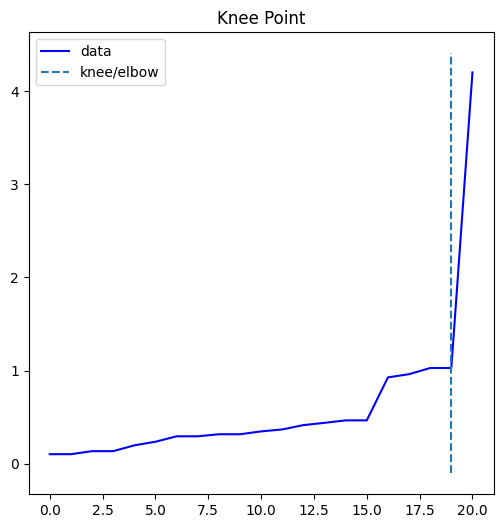

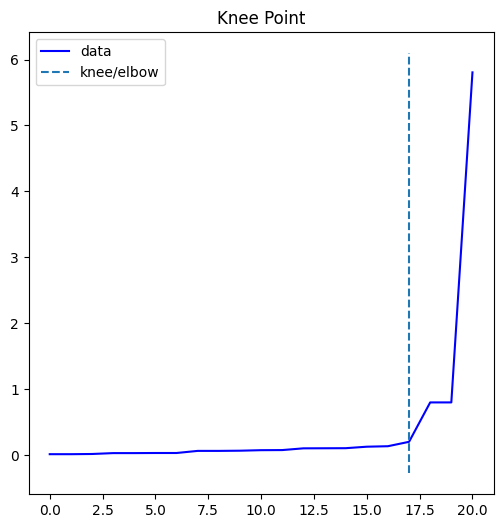

In [57]:
buyer_device_contributing_columns = create_contributor_col(buyers_anomaly_percentages_device)
buyer_device_contributing_columns.reset_index(inplace=True)
buyer_device_contributing_columns.head()

buyer_geography_contributing_columns = create_contributor_col(buyer_anomaly_percentages_geo)
buyer_geography_contributing_columns.reset_index(inplace=True)
buyer_geography_contributing_columns.head()

# Convert list values to tuples in Contributors column before merging
buyer_device_contributing_columns['Contributors'] = buyer_device_contributing_columns['Contributors'].apply(lambda x: tuple(x) if isinstance(x, list) else x)
buyer_geography_contributing_columns['Contributors'] = buyer_geography_contributing_columns['Contributors'].apply(lambda x: tuple(x) if isinstance(x, list) else x)

# Now merge the dataframes
buyer_contributing_columns = pd.merge(
    buyer_device_contributing_columns,
    buyer_geography_contributing_columns,
    on='Contributors',
    how='outer'
)

buyer_contributing_columns

ds_x  percent_diff google  percent_diff Klaviyo  \
0  2025-02-26 07:00:00             0.172514              0.670405   
1  2025-02-26 18:00:00             0.229767              3.099577   
2  2025-02-26 19:00:00             0.165223              2.813240   
3  2025-02-26 20:00:00             0.046824              3.058675   
4  2025-02-27 08:00:00             0.198840              3.286907   
5  2025-02-27 09:00:00             0.146013              3.522021   
6  2025-02-28 18:00:00             0.108132              3.478816   
7  2025-02-28 19:00:00             0.170220              3.806497   
8  2025-02-25 18:00:00             0.017921              0.731770   
9  2025-02-27 18:00:00             0.119205              0.758677   
10 2025-02-27 21:00:00             0.048717              0.500394   
11 2025-02-27 22:00:00             0.102111              0.703195   
12 2025-02-27 19:00:00             0.033048              0.435030   
13                 NaT                  NaN                   NaN   
14                 NaT                  NaN                   NaN   
15                 NaT                  NaN                   NaN   
16                 NaT                  NaN                   NaN   
17                 NaT                  NaN                   NaN   
18                 NaT                  NaN                   NaN   
19                 NaT                  NaN                   NaN   
20                 NaT                  NaN                   NaN   
21                 NaT                  NaN                   NaN   
22                 NaT                  NaN                   NaN   
23                 NaT                  NaN                   NaN   
24                 NaT                  NaN                   NaN   
25                 NaT                  NaN                   NaN   
26                 NaT                  NaN                   NaN   
27                 NaT                  NaN                   NaN   
28 2025-02-27 20:00:00             0.081275              0.340995   
29 2025-02-28 07:00:00             0.302674              0.616974   

    percent_diff fbig  percent_diff rakuten  percent_diff tiktok  \
0            0.176365              0.063033             0.252257   
1            0.155775              1.308918             0.057407   
2            0.042644              0.875668             0.045199   
3            0.152982              0.855774             0.116619   
4            0.198681              1.356431             0.762247   
5            0.225314              0.847980             0.005804   
6            0.004712              1.808599             0.034556   
7            0.076383              2.063613             0.026185   
8            0.096045              0.655976             0.082209   
9            0.006247              0.767471             0.418742   
10           0.073050              0.511185             0.058958   
11           0.155956              0.600207             0.011631   
12           0.040647              0.559137             0.272898   
13                NaN                   NaN                  NaN   
14                NaN                   NaN                  NaN   
15                NaN                   NaN                  NaN   
16                NaN                   NaN                  NaN   
17                NaN                   NaN                  NaN   
18                NaN                   NaN                  NaN   
19                NaN                   NaN                  NaN   
20                NaN                   NaN                  NaN   
21                NaN                   NaN                  NaN   
22                NaN                   NaN                  NaN   
23                NaN                   NaN                  NaN   
24                NaN                   NaN                  NaN   
25                NaN                   NaN                  NaN   
26                NaN                   Na

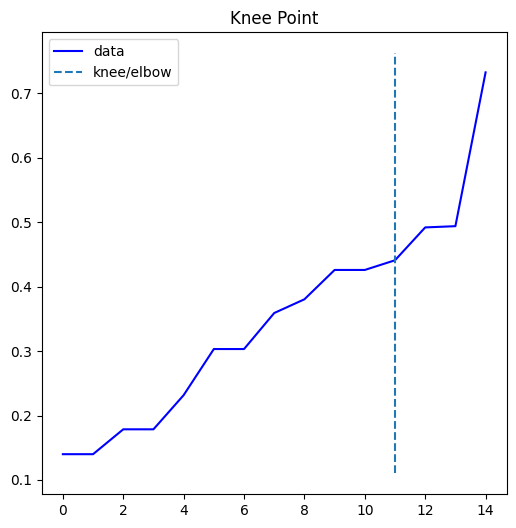

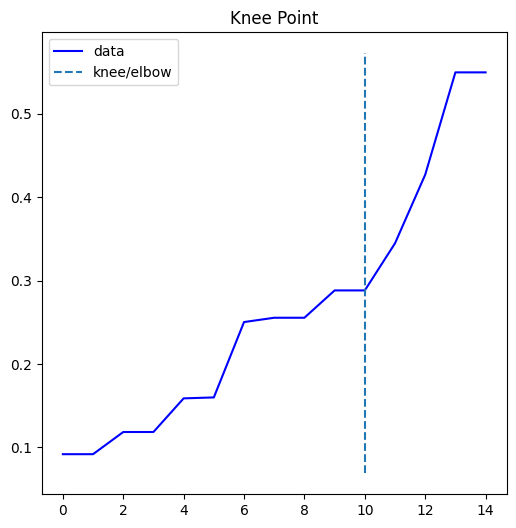

In [95]:
sessions_source_contributing_columns = create_contributor_col(sessions_source_contributions)
sessions_source_contributing_columns.reset_index(inplace=True)
sessions_source_contributing_columns.head()

sessions_medium_contributing_columns = create_contributor_col(sessions_medium_contributions)
sessions_medium_contributing_columns.reset_index(inplace=True)
sessions_medium_contributing_columns.head()

# Convert list values to tuples in Contributors column before merging
sessions_source_contributing_columns['Contributors'] = sessions_source_contributing_columns['Contributors'].apply(lambda x: tuple(x) if isinstance(x, list) else x)
sessions_medium_contributing_columns['Contributors'] = sessions_medium_contributing_columns['Contributors'].apply(lambda x: tuple(x) if isinstance(x, list) else x)

# Now merge the dataframes
sessions_contributing_columns = pd.merge(
    sessions_source_contributing_columns,
    sessions_medium_contributing_columns,
    on='Contributors',
    how='outer'
)

sessions_contributing_columns

In [58]:
def clean_contributors(contributors):
    if not contributors or all(c is None for c in contributors):
        return None
    
    # Flatten the list of contributors and clean up each name
    cleaned = []
    for c in contributors:
        if c is not None:
            if isinstance(c, tuple):
                # If it's a tuple, process each element
                for item in c:
                    if item is not None:
                        # Remove 'percent_diff' prefix if it exists
                        name = str(item).replace('percent_diff', '')
                        # Capitalize first letter of each word
                        # name = ' '.join(word.capitalize() for word in name.split('_'))
                        cleaned.append(name)
            else:
                # If it's a single value, just clean it
                name = str(c).replace('percent_diff', '')
                # Capitalize first letter of each word
                # name = ' '.join(word.capitalize() for word in name.split('_'))
                cleaned.append(name)
    
    return list(set(cleaned))  # Remove duplicates

In [59]:
def calculate_metric_summary(filtered_anomalies, metric_name, contributing_columns_df):
    # Count anomalies for this metric
    metric_anomalies = filtered_anomalies[filtered_anomalies["event_names"].apply(
        lambda x: any(metric_name.lower() in event.lower() for event in x)
    )]
    anomaly_count = len(metric_anomalies)
    if anomaly_count == 0:
        return f"{metric_name.capitalize()}: No anomalies"
    # Get contributors for this metric’s anomalies
    contributors = {}
    for _, row in metric_anomalies.iterrows():
        hour_data = contributing_columns_df[
            contributing_columns_df["ds_x"] == row["hour"]
        ]
        if not hour_data.empty:
            # Handle potential None values in Contributors column
            contributors_list = hour_data["Contributors"].tolist()
            if contributors_list and not all(x is None for x in contributors_list):
                for contrib in clean_contributors(contributors_list):
                    if contrib:
                        contributors[contrib] = contributors.get(contrib, 0) + 1
    # Format the summary string
    summary = f"{metric_name.capitalize()}: {anomaly_count} anomalies"
    if contributors:
        top_contributor = max(contributors.items(), key=lambda x: x[1])
        summary += f"(Top contributor: {top_contributor[0]} with {top_contributor[1]} occurrences)"
    return summary

In [60]:
ANOMALY_PRIORITY = {
    'visitors': 1,
    'landing_page': 2,
    'added_to_cart': 3,
    'checkout_started': 4,
    'orders': 5,
    'buyers': 6
}

# Create the figure
fig = px.line(visitors_top_level, x='ds', y='y',
          title="Total Visitors Over Time with Anomalies",
          labels={"y": "Number of Visitors", "ds": "Time"})

# Add highlighted regions for hours with anomalies
for idx, row in anomaly_df.iterrows():
    if row['event_names']:  # If there are any anomalies in this hour
        fig.add_vrect(x0=row['hour'] - pd.Timedelta(hours=0.5), 
                 x1=row['hour'] + pd.Timedelta(hours=0.5),
                 fillcolor="red", 
                 opacity=0.3, 
                 line_width=0)

# Update layout for better visualization
fig.update_layout(
    xaxis_title="Time",
    yaxis_title="Number of Visitors",
    hovermode="x unified",
    showlegend=False
)


visitor_summary = calculate_metric_summary(anomaly_df, "visitors", visitor_contributing_columns)
order_summary = calculate_metric_summary(anomaly_df, "orders", order_contributing_columns)
buyer_summary = calculate_metric_summary(anomaly_df,"buyers", buyer_contributing_columns)

fig.update_layout(
        xaxis_title="Time",
        yaxis_title="Number of Visitors",
        hovermode="x unified",
        showlegend=False,
        margin=dict(b=150),  # Add bottom margin for the summary
        annotations=[
            dict(
                text=f"<br>Summary Statistics:<br>{visitor_summary}<br>{order_summary}<br>{buyer_summary}",
                xref="paper",
                yref="paper",
                x=0.5,
                y=-0.70,  # Position just below the x-axis title
                showarrow=False,
                font=dict(size=12),
                align="center"
            )
        ]
    )

# Create hover text that includes only the highest priority event name and its corresponding metric contributors
hover_text = []
for idx, row in anomaly_df.iterrows():
    # Get the visitor count for this hour from visitors_top_level
    visitor_count = visitors_top_level[visitors_top_level['ds'] == row['hour']]['y'].values
    visitor_count = visitor_count[0] if len(visitor_count) > 0 else "N/A"

    hover_info = f"<b>Time:</b> {row['hour']}<br>"
    hover_info += f"<b>Visitors:</b> {visitor_count}<br>"

    if row['event_names']:
        # Find the highest priority anomaly
        def get_priority(event_name):
            for key, priority in ANOMALY_PRIORITY.items():
                if key in event_name.lower():
                    return priority
            return float('inf')  # Return infinity for unmatched events
        
        highest_priority_event = min(row['event_names'], key=get_priority)
        
        hover_info += "<b>Anomaly:</b><br>"
        hover_info += f"- {highest_priority_event}"
        
        # Get the contributors for this specific hour
        current_hour = row['hour']
        
        # Determine which metric this event belongs to and add its cleaned contributors
        if 'visitor' in highest_priority_event.lower():
            hour_data = visitor_contributing_columns[
                visitor_contributing_columns['ds_x'] == current_hour
            ]
        elif 'order' in highest_priority_event.lower():
            hour_data = order_contributing_columns[
                order_contributing_columns['ds_x'] == current_hour
            ]
        elif 'buyer' in highest_priority_event.lower():
            hour_data = buyer_contributing_columns[
                buyer_contributing_columns['ds_x'] == current_hour
            ]
        else:
            hour_data = pd.DataFrame()  # Empty DataFrame if no matching metric

        if not hour_data.empty:
            contributors = clean_contributors(hour_data['Contributors'].tolist())
            if contributors:
                hover_info += " (Contributors: "
                contributor_info = []
                for contrib in contributors:
                    # Find the percent_diff for this contributor using the correct column name
                    percent_diff_col = [i for i in hour_data.columns if contrib in i][0]
                    if percent_diff_col in hour_data.columns:
                        percent_diff = hour_data[percent_diff_col].values[0]
                        contributor_info.append(f"{contrib} ({percent_diff:.1f}%)")
                hover_info += ", ".join(contributor_info) + ")"
            else:
                hover_info += " (Contributors: N/A)"

    hover_text.append(hover_info)

# Update hover template
fig.update_traces(
    hovertemplate="%{customdata}<extra></extra>",
    customdata=hover_text
)

# Show the figure
fig.show()

In [61]:
def plot_visitors_anomalies(anomaly_df, visitors_df, start_date, end_date):
    """
    Plot visitors and anomalies for a date range.
    
    Parameters:
    -----------
    anomaly_df : pandas DataFrame
        DataFrame containing anomaly information with 'hour' and 'event_names' columns
    visitors_df : pandas DataFrame
        DataFrame containing visitor information with 'ds' and 'y' columns
    start_date : str or datetime
        The start date (e.g., '2025-02-15')
    end_date : str or datetime
        The end date (e.g., '2025-02-16')
    """
    import plotly.express as px
    
    # Convert dates to datetime if they're strings
    start_time = pd.to_datetime(start_date).replace(hour=0, minute=0, second=0)
    end_time = pd.to_datetime(end_date).replace(hour=23, minute=59, second=59)
    
    # Filter data for the date range
    filtered_visitors = visitors_df[
        (visitors_df['ds'] >= start_time) & 
        (visitors_df['ds'] <= end_time)
    ].copy()
    
    filtered_anomalies = anomaly_df[
        (anomaly_df['hour'] >= start_time) & 
        (anomaly_df['hour'] <= end_time)
    ].copy()
    
    # Create the figure
    fig = px.line(filtered_visitors, x='ds', y='y',
              title="Total Visitors Over Time with Anomalies",
              labels={"y": "Number of Visitors", "ds": "Time"})

    # Add highlighted regions for hours with anomalies
    for idx, row in filtered_anomalies.iterrows():
        if row['event_names']:  # If there are any anomalies in this hour
            fig.add_vrect(x0=row['hour'] - pd.Timedelta(hours=0.5), 
                     x1=row['hour'] + pd.Timedelta(hours=0.5),
                     fillcolor="red", 
                     opacity=0.3, 
                     line_width=0)

    # Update layout for better visualization
    fig.update_layout(
        xaxis_title="Time",
        yaxis_title="Number of Visitors",
        hovermode="x unified",
        showlegend=False
    )

    # Create hover text that includes event names and their corresponding metric contributors
    hover_text = []
    for idx, row in filtered_anomalies.iterrows():
        # Get the visitor count for this hour from visitors_top_level
        visitor_count = filtered_visitors[filtered_visitors['ds'] == row['hour']]['y'].values
        visitor_count = visitor_count[0] if len(visitor_count) > 0 else "N/A"
    
        hover_info = f"<b>Time:</b> {row['hour']}<br>"
        hover_info += f"<b>Visitors:</b> {visitor_count}<br>"

        if row['event_names']:
            hover_info += "<b>Anomalies:</b><br>"
            # Check each event name to determine which metric it belongs to
            for event in row['event_names']:
                hover_info += f"- {event}"
                
                # Get the contributors for this specific hour
                current_hour = row['hour']
                
                # Check which metric this event belongs to and add its cleaned contributors
                if 'visitor' in event.lower():
                    # Filter visitor contributors for this hour
                    hour_data = visitor_contributing_columns[
                        visitor_contributing_columns['ds_x'] == current_hour
                    ]
                    if not hour_data.empty:
                        contributors = clean_contributors(hour_data['Contributors'].tolist())
                        if contributors:
                            hover_info += " (Contributors: "
                            contributor_info = []
                            for contrib in contributors:
                                # Find the percent_diff for this contributor using the correct column name
                                percent_diff_col = [i for i in hour_data.columns if contrib in i][0]
                                if percent_diff_col in hour_data.columns:
                                    percent_diff = hour_data[percent_diff_col].values[0]
                                    contributor_info.append(f"{contrib} ({percent_diff:.1f}%)")
                            hover_info += ", ".join(contributor_info) + ")"
                        else:
                            hover_info += " (Contributors: N/A)"
                elif 'order' in event.lower():
                    # Filter order contributors for this hour
                    hour_data = order_contributing_columns[
                        order_contributing_columns['ds_x'] == current_hour
                    ]
                    if not hour_data.empty:
                        contributors = clean_contributors(hour_data['Contributors'].tolist())
                        if contributors:
                            hover_info += " (Contributors: "
                            contributor_info = []
                            for contrib in contributors:
                                # Find the percent_diff for this contributor using the correct column name
                                percent_diff_col = [i for i in hour_data.columns if contrib in i][0]
                                if percent_diff_col in hour_data.columns:
                                    percent_diff = hour_data[percent_diff_col].values[0]
                                    contributor_info.append(f"{contrib} ({percent_diff:.1f}%)")
                            hover_info += ", ".join(contributor_info) + ")"
                        else:
                            hover_info += " (Contributors: N/A)"
                elif 'buyer' in event.lower():
                    # Filter buyer contributors for this hour
                    hour_data = buyer_contributing_columns[
                        buyer_contributing_columns['ds_x'] == current_hour
                    ]
                    if not hour_data.empty:
                        contributors = clean_contributors(hour_data['Contributors'].tolist())
                        if contributors:
                            hover_info += " (Contributors: "
                            contributor_info = []
                            for contrib in contributors:
                                # Find the percent_diff for this contributor using the correct column name
                                percent_diff_col = [i for i in hour_data.columns if contrib in i][0]
                                if percent_diff_col in hour_data.columns:
                                    percent_diff = hour_data[percent_diff_col].values[0]
                                    contributor_info.append(f"{contrib} ({percent_diff:.1f}%)")
                            hover_info += ", ".join(contributor_info) + ")"
                        else:
                            hover_info += " (Contributors: N/A)"
            
                hover_info += "<br>"
    
        hover_text.append(hover_info)

    # Update hover template
    fig.update_traces(
        hovertemplate="%{customdata}<extra></extra>",
        customdata=hover_text
    )

    # Show the figure
    fig.show()

# Example usage:
plot_visitors_anomalies(anomaly_df, visitors_top_level, '2025-02-26', '2025-02-27')

In [62]:
# Create base dataframe with timestamps
merged = visitors_top_level[['ds']].copy()

# Add anomaly flags and values for each metric
merged['visitors_anomaly'] = visitors_top_level['is_anomaly']
merged['visitors_value'] = visitors_top_level['y']
merged['visitors_percent_diff'] = visitors_top_level['percent_diff']
merged['visitor_US_contribution'] = visitors_contributions['percent_diff US']
merged['visitor_Global_contribution'] = visitors_contributions['percent_diff Global']
merged['visitor_iOS_contribution'] = visitors_contribution_dev['percent_diff iOS']
merged['visitor_Android_contribution'] = visitors_contribution_dev['percent_diff Android']
merged['visitor_Linux_contribution'] = visitors_contribution_dev['percent_diff Linux']
merged['visitor_macOS_contribution'] = visitors_contribution_dev['percent_diff macOS']
merged['visitor_Other_contribution'] = visitors_contribution_dev['percent_diff Other']


merged['orders_anomaly'] = orders_top_level['is_anomaly']
merged['orders_value'] = orders_top_level['y']
merged['orders_percent_diff'] = orders_top_level['percent_diff']
merged['order_US_contribution'] = orders_contributions['percent_diff US']
merged['order_Global_contribution'] = orders_contributions['percent_diff Global']
merged['order_iOS_contribution'] = orders_contribution_dev['percent_diff iOS']
merged['order_Android_contribution'] = orders_contribution_dev['percent_diff Android']
merged['order_Linux_contribution'] = orders_contribution_dev['percent_diff Linux']
merged['order_macOS_contribution'] = orders_contribution_dev['percent_diff macOS']
merged['order_Other_contribution'] = orders_contribution_dev['percent_diff Other']

merged['buyers_anomaly'] = buyers_top_level['is_anomaly']
merged['buyers_value'] = buyers_top_level['y']
merged['buyers_percent_diff'] = buyers_top_level['percent_diff']
merged['buyer_US_contribution'] = buyers_contributions['percent_diff US']
merged['buyer_Global_contribution'] = buyers_contributions['percent_diff Global']
merged['buyer_iOS_contribution'] = buyers_contribution_dev['percent_diff iOS']
merged['buyer_Android_contribution'] = buyers_contribution_dev['percent_diff Android']
merged['buyer_Linux_contribution'] = buyers_contribution_dev['percent_diff Linux']
merged['buyer_macOS_contribution'] = buyers_contribution_dev['percent_diff macOS']
merged['buyer_Other_contribution'] = buyers_contribution_dev['percent_diff Other']

# Add time_hour column
merged['time_hour'] = merged['ds'].dt.hour

# Create list of anomalous metrics for each timestamp
def get_anomalous_metrics(row):
    anomalies = []
    if row['visitors_anomaly'] == 1:
        anomalies.append(f"visitors %diff: {row['visitors_percent_diff']*100:.1f}%)")
    if row['orders_anomaly'] == 1:
        anomalies.append(f"%diff: {row['orders_percent_diff']*100:.1f}%)")
    if row['buyers_anomaly'] == 1:
        anomalies.append(f"%diff: {row['buyers_percent_diff']*100:.1f}%)")
    return anomalies if anomalies else []

merged['anomalous_metrics'] = merged.apply(get_anomalous_metrics, axis=1)

# Sort by timestamp
merged = merged.sort_values('ds')

# Filter and display periods with anomalies
anomaly_periods = merged[
    (merged['visitors_anomaly'] == 1) | 
    (merged['orders_anomaly'] == 1) | 
    (merged['buyers_anomaly'] == 1)
]

print("\nTime periods with anomalies:")
print("============================")

for _, row in anomaly_periods.iterrows():
    print(f"\nTimestamp: {row['ds']}")
    print(f"Hour of day: {row['time_hour']}")
    print("Anomalous metrics:")
    for metric in row['anomalous_metrics']:
        print(f"- {metric}")

# Save results if needed
# merged.to_csv("merged_anomalies.csv", index=False)

# Return the merged dataframe for further analysis if needed
merged


Time periods with anomalies:

Timestamp: 2025-02-24 16:00:00
Hour of day: 16
Anomalous metrics:
- %diff: 20.1%)

Timestamp: 2025-02-24 21:00:00
Hour of day: 21
Anomalous metrics:
- visitors %diff: 15.5%)

Timestamp: 2025-02-25 18:00:00
Hour of day: 18
Anomalous metrics:
- visitors %diff: 25.3%)

Timestamp: 2025-02-26 07:00:00
Hour of day: 7
Anomalous metrics:
- visitors %diff: 37.6%)
- %diff: 37.8%)
- %diff: 37.1%)

Timestamp: 2025-02-26 18:00:00
Hour of day: 18
Anomalous metrics:
- visitors %diff: 38.8%)
- %diff: 39.4%)
- %diff: 39.7%)

Timestamp: 2025-02-26 19:00:00
Hour of day: 19
Anomalous metrics:
- visitors %diff: 26.8%)

Timestamp: 2025-02-26 20:00:00
Hour of day: 20
Anomalous metrics:
- visitors %diff: 24.0%)

Timestamp: 2025-02-27 08:00:00
Hour of day: 8
Anomalous metrics:
- visitors %diff: 46.4%)

Timestamp: 2025-02-27 09:00:00
Hour of day: 9
Anomalous metrics:
- visitors %diff: 33.8%)
- %diff: 43.6%)
- %diff: 42.6%)

Timestamp: 2025-02-27 11:00:00
Hour of day: 11
Anomalous 

ds  visitors_anomaly  visitors_value  \
0   2025-02-24 01:00:00                 0             600   
1   2025-02-24 02:00:00                 0             424   
2   2025-02-24 03:00:00                 0             355   
3   2025-02-24 04:00:00                 0             296   
4   2025-02-24 05:00:00                 0             343   
..                  ...               ...             ...   
114 2025-02-28 19:00:00                 1            3613   
115 2025-02-28 20:00:00                 1            3960   
116 2025-02-28 21:00:00                 0            3976   
117 2025-02-28 22:00:00                 0            3120   
118 2025-02-28 23:00:00                 0            1955   

     visitors_percent_diff  visitor_US_contribution  \
0                 0.035501                 0.029494   
1                 0.168665                 0.276413   
2                 0.212251                 0.271229   
3                 0.338520                 0.676097   
4                 0.589057                 0.018462   
..                     ...                      ...   
114               0.180039                 0.176037   
115               0.150495                 0.329352   
116               0.039950                 0.134516   
117               0.001321                 0.146821   
118               0.011584                 0.216448   

     visitor_Global_contribution  visitor_iOS_contribution  \
0                       0.026141                  0.118493   
1                       0.032567                  0.312222   
2                       0.000806                  0.277895   
3                       0.042654                  0.546694   
4                       0.674009                  1.049223   
..                           ...                       ...   
114                     0.193085                  0.182861   
115                     0.142229                  0.177782   
116                     0.033651                  0.059769   
117                     0.007820                  0.003220   
118                     0.020709                  0.010259   

     visitor_Android_contribution  visitor_Linux_contribution  \
0                        0.452783                    0.637765   
1                        0.675385                   23.190057   
2                        0.749555                    0.262421   
3                        0.877370                    3.392117   
4                        0.094184                    0.319633   
..                            ...                         ...   
114                      0.154477                    0.099529   
115                      0.033820                    1.563648   
116                      0.086386                    0.436873   
117                      0.009743                    2.382047   
118                      0.209707                    0.679024   

     visitor_macOS_contribution  ...  buyers_percent_diff  \
0                      0.189004  ...             1.047451   
1                      0.306938  ...             1.063820   
2                      0.714360  ...             0.983207   
3                      1.166200  ...             1.303028   
4                      0.282967  ...             0.950010   
..                          ...  ...                  ...   
114                    0.473229  ...             0.149596   
115                    0.340517  ...             0.100447   
116                    0.609788  ...             0.185962   
117                    0.122654  ...             0.067115   
118                    0.182908  ...             0.202309   

     buyer_US_contribution  buyer_Global_contribution  buyer_iOS_contribution  \
0                 0.328623                   2.397474                1.155684   
1                 0.320445                   7.277638                2.028071   
2                 1.489707                   3.934024                2.256178   
3                 0.464390                  

In [63]:
visitors_contribution_dev

ds   yhat_lower   yhat_upper         yhat     y  \
0   2025-02-24 01:00:00    55.150209  1194.934137   621.300371   600   
1   2025-02-24 02:00:00   -75.831557  1050.914167   495.513891   424   
2   2025-02-24 03:00:00  -184.471390   964.088902   430.349148   355   
3   2025-02-24 04:00:00  -192.568766   926.932186   396.202007   296   
4   2025-02-24 05:00:00   -53.244035  1081.117680   545.046594   343   
..                  ...          ...          ...          ...   ...   
114 2025-02-28 19:00:00  3697.525087  4848.634215  4263.482642  3613   
115 2025-02-28 20:00:00  3984.627150  5118.369410  4555.958938  3960   
116 2025-02-28 21:00:00  3548.813368  4725.601556  4134.840731  3976   
117 2025-02-28 22:00:00  2562.891548  3715.509608  3124.120323  3120   
118 2025-02-28 23:00:00  1417.779704  2566.101775  1977.645830  1955   

     is_anomaly        diff  percent_diff   pred added  diff added  ...  \
0             0   21.300371      0.035501   625.119884  116.965804  ...   
1             0   71.513891      0.168665   498.269702  180.701974  ...   
2             0   75.349148      0.212251   433.032068  142.493826  ...   
3             0  100.202007      0.338520   399.473238  187.700782  ...   
4             0  202.046594      0.589057   548.618937  227.405846  ...   
..          ...         ...           ...          ...         ...  ...   
114           1  650.482642      0.180039  4267.159514  656.548209  ...   
115           1  595.958938      0.150495  4559.685121  599.685121  ...   
116           0  158.840731      0.039950  4140.002217  318.461264  ...   
117           0    4.120323      0.001321  3131.225272   38.761101  ...   
118           0   22.645830      0.011584  1985.890140  154.769239  ...   

     percent_diff Windows     pred iOS    diff iOS  percent_diff iOS  \
0                0.290773   442.923131   46.923131          0.118493   
1                0.566792   341.177689   81.177689          0.312222   
2                2.559695   302.861149   65.861149          0.277895   
3                0.388479   290.778419  102.778419          0.546694   
4                0.012604   405.746103  207.746103          1.049223   
..                    ...          ...         ...               ...   
114              0.137119  3157.055733  488.055733          0.182861   
115              0.290772  3413.212751  515.212751          0.177782   
116              0.528980  3115.721655  175.721655          0.059769   
117              0.221508  2346.419045    7.580955          0.003220   
118              0.550248  1449.721033   14.721033          0.010259   

     perc diff Android  perc diff Linux  perc diff macOS  perc diff Other  \
0             0.340654         0.081789         0.059788         0.051965   
1             0.287792         0.128333         0.052656         0.006704   
2             0.226191         0.031308         0.110292         0.008333   
3             0.224367         0.072288         0.099409         0.025326   
4             0.016981         0.030922         0.033597         0.003788   
..                 ...              ...              ...              ...   
114           0.175994         0.001819         0.057663         0.005912   
115           0.049459         0.010430         0.049401         0.001024   
116           0.242508         0.009603         0.120632         0.000726   
117           0.159618         0.184364         0.215176         0.033817   
118           0.479657         0.149169         0.073272         0.025021   

     perc diff Windows  perc diff iOS  
0             0.064635       0.401170  
1             0.075279       0.449235  
2             0.161672       0.462204  
3             0.031045       0.547565  
4             0.001164       0.913548  
..                 ...            ...  
114           0.015246       0.743366  
115           0.030547       0.859139  
116           0.074747       0.551783  
117           0.211444       0.195582  
118           0.177764   

In [64]:
visitors_contributions

ds   yhat_lower   yhat_upper         yhat     y  \
0   2025-02-24 01:00:00    55.150209  1194.934137   621.300371   600   
1   2025-02-24 02:00:00   -75.831557  1050.914167   495.513891   424   
2   2025-02-24 03:00:00  -184.471390   964.088902   430.349148   355   
3   2025-02-24 04:00:00  -192.568766   926.932186   396.202007   296   
4   2025-02-24 05:00:00   -53.244035  1081.117680   545.046594   343   
..                  ...          ...          ...          ...   ...   
114 2025-02-28 19:00:00  3697.525087  4848.634215  4263.482642  3613   
115 2025-02-28 20:00:00  3984.627150  5118.369410  4555.958938  3960   
116 2025-02-28 21:00:00  3548.813368  4725.601556  4134.840731  3976   
117 2025-02-28 22:00:00  2562.891548  3715.509608  3124.120323  3120   
118 2025-02-28 23:00:00  1417.779704  2566.101775  1977.645830  1955   

     is_anomaly        diff  percent_diff  percent_diff Global  \
0             0   21.300371      0.035501             0.026141   
1             0   71.513891      0.168665             0.032567   
2             0   75.349148      0.212251             0.000806   
3             0  100.202007      0.338520             0.042654   
4             0  202.046594      0.589057             0.674009   
..          ...         ...           ...                  ...   
114           1  650.482642      0.180039             0.193085   
115           1  595.958938      0.150495             0.142229   
116           0  158.840731      0.039950             0.033651   
117           0    4.120323      0.001321             0.007820   
118           0   22.645830      0.011584             0.020709   

     percent_diff US  
0           0.029494  
1           0.276413  
2           0.271229  
3           0.676097  
4           0.018462  
..               ...  
114         0.176037  
115         0.329352  
116         0.134516  
117         0.146821  
118         0.216448  

[119 rows x 10 columns]

In [68]:
import plotly.express as px
# Define the priority hierarchy for anomalies
ANOMALY_PRIORITY = {
    'visitors': 1,
    'landing_page': 2,
    'added_to_cart': 3,
    'checkout_started': 4,
    'orders': 5,
    'buyers': 6
}

# Create the figure
fig = px.line(visitors_top_level, x='ds', y='y',
          title="Total Visitors Over Time with Anomalies",
          labels={"y": "Number of Visitors", "ds": "Time"})

# Add highlighted regions for hours with anomalies
for idx, row in anomaly_df.iterrows():
    if row['event_names']:  # If there are any anomalies in this hour
        fig.add_vrect(x0=row['hour'] - pd.Timedelta(hours=0.5), 
                 x1=row['hour'] + pd.Timedelta(hours=0.5),
                 fillcolor="red", 
                 opacity=0.3, 
                 line_width=0)

# Generate chronological summary of anomalies
summary_lines = []
current_group = {
    'start_time': None,
    'end_time': None,
    'metrics': set(),
    'contributors': set()
}

# Sort anomalies by hour
sorted_anomalies = anomaly_df.sort_values('hour')

for idx, row in sorted_anomalies.iterrows():
    if not row['event_names']:
        continue
        
    current_time = row['hour']
    
    # If this is the first anomaly or if it's more than 3 hours from the last one
    if (current_group['start_time'] is None or 
        (current_time - current_group['end_time']).total_seconds() > 3 * 3600):
        
        # If we have a previous group, add it to the summary
        if current_group['start_time'] is not None:
            summary_text = f"{current_group['start_time'].strftime('%b %d')} {current_group['start_time'].strftime('%H:%M')} - {current_group['end_time'].strftime('%H:%M')}: "
            
            # Count anomalies for each metric in this time period
            metric_counts = {}
            for _, row in sorted_anomalies[
                (sorted_anomalies['hour'] >= current_group['start_time']) & 
                (sorted_anomalies['hour'] <= current_group['end_time'])
            ].iterrows():
                if row['event_names']:
                    # Get the highest priority event for this hour
                    def get_priority(event_name):
                        for key, priority in ANOMALY_PRIORITY.items():
                            if key in event_name.lower():
                                return priority
                        return float('inf')  # Return infinity for unmatched events
                    
                    highest_priority_event = min(row['event_names'], key=get_priority)
                    metric_counts[highest_priority_event] = metric_counts.get(highest_priority_event, 0) + 1
            
            # Only include metrics that have actual anomalies
            metrics_with_anomalies = {metric for metric, count in metric_counts.items() if count > 0}
            
            # Group contributors by their source metric
            metric_contributors = {}
            for metric in metrics_with_anomalies:
                if 'visitor' in metric.lower():
                    hour_data = visitor_contributing_columns[visitor_contributing_columns['ds_x'] == current_group['start_time']]
                elif 'order' in metric.lower():
                    hour_data = order_contributing_columns[order_contributing_columns['ds_x'] == current_group['start_time']]
                elif 'buyer' in metric.lower():
                    hour_data = buyer_contributing_columns[buyer_contributing_columns['ds_x'] == current_group['start_time']]
                else:
                    hour_data = pd.DataFrame()
                
                if not hour_data.empty:
                    contributors = clean_contributors(hour_data['Contributors'].tolist())
                    if contributors:
                        metric_contributors[metric] = contributors
            
            # Format each metric with its contributors and count
            metric_texts = []
            for metric in metrics_with_anomalies:
                count = metric_counts.get(metric, 0)
                if metric in metric_contributors:
                    metric_texts.append(f"{metric} ({count}): {', '.join(metric_contributors[metric])}")
                else:
                    metric_texts.append(f"{metric} ({count})")
            
            summary_text += '; '.join(metric_texts)
            summary_lines.append(summary_text)
        
        # Start new group
        current_group = {
            'start_time': current_time,
            'end_time': current_time,
            'metrics': set(),
            'contributors': set()
        }
    else:
        # Update end time of current group
        current_group['end_time'] = current_time
    
    # Get the highest priority anomaly for this hour
    def get_priority(event_name):
        for key, priority in ANOMALY_PRIORITY.items():
            if key in event_name.lower():
                return priority
        return float('inf')  # Return infinity for unmatched events
    
    highest_priority_event = min(row['event_names'], key=get_priority)
    
    # Add the highest priority metric
    current_group['metrics'].add(highest_priority_event)
    
    # Get contributors for this metric
    if 'visitor' in highest_priority_event.lower():
        hour_data = visitor_contributing_columns[visitor_contributing_columns['ds_x'] == current_time]
    elif 'order' in highest_priority_event.lower():
        hour_data = order_contributing_columns[order_contributing_columns['ds_x'] == current_time]
    elif 'buyer' in highest_priority_event.lower():
        hour_data = buyer_contributing_columns[buyer_contributing_columns['ds_x'] == current_time]
    else:
        hour_data = pd.DataFrame()
        
    if not hour_data.empty:
        contributors = clean_contributors(hour_data['Contributors'].tolist())
        if contributors:
            current_group['contributors'].update(contributors)

# Add the last group
if current_group['start_time'] is not None:
    summary_text = f"{current_group['start_time'].strftime('%b %d')} {current_group['start_time'].strftime('%H:%M')} - {current_group['end_time'].strftime('%H:%M')}: "
    
    # Count anomalies for each metric in this time period
    metric_counts = {}
    for _, row in sorted_anomalies[
        (sorted_anomalies['hour'] >= current_group['start_time']) & 
        (sorted_anomalies['hour'] <= current_group['end_time'])
    ].iterrows():
        if row['event_names']:
            for event in row['event_names']:
                for metric in current_group['metrics']:
                    if metric.lower() in event.lower():
                        metric_counts[metric] = metric_counts.get(metric, 0) + 1
    
    # Only include metrics that have actual anomalies
    metrics_with_anomalies = {metric for metric, count in metric_counts.items() if count > 0}
    
    # Group contributors by their source metric
    metric_contributors = {}
    for metric in metrics_with_anomalies:
        if 'visitor' in metric.lower():
            hour_data = visitor_contributing_columns[visitor_contributing_columns['ds_x'] == current_group['start_time']]
        elif 'order' in metric.lower():
            hour_data = order_contributing_columns[order_contributing_columns['ds_x'] == current_group['start_time']]
        elif 'buyer' in metric.lower():
            hour_data = buyer_contributing_columns[buyer_contributing_columns['ds_x'] == current_group['start_time']]
        else:
            hour_data = pd.DataFrame()
        
        if not hour_data.empty:
            contributors = clean_contributors(hour_data['Contributors'].tolist())
            if contributors:
                metric_contributors[metric] = contributors
    
    # Format each metric with its contributors and count
    metric_texts = []
    for metric in metrics_with_anomalies:
        count = metric_counts.get(metric, 0)
        if metric in metric_contributors:
            metric_texts.append(f"{metric} ({count}): {', '.join(metric_contributors[metric])}")
        else:
            metric_texts.append(f"{metric} ({count})")
    
    summary_text += '; '.join(metric_texts)
    summary_lines.append(summary_text)

# Update layout with the summary
fig.update_layout(
    xaxis_title="Time",
    yaxis_title="Number of Visitors",
    hovermode="x unified",
    showlegend=False,
    margin=dict(
        l=50,  # left margin
        r=50,  # right margin
        t=50,  # top margin
        b=200  # bottom margin - reduced to keep plot visible
    ),
    annotations=[
        dict(
            text="<br>Anomaly Summary:<br>" + "<br>".join(summary_lines),
            xref="paper",
            yref="paper",
            x=0.5,
            y=-0.9,  # Adjusted to work with smaller bottom margin
            showarrow=False,
            font=dict(size=12),
            align="left"
        )
    ]
)

# Create hover text that includes only the highest priority event name and its corresponding metric contributors
hover_text = []
for idx, row in anomaly_df.iterrows():
    # Get the visitor count for this hour from visitors_top_level
    visitor_count = visitors_top_level[visitors_top_level['ds'] == row['hour']]['y'].values
    visitor_count = visitor_count[0] if len(visitor_count) > 0 else "N/A"

    hover_info = f"<b>Time:</b> {row['hour']}<br>"
    hover_info += f"<b>Visitors:</b> {visitor_count}<br>"

    if row['event_names']:
        # Find the highest priority anomaly
        def get_priority(event_name):
            for key, priority in ANOMALY_PRIORITY.items():
                if key in event_name.lower():
                    return priority
            return float('inf')  # Return infinity for unmatched events
        
        highest_priority_event = min(row['event_names'], key=get_priority)
        
        hover_info += "<b>Anomaly:</b><br>"
        hover_info += f"- {highest_priority_event}"
        
        # Get the contributors for this specific hour
        current_hour = row['hour']
        
        # Determine which metric this event belongs to and add its cleaned contributors
        if 'visitor' in highest_priority_event.lower():
            hour_data = visitor_contributing_columns[
                visitor_contributing_columns['ds_x'] == current_hour
            ]
        elif 'order' in highest_priority_event.lower():
            hour_data = order_contributing_columns[
                order_contributing_columns['ds_x'] == current_hour
            ]
        elif 'buyer' in highest_priority_event.lower():
            hour_data = buyer_contributing_columns[
                buyer_contributing_columns['ds_x'] == current_hour
            ]
        else:
            hour_data = pd.DataFrame()  # Empty DataFrame if no matching metric

        if not hour_data.empty:
            contributors = clean_contributors(hour_data['Contributors'].tolist())
            if contributors:
                hover_info += " (Contributors: "
                contributor_info = []
                for contrib in contributors:
                    # Find the percent_diff for this contributor using the correct column name
                    percent_diff_col = [i for i in hour_data.columns if contrib in i][0]
                    if percent_diff_col in hour_data.columns:
                        percent_diff = hour_data[percent_diff_col].values[0]
                        contributor_info.append(f"{contrib} ({percent_diff:.1f}%)")
                hover_info += ", ".join(contributor_info) + ")"
            else:
                hover_info += " (Contributors: N/A)"

    hover_text.append(hover_info)

# Update hover template
fig.update_traces(
    hovertemplate="%{customdata}<extra></extra>",
    customdata=hover_text
)

# Show the figure
fig.show()

In [97]:
import plotly.express as px
# Define the priority hierarchy for anomalies
ANOMALY_PRIORITY = {
    'visitors': 1,
    'landing_page': 2,
    'added_to_cart': 3,
    'checkout_started': 4,
    'orders': 5,
    'buyers': 6
}

# Create the figure
fig = px.line(visitors_top_level, x='ds', y='y',
          title="Total Visitors Over Time with Anomalies",
          labels={"y": "Number of Visitors", "ds": "Time"})

# Add highlighted regions for hours with anomalies
for idx, row in anomaly_df.iterrows():
    if row['event_names']:  # If there are any anomalies in this hour
        fig.add_vrect(x0=row['hour'] - pd.Timedelta(hours=0.5), 
                 x1=row['hour'] + pd.Timedelta(hours=0.5),
                 fillcolor="red", 
                 opacity=0.3, 
                 line_width=0)

# Generate chronological summary of anomalies
summary_lines = []
current_group = {
    'start_time': None,
    'end_time': None,
    'metrics': set(),
    'contributors': set()
}

# Sort anomalies by hour
sorted_anomalies = anomaly_df.sort_values('hour')

for idx, row in sorted_anomalies.iterrows():
    if not row['event_names']:
        continue
        
    current_time = row['hour']
    
    # If this is the first anomaly or if it's more than 3 hours from the last one
    if (current_group['start_time'] is None or 
        (current_time - current_group['end_time']).total_seconds() > 3 * 3600):
        
        # If we have a previous group, add it to the summary
        if current_group['start_time'] is not None:
            summary_text = f"{current_group['start_time'].strftime('%b %d')} {current_group['start_time'].strftime('%H:%M')} - {current_group['end_time'].strftime('%H:%M')}: "
            
            # Count anomalies for each metric in this time period
            metric_counts = {}
            for _, row in sorted_anomalies[
                (sorted_anomalies['hour'] >= current_group['start_time']) & 
                (sorted_anomalies['hour'] <= current_group['end_time'])
            ].iterrows():
                if row['event_names']:
                    # Get the highest priority event for this hour
                    def get_priority(event_name):
                        for key, priority in ANOMALY_PRIORITY.items():
                            if key in event_name.lower():
                                return priority
                        return float('inf')  # Return infinity for unmatched events
                    
                    highest_priority_event = min(row['event_names'], key=get_priority)
                    metric_counts[highest_priority_event] = metric_counts.get(highest_priority_event, 0) + 1
            
            # Only include metrics that have actual anomalies
            metrics_with_anomalies = {metric for metric, count in metric_counts.items() if count > 0}
            
            # Group contributors by their source metric
            metric_contributors = {}
            for metric in metrics_with_anomalies:
                if 'visitor' in metric.lower():
                    hour_data = visitor_contributing_columns[visitor_contributing_columns['ds_x'] == current_group['start_time']]
                elif 'landing_page' in metric.lower():
                    hour_data = sessions_contributing_columns[sessions_contributing_columns['ds_x'] == current_group['start_time']]
                elif 'order' in metric.lower():
                    hour_data = order_contributing_columns[order_contributing_columns['ds_x'] == current_group['start_time']]
                elif 'buyer' in metric.lower():
                    hour_data = buyer_contributing_columns[buyer_contributing_columns['ds_x'] == current_group['start_time']]
                else:
                    hour_data = pd.DataFrame()
                
                if not hour_data.empty:
                    contributors = clean_contributors(hour_data['Contributors'].tolist())
                    if contributors:
                        metric_contributors[metric] = contributors
            
            # Format each metric with its contributors and count
            metric_texts = []
            for metric in metrics_with_anomalies:
                count = metric_counts.get(metric, 0)
                if metric in metric_contributors:
                    metric_texts.append(f"{metric} ({count}): {', '.join(metric_contributors[metric])}")
                else:
                    metric_texts.append(f"{metric} ({count})")
            
            summary_text += '; '.join(metric_texts)
            summary_lines.append(summary_text)
        
        # Start new group
        current_group = {
            'start_time': current_time,
            'end_time': current_time,
            'metrics': set(),
            'contributors': set()
        }
    else:
        # Update end time of current group
        current_group['end_time'] = current_time
    
    # Get the highest priority anomaly for this hour
    def get_priority(event_name):
        for key, priority in ANOMALY_PRIORITY.items():
            if key in event_name.lower():
                return priority
        return float('inf')  # Return infinity for unmatched events
    
    highest_priority_event = min(row['event_names'], key=get_priority)
    
    # Add the highest priority metric
    current_group['metrics'].add(highest_priority_event)
    
    # Get contributors for this metric
    if 'visitor' in highest_priority_event.lower():
        hour_data = visitor_contributing_columns[visitor_contributing_columns['ds_x'] == current_time]
    elif 'landing_page' in highest_priority_event.lower():
        hour_data = sessions_contributing_columns[sessions_contributing_columns['ds_x'] == current_time]
    elif 'order' in highest_priority_event.lower():
        hour_data = order_contributing_columns[order_contributing_columns['ds_x'] == current_time]
    elif 'buyer' in highest_priority_event.lower():
        hour_data = buyer_contributing_columns[buyer_contributing_columns['ds_x'] == current_time]
    else:
        hour_data = pd.DataFrame()
        
    if not hour_data.empty:
        contributors = clean_contributors(hour_data['Contributors'].tolist())
        if contributors:
            current_group['contributors'].update(contributors)

# Add the last group
if current_group['start_time'] is not None:
    summary_text = f"{current_group['start_time'].strftime('%b %d')} {current_group['start_time'].strftime('%H:%M')} - {current_group['end_time'].strftime('%H:%M')}: "
    
    # Count anomalies for each metric in this time period
    metric_counts = {}
    for _, row in sorted_anomalies[
        (sorted_anomalies['hour'] >= current_group['start_time']) & 
        (sorted_anomalies['hour'] <= current_group['end_time'])
    ].iterrows():
        if row['event_names']:
            for event in row['event_names']:
                for metric in current_group['metrics']:
                    if metric.lower() in event.lower():
                        metric_counts[metric] = metric_counts.get(metric, 0) + 1
    
    # Only include metrics that have actual anomalies
    metrics_with_anomalies = {metric for metric, count in metric_counts.items() if count > 0}
    
    # Group contributors by their source metric
    metric_contributors = {}
    for metric in metrics_with_anomalies:
        if 'visitor' in metric.lower():
            hour_data = visitor_contributing_columns[visitor_contributing_columns['ds_x'] == current_group['start_time']]
        elif 'landing_page' in metric.lower():
            hour_data = sessions_contributing_columns[sessions_contributing_columns['ds_x'] == current_group['start_time']]
        elif 'order' in metric.lower():
            hour_data = order_contributing_columns[order_contributing_columns['ds_x'] == current_group['start_time']]
        elif 'buyer' in metric.lower():
            hour_data = buyer_contributing_columns[buyer_contributing_columns['ds_x'] == current_group['start_time']]
        else:
            hour_data = pd.DataFrame()
        
        if not hour_data.empty:
            contributors = clean_contributors(hour_data['Contributors'].tolist())
            if contributors:
                metric_contributors[metric] = contributors
    
    # Format each metric with its contributors and count
    metric_texts = []
    for metric in metrics_with_anomalies:
        count = metric_counts.get(metric, 0)
        if metric in metric_contributors:
            metric_texts.append(f"{metric} ({count}): {', '.join(metric_contributors[metric])}")
        else:
            metric_texts.append(f"{metric} ({count})")
    
    summary_text += '; '.join(metric_texts)
    summary_lines.append(summary_text)

# Update layout with the summary
fig.update_layout(
    xaxis_title="Time",
    yaxis_title="Number of Visitors",
    hovermode="x unified",
    showlegend=False,
    margin=dict(
        l=50,  # left margin
        r=50,  # right margin
        t=50,  # top margin
        b=200  # bottom margin - reduced to keep plot visible
    ),
    annotations=[
        dict(
            text="<br>Anomaly Summary:<br>" + "<br>".join(summary_lines),
            xref="paper",
            yref="paper",
            x=0.5,
            y=-0.9,  # Adjusted to work with smaller bottom margin
            showarrow=False,
            font=dict(size=12),
            align="left"
        )
    ]
)

# Create hover text that includes only the highest priority event name and its corresponding metric contributors
hover_text = []
for idx, row in anomaly_df.iterrows():
    # Get the visitor count for this hour from visitors_top_level
    visitor_count = visitors_top_level[visitors_top_level['ds'] == row['hour']]['y'].values
    visitor_count = visitor_count[0] if len(visitor_count) > 0 else "N/A"

    hover_info = f"<b>Time:</b> {row['hour']}<br>"
    hover_info += f"<b>Visitors:</b> {visitor_count}<br>"

    if row['event_names']:
        # Find the highest priority anomaly
        def get_priority(event_name):
            for key, priority in ANOMALY_PRIORITY.items():
                if key in event_name.lower():
                    return priority
            return float('inf')  # Return infinity for unmatched events
        
        highest_priority_event = min(row['event_names'], key=get_priority)
        
        hover_info += "<b>Anomaly:</b><br>"
        hover_info += f"- {highest_priority_event}"
        
        # Get the contributors for this specific hour
        current_hour = row['hour']
        
        # Determine which metric this event belongs to and add its cleaned contributors
        if 'visitor' in highest_priority_event.lower():
            hour_data = visitor_contributing_columns[
                visitor_contributing_columns['ds_x'] == current_hour
            ]
        elif 'landing_page' in highest_priority_event.lower():
            hour_data = sessions_contributing_columns[
                sessions_contributing_columns['ds_x'] == current_hour
            ]
        elif 'order' in highest_priority_event.lower():
            hour_data = order_contributing_columns[
                order_contributing_columns['ds_x'] == current_hour
            ]
        elif 'buyer' in highest_priority_event.lower():
            hour_data = buyer_contributing_columns[
                buyer_contributing_columns['ds_x'] == current_hour
            ]
        else:
            hour_data = pd.DataFrame()  # Empty DataFrame if no matching metric

        if not hour_data.empty:
            contributors = clean_contributors(hour_data['Contributors'].tolist())
            if contributors:
                hover_info += " (Contributors: "
                contributor_info = []
                for contrib in contributors:
                    # Find the percent_diff for this contributor using the correct column name
                    percent_diff_col = [i for i in hour_data.columns if contrib in i][0]
                    if percent_diff_col in hour_data.columns:
                        percent_diff = hour_data[percent_diff_col].values[0]
                        contributor_info.append(f"{contrib} ({percent_diff:.1f}%)")
                hover_info += ", ".join(contributor_info) + ")"
            else:
                hover_info += " (Contributors: N/A)"

    hover_text.append(hover_info)

# Update hover template
fig.update_traces(
    hovertemplate="%{customdata}<extra></extra>",
    customdata=hover_text
)

# Show the figure
fig.show()